In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
!pip install keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Activation, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from time import time
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import os
!pip install openpyxl


[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
sp500 = pd.read_csv("./stocks/sp500.csv", parse_dates = True, index_col = 'Date')

In [3]:
scalar = sc = MinMaxScaler()
data = scalar.fit_transform(sp500)

In [4]:
train_ind = int(0.8*len(sp500))
train = data[:train_ind]
test = data[train_ind:]

In [5]:
xtrain,ytrain,xtest,ytest = train[:,:4],train[:,3],test[:,:4],test[:,3]

In [6]:
n_features = 4
output_dim = 4

In [7]:
def lookback_test(lookback):
    train_len = len(xtrain) - lookback
    test_len = len(xtest) - lookback
    x_train = np.zeros((train_len, lookback, n_features))
    y_train = np.zeros(train_len)
    for i in range(train_len):
        ytemp = i+lookback
        x_train[i] = xtrain[i:ytemp]
        y_train[i] = ytrain[ytemp]
    x_test = np.zeros((test_len, lookback, n_features))
    y_test = np.zeros(test_len)
    for i in range(test_len):
        ytemp = i+lookback
        x_test[i] = xtest[i:ytemp]
        y_test[i] = ytest[ytemp]
    return x_train, y_train, x_test, y_test

In [8]:
def build_and_test_model(layer1, layer2, num, dropout=0.2):
    print(f"Model {num}: {layer1},{layer2},{layer2}")
    model = Sequential()
    model.add(LSTM(layer1,input_shape = (lookback, n_features), return_sequences=True))
    model.add(LSTM(layer2))
    model.add(Dense(1))
    model.compile(loss = 'mse', optimizer = 'adam')
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10,  verbose=1, mode='min', restore_best_weights=True, start_from_epoch=10)
    model.summary()
    start = time()
    print("start:",0)
    model.fit(x_train,y_train, epochs = 50, batch_size=8,
              validation_data=(x_test,y_test),verbose = 1,
              shuffle = False, callbacks=[earlystop])
    print("end:",time()-start)
    return model

In [9]:
def loss_view(model,i):
    target_directory = f'./models_without_sentiment/loss lookback'
    if not os.path.exists(target_directory):
        os.makedirs(target_directory)
    loss = model.history.history  # וודא שהמשתנה הזה מכיל את המידע הרצוי
    plt.figure(figsize=(10, 6))
    plt.plot(loss['loss'], label='Training Loss', linestyle='-', linewidth=2, color='b')
    plt.plot(loss['val_loss'], label='Validation Loss', linestyle='--', linewidth=2, color='r')
    plt.title('Loss Over Time')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)  # הוסף גריד על הגרף
    plt.tight_layout()  # משפר את הפריסה של הגרף
    plt.savefig(os.path.join(target_directory, f"Model_{i}_lookback_{lookback}.png"), transparent=True)
    plt.show()

In [10]:
def prediction(model,i):
    target_directory = f'./models_without_sentiment/prediction lookback'
    if not os.path.exists(target_directory):
        os.makedirs(target_directory)
    y_pred = model.predict(x_test)
    plt.figure(figsize=(20,10))
    plt.plot( y_test, '.-', color='red', label='Real values', alpha=0.5)
    plt.plot( y_pred, '.-', color='blue', label='Predicted values', alpha=1)
    plt.savefig(os.path.join(target_directory, f"Model_{i}_lookback_{lookback}.png"), transparent=True)
    plt.show()
    return y_pred

In [11]:
def scores(y_pred, i):
    r2 = r2_score(y_test, y_pred)
    print(f'R2 Score: {r2}')
    mae = mean_absolute_error(y_test, y_pred)
    print(f'MAE: {mae}')
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'RMSE: {rmse}')
    if os.path.exists("results.xlsx"):
        df = pd.read_excel("results.xlsx", engine='openpyxl')
        df[f"model {i} without sentiment {lookback}"] = [r2,mae,rmse,lookback]

        df.to_excel("results.xlsx", index=False, engine='openpyxl')

    else:
        # If the file doesn't exist, create a new DataFrame
        df = pd.DataFrame({
            "Metrics": ['R2 Score', 'MAE', 'RMSE', 'lookback'],
            f"model {i} without sentiment {lookback}": [r2,mae,rmse,lookback]
        })

        # Save the DataFrame to a new XLSX file
        df.to_excel("results.xlsx", index=False, engine='openpyxl')

In [12]:
def save(model, i):
    target_directory = f'./models_without_sentiment/models lookback'
    if not os.path.exists(target_directory):
        os.makedirs(target_directory)
    model.save(os.path.join(target_directory, f"model_{i}_lookback_{lookback}.keras"))

Model 1: 120,100,100
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 120)            60000     
                                                                 
 lstm_1 (LSTM)               (None, 100)               88400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 148501 (580.08 KB)
Trainable params: 148501 (580.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
start: 0
Epoch 1/50
99/99 [==============================] - 6s 15ms/step - loss: 0.0037 - val_loss: 0.0048
Epoch 2/50
99/99 [==============================] - 0s 5ms/step - loss: 0.0052 - val_loss: 0.0025
Epoch 3/50
99/99 [==============================] - 1

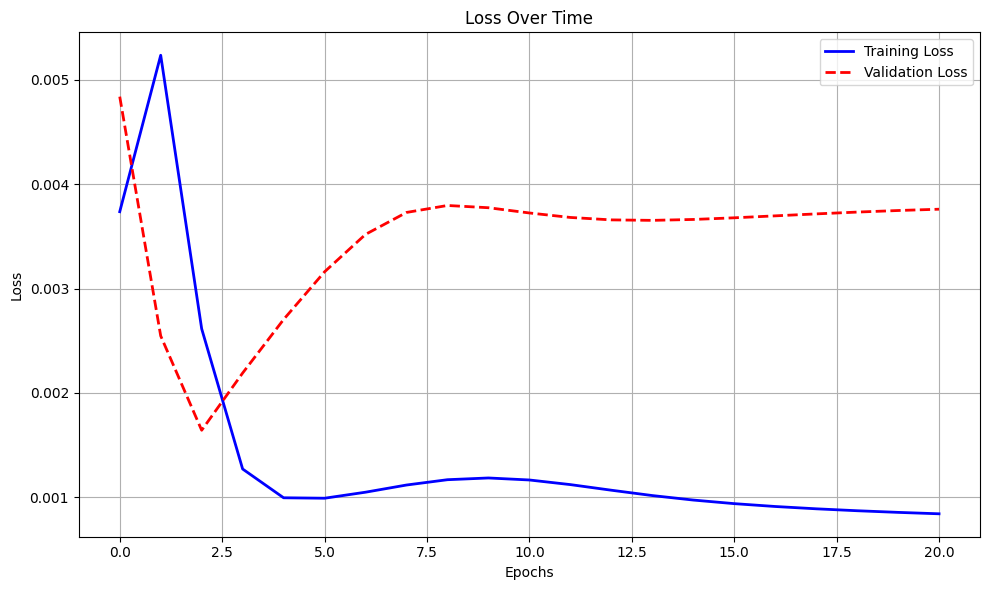

7/7 [==============================] - 1s 2ms/step


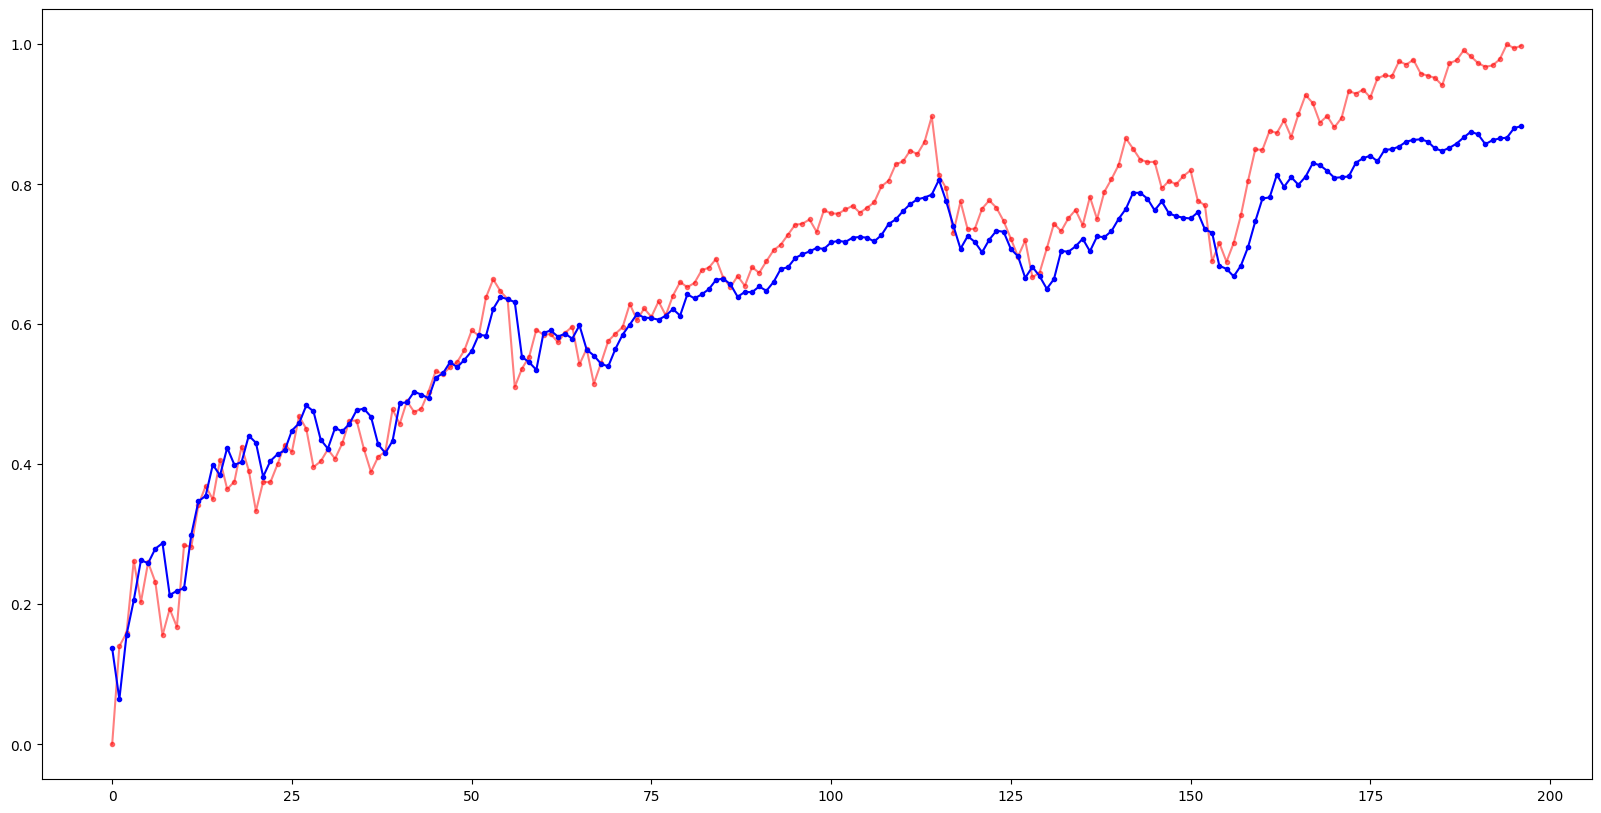

R2 Score: 0.9173977503942236
MAE: 0.048699445475536195
RMSE: 0.061034774313959074
Model 4: 200,100,100
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1, 200)            164000    
                                                                 
 lstm_3 (LSTM)               (None, 100)               120400    
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 284501 (1.09 MB)
Trainable params: 284501 (1.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
start: 0
Epoch 1/50
99/99 [==============================] - 6s 16ms/step - loss: 0.0037 - val_loss: 0.0061
Epoch 2/50
99/99 [==============================] - 1s 7ms/step - loss:

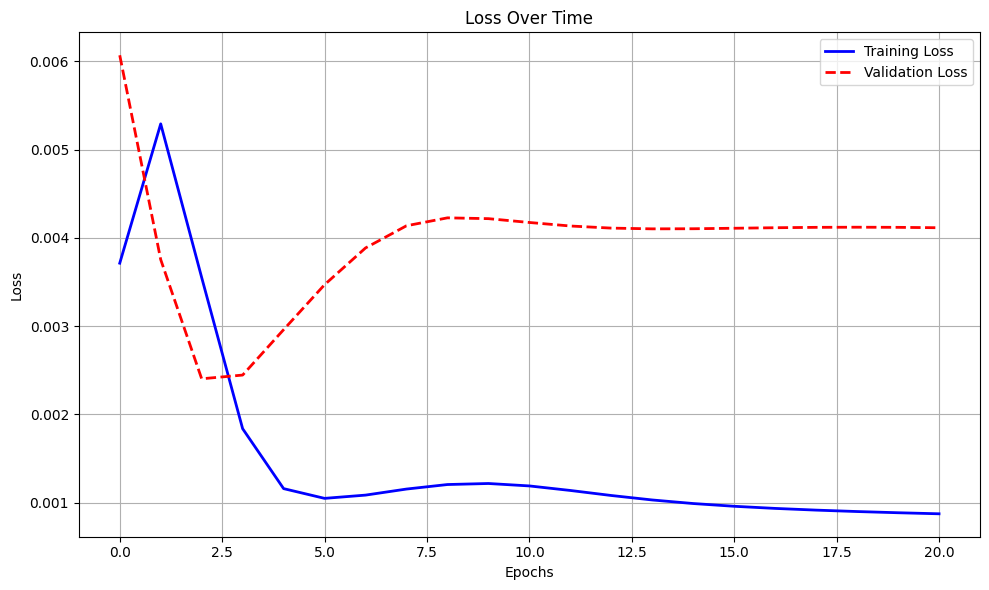

7/7 [==============================] - 1s 2ms/step


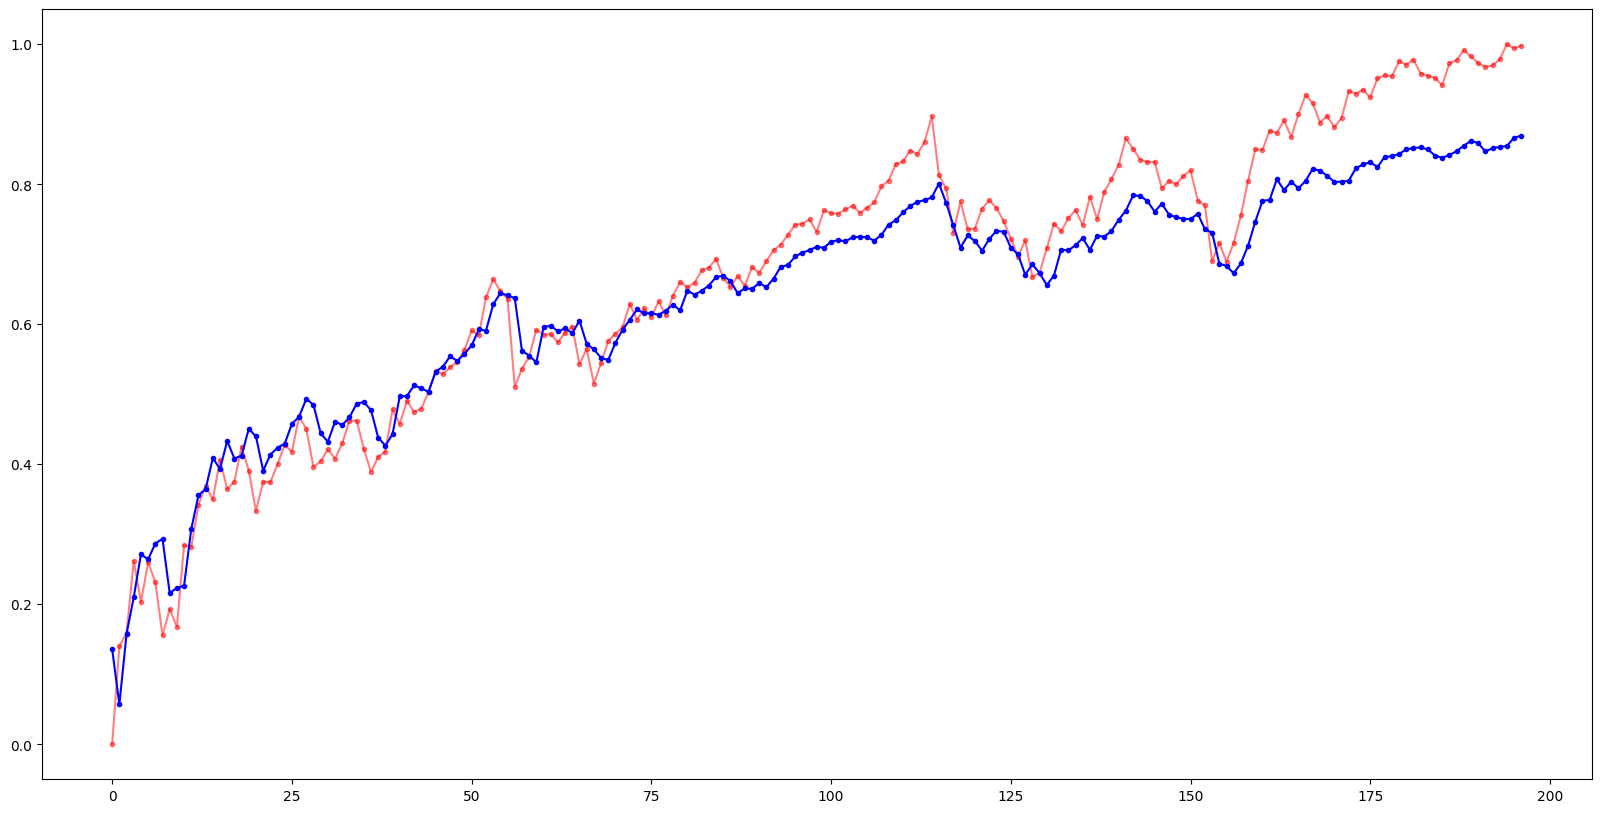

R2 Score: 0.9074424203747405
MAE: 0.051004606534555935
RMSE: 0.06460816406798729
Model 7: 120,105,105
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 1, 120)            60000     
                                                                 
 lstm_5 (LSTM)               (None, 105)               94920     
                                                                 
 dense_2 (Dense)             (None, 1)                 106       
                                                                 
Total params: 155026 (605.57 KB)
Trainable params: 155026 (605.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
start: 0
Epoch 1/50
99/99 [==============================] - 6s 14ms/step - loss: 0.0040 - val_loss: 0.0054
Epoch 2/50
99/99 [==============================] - 0s 5ms/step - lo

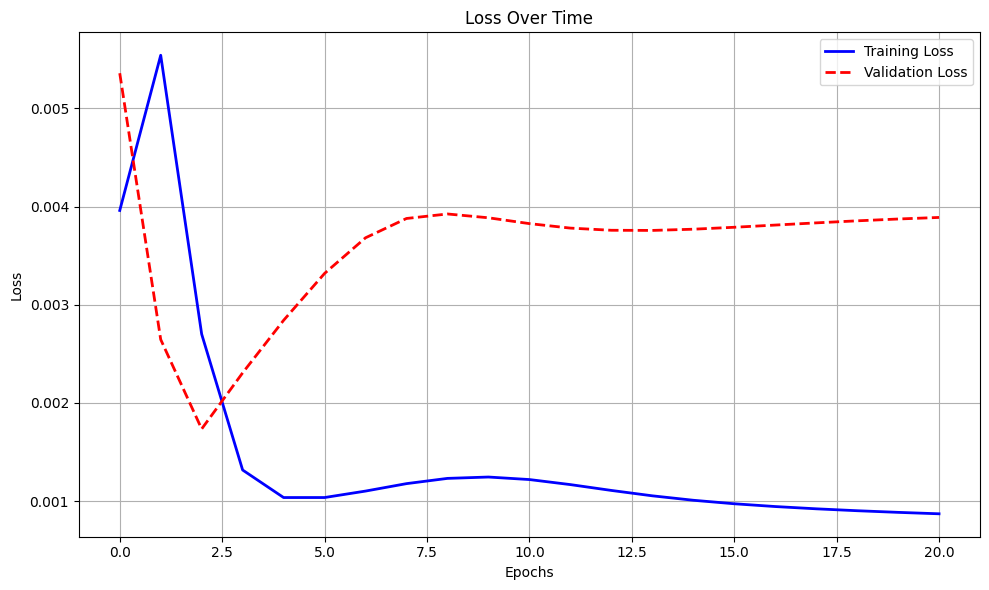

7/7 [==============================] - 1s 3ms/step


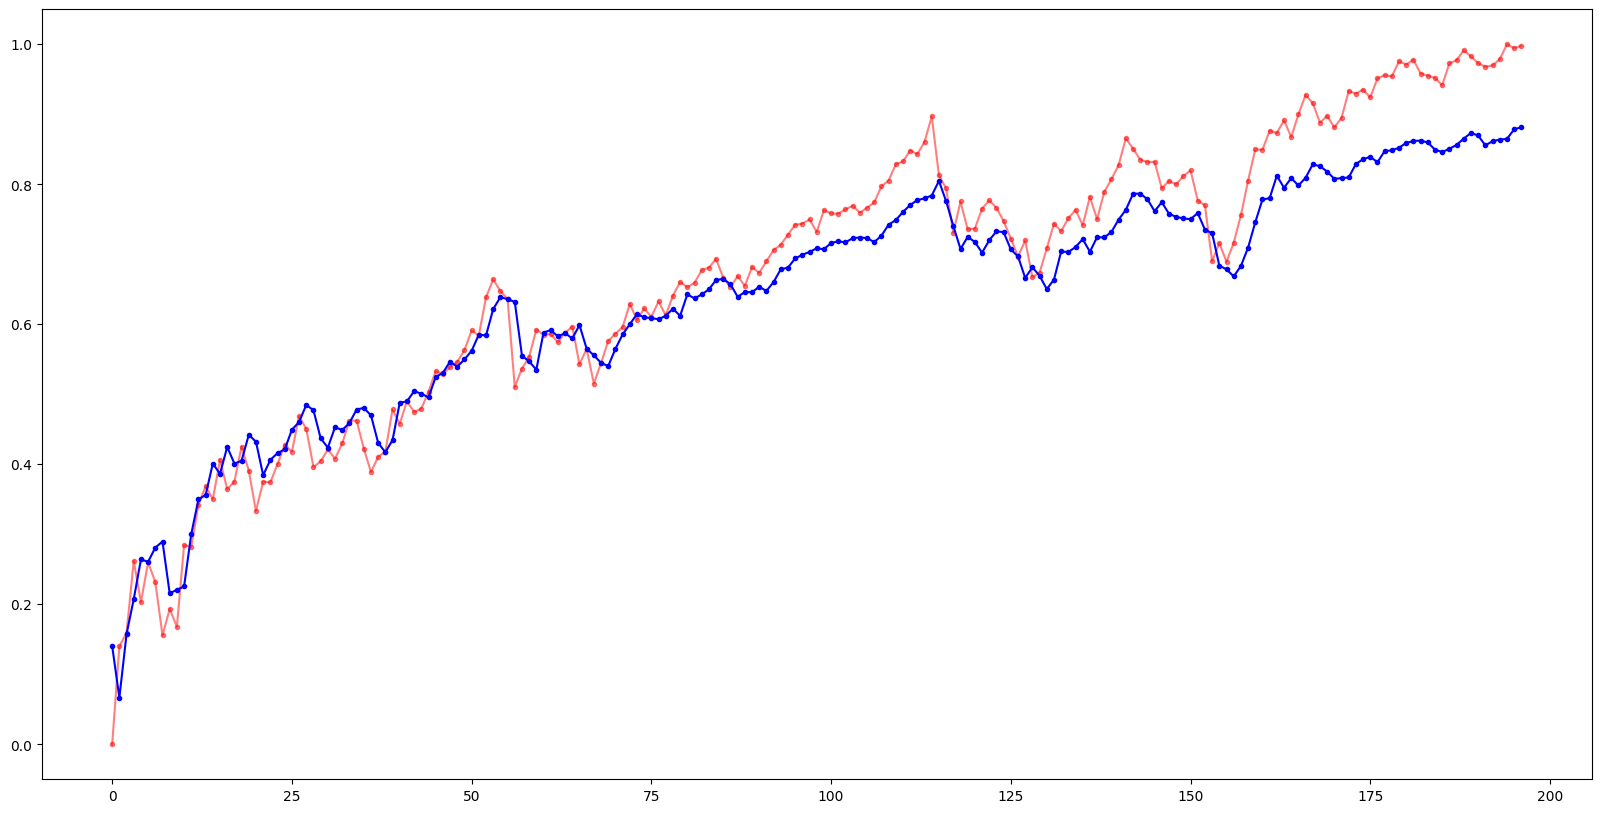

R2 Score: 0.9151579719581344
MAE: 0.04933431712645185
RMSE: 0.06185672549810097
Model 1: 120,100,100
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 2, 120)            60000     
                                                                 
 lstm_7 (LSTM)               (None, 100)               88400     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 148501 (580.08 KB)
Trainable params: 148501 (580.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
start: 0
Epoch 1/50
99/99 [==============================] - 6s 15ms/step - loss: 0.0028 - val_loss: 0.0254
Epoch 2/50
99/99 [==============================] - 1s 5ms/step - los

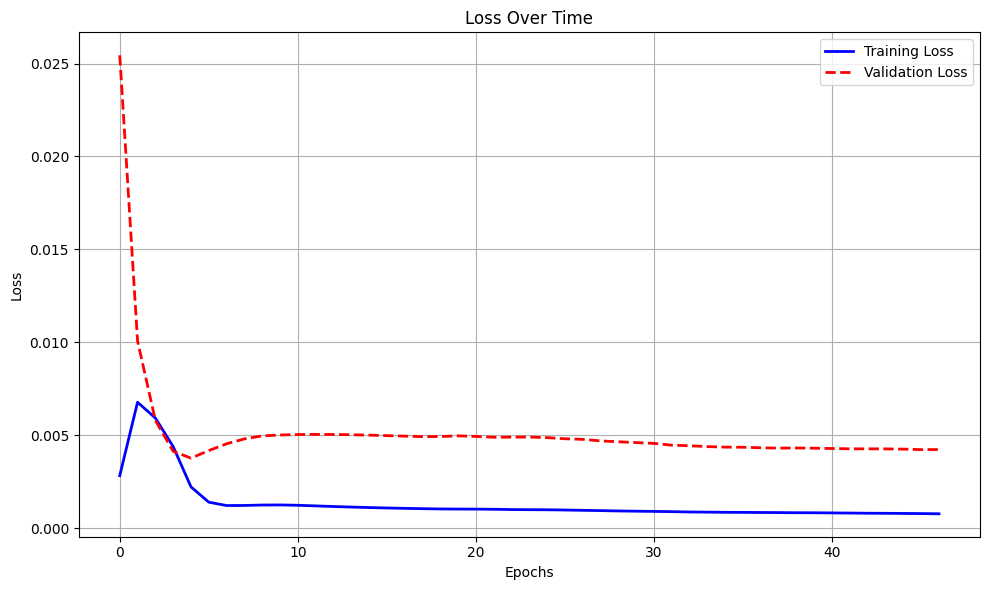

7/7 [==============================] - 1s 2ms/step


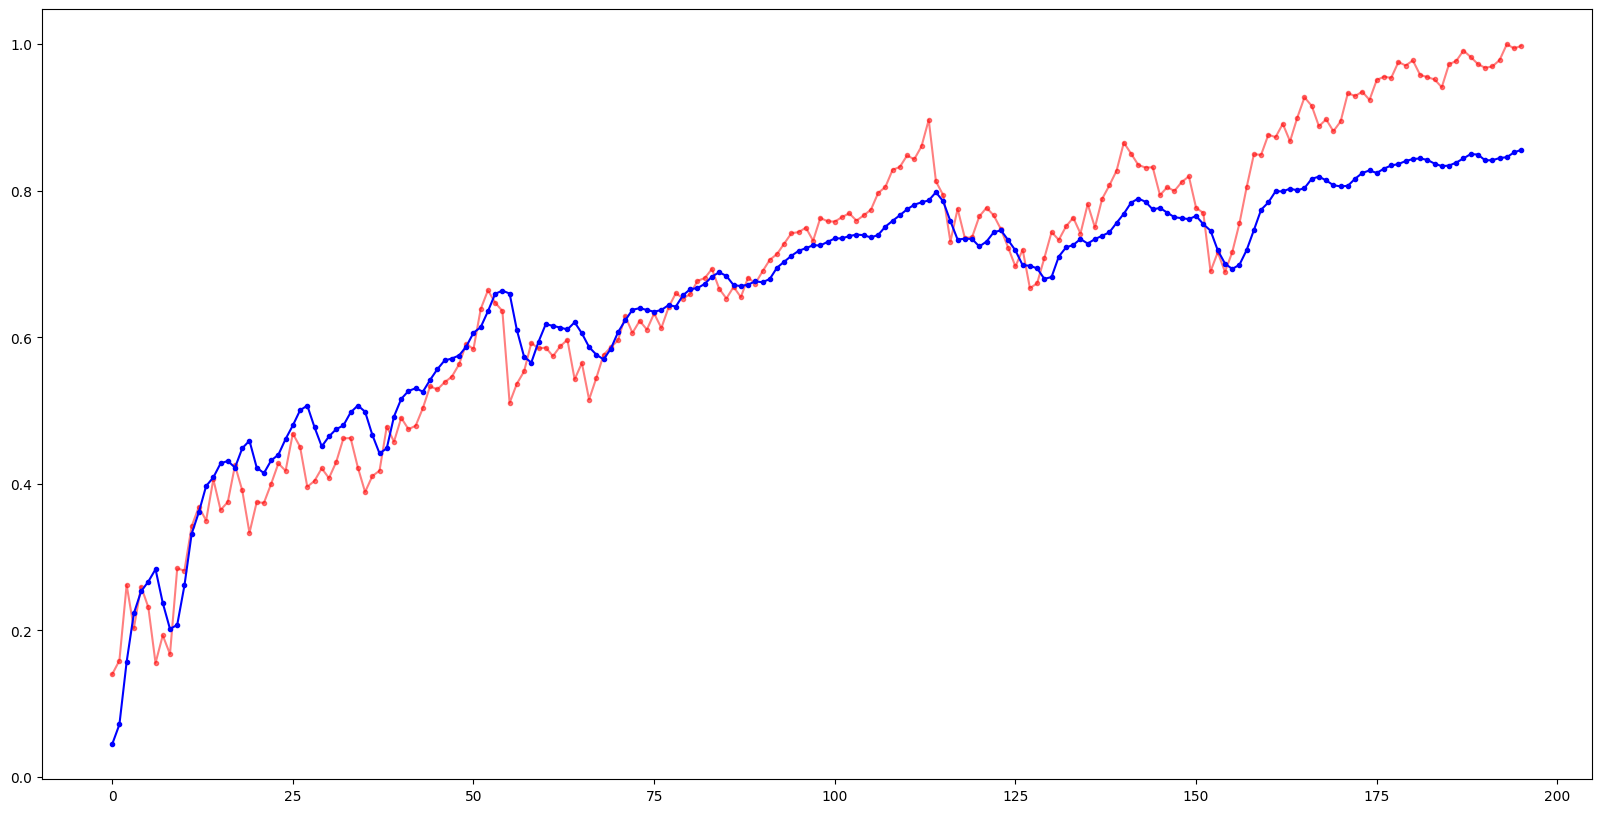

R2 Score: 0.8992720908857316
MAE: 0.051255283136442745
RMSE: 0.06583378990767952
Model 4: 200,100,100
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 2, 200)            164000    
                                                                 
 lstm_9 (LSTM)               (None, 100)               120400    
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 284501 (1.09 MB)
Trainable params: 284501 (1.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
start: 0
Epoch 1/50
99/99 [==============================] - 6s 19ms/step - loss: 0.0021 - val_loss: 0.0339
Epoch 2/50
99/99 [==============================] - 1s 9ms/step - loss: 

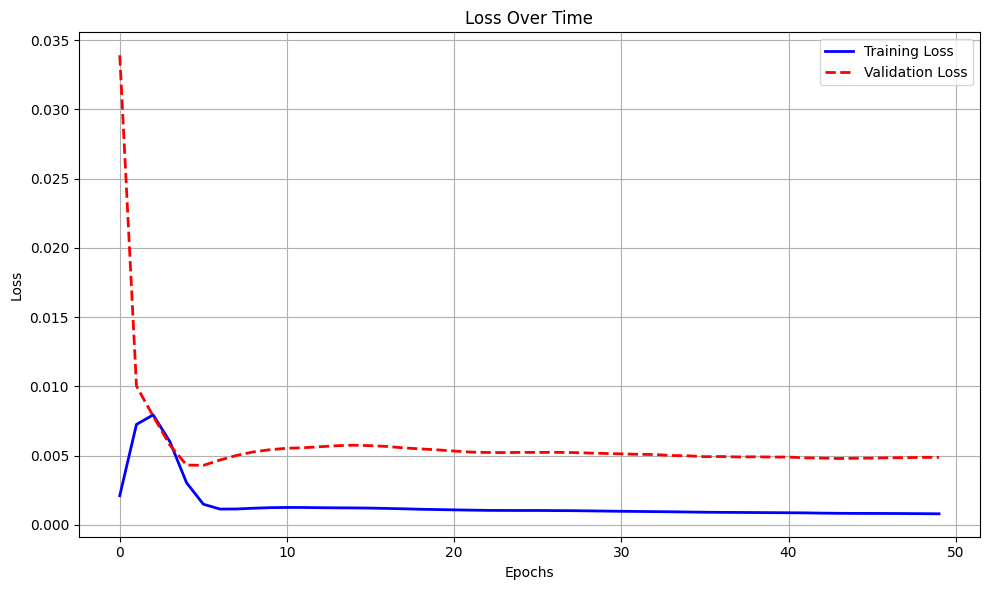

7/7 [==============================] - 1s 3ms/step


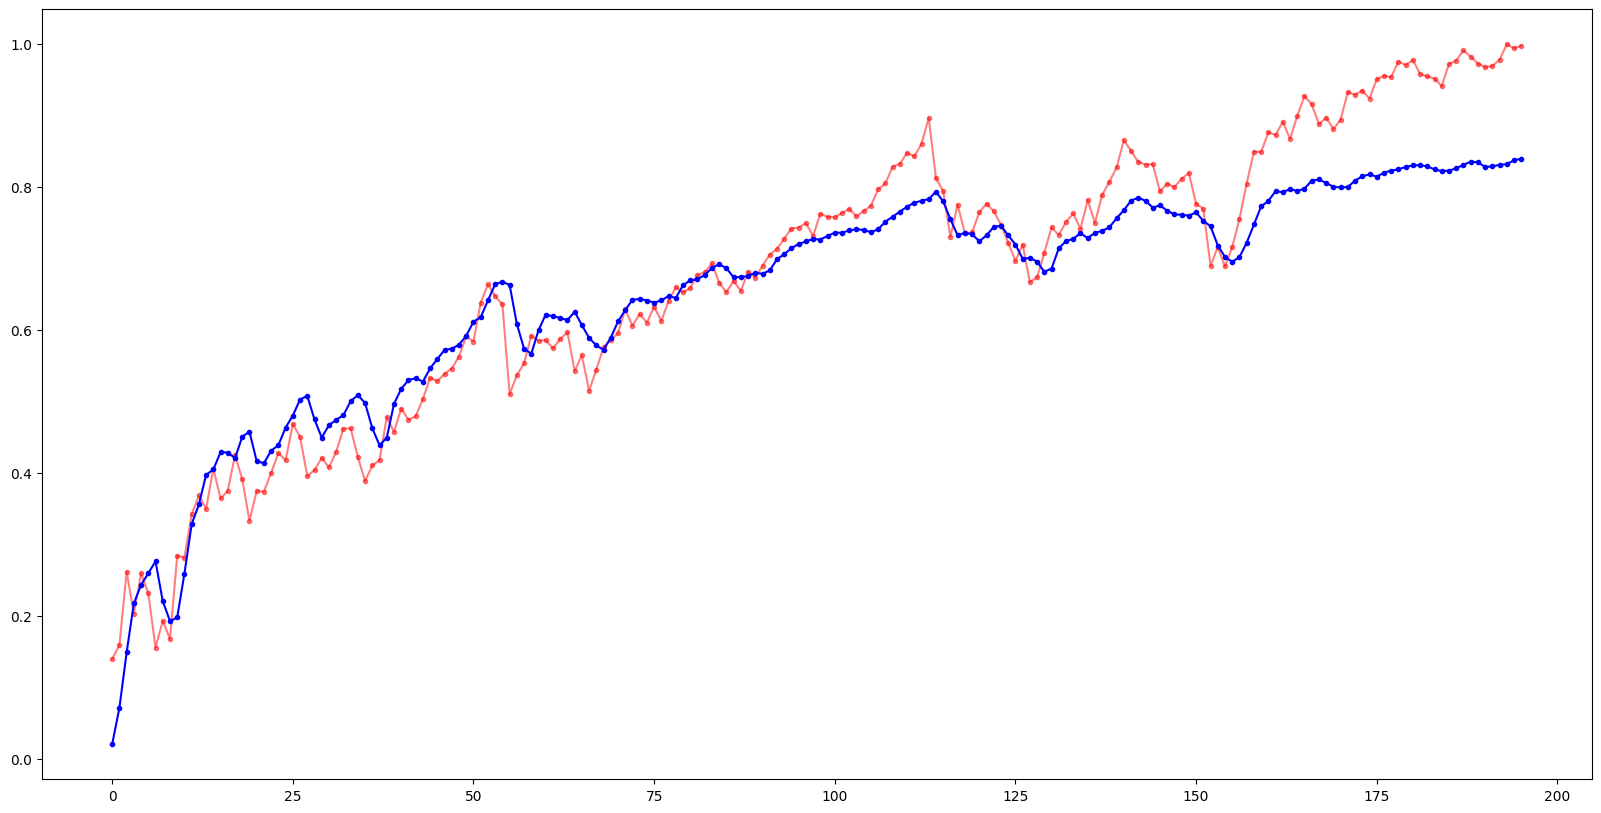

R2 Score: 0.8868158538230431
MAE: 0.05362781803283377
RMSE: 0.06978574949842051
Model 7: 120,105,105
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 2, 120)            60000     
                                                                 
 lstm_11 (LSTM)              (None, 105)               94920     
                                                                 
 dense_5 (Dense)             (None, 1)                 106       
                                                                 
Total params: 155026 (605.57 KB)
Trainable params: 155026 (605.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
start: 0
Epoch 1/50
99/99 [==============================] - 6s 15ms/step - loss: 0.0023 - val_loss: 0.0214
Epoch 2/50
99/99 [==============================] - 1s 6ms/step - los

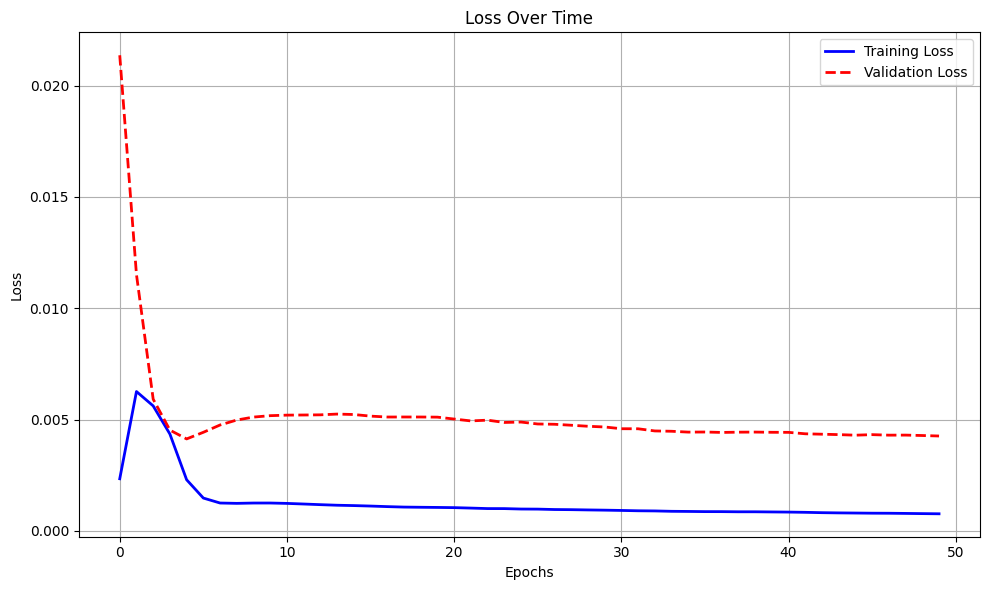

7/7 [==============================] - 1s 2ms/step


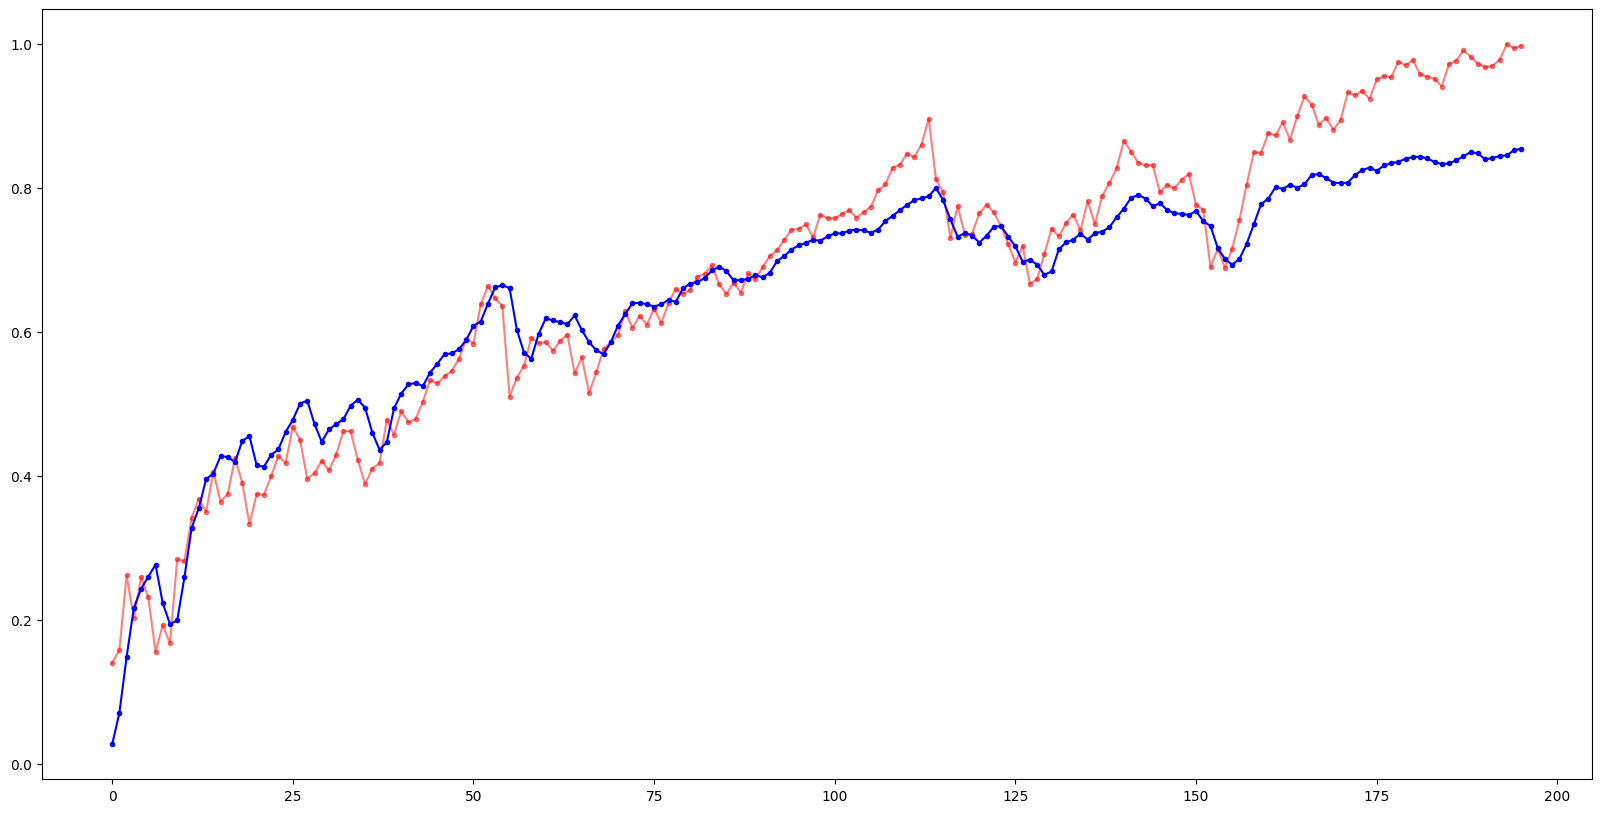

R2 Score: 0.9009569045823578
MAE: 0.050491753618352
RMSE: 0.06528088751550207
Model 1: 120,100,100
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 3, 120)            60000     
                                                                 
 lstm_13 (LSTM)              (None, 100)               88400     
                                                                 
 dense_6 (Dense)             (None, 1)                 101       
                                                                 
Total params: 148501 (580.08 KB)
Trainable params: 148501 (580.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
start: 0
Epoch 1/50
99/99 [==============================] - 6s 16ms/step - loss: 0.0021 - val_loss: 0.0414
Epoch 2/50
99/99 [==============================] - 1s 6ms/step - loss:

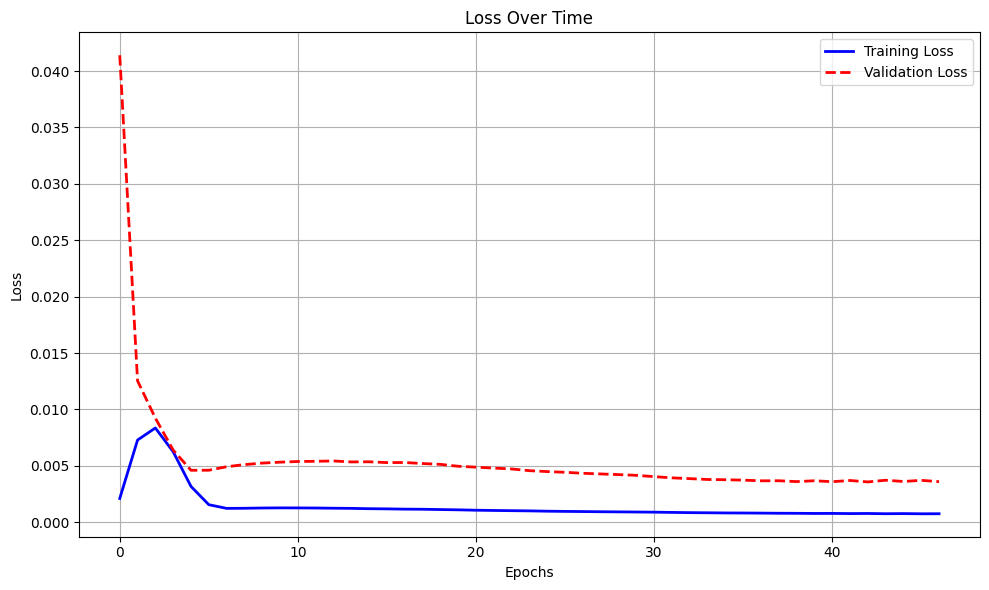

7/7 [==============================] - 1s 3ms/step


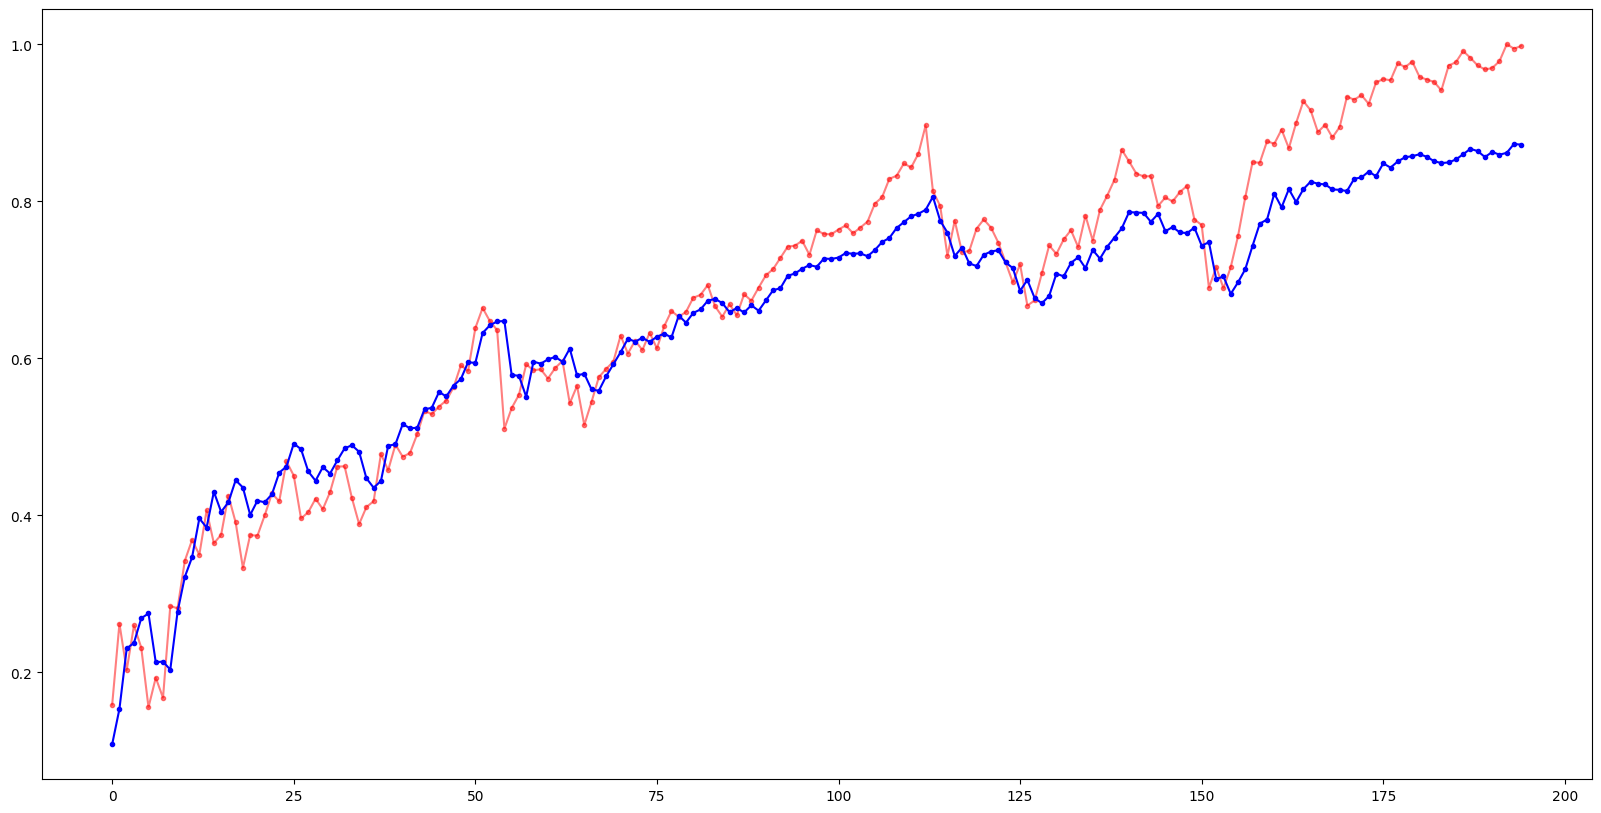

R2 Score: 0.9120834077099806
MAE: 0.04780586589937218
RMSE: 0.06060894643159681
Model 4: 200,100,100
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 3, 200)            164000    
                                                                 
 lstm_15 (LSTM)              (None, 100)               120400    
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 284501 (1.09 MB)
Trainable params: 284501 (1.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
start: 0
Epoch 1/50
99/99 [==============================] - 6s 22ms/step - loss: 0.0022 - val_loss: 0.0433
Epoch 2/50
99/99 [==============================] - 1s 13ms/step - loss: 

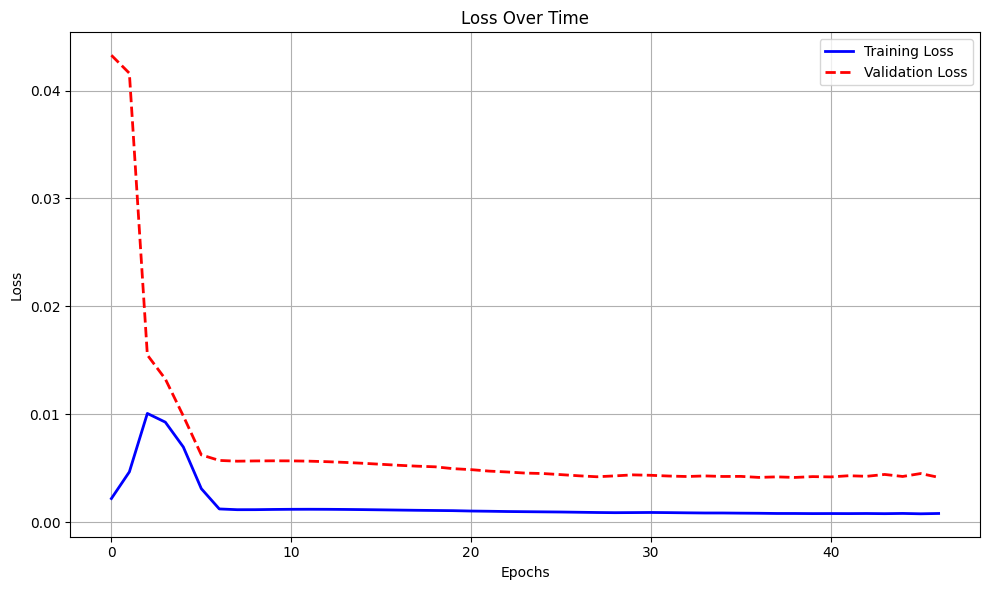

7/7 [==============================] - 1s 4ms/step


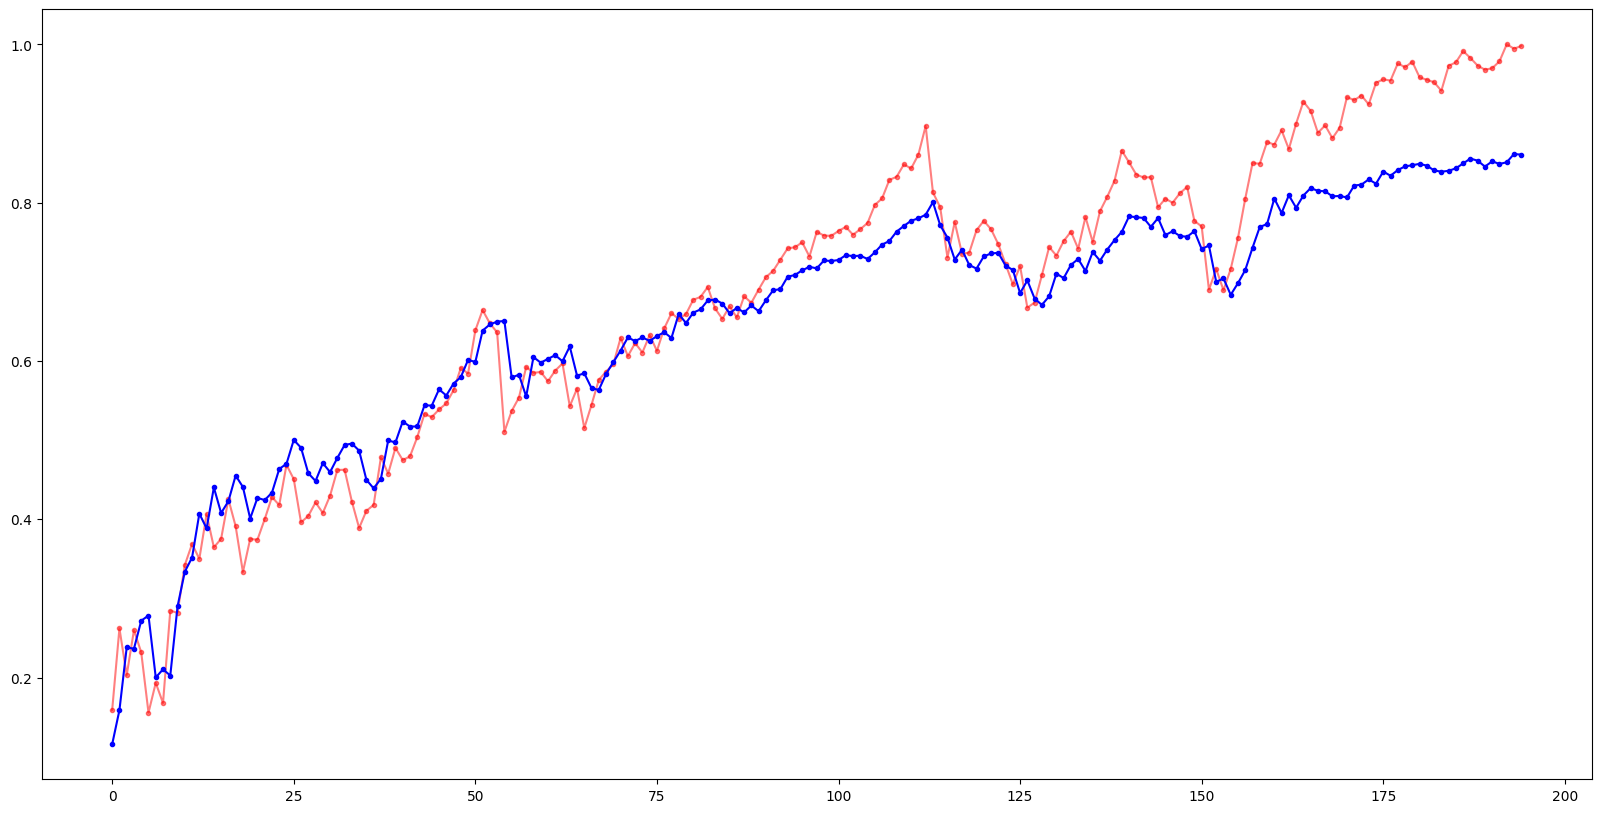

R2 Score: 0.9006251783496698
MAE: 0.05064992421484553
RMSE: 0.06443762019860395
Model 7: 120,105,105
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 3, 120)            60000     
                                                                 
 lstm_17 (LSTM)              (None, 105)               94920     
                                                                 
 dense_8 (Dense)             (None, 1)                 106       
                                                                 
Total params: 155026 (605.57 KB)
Trainable params: 155026 (605.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
start: 0
Epoch 1/50
99/99 [==============================] - 6s 18ms/step - loss: 0.0022 - val_loss: 0.0441
Epoch 2/50
99/99 [==============================] - 1s 8ms/step - los

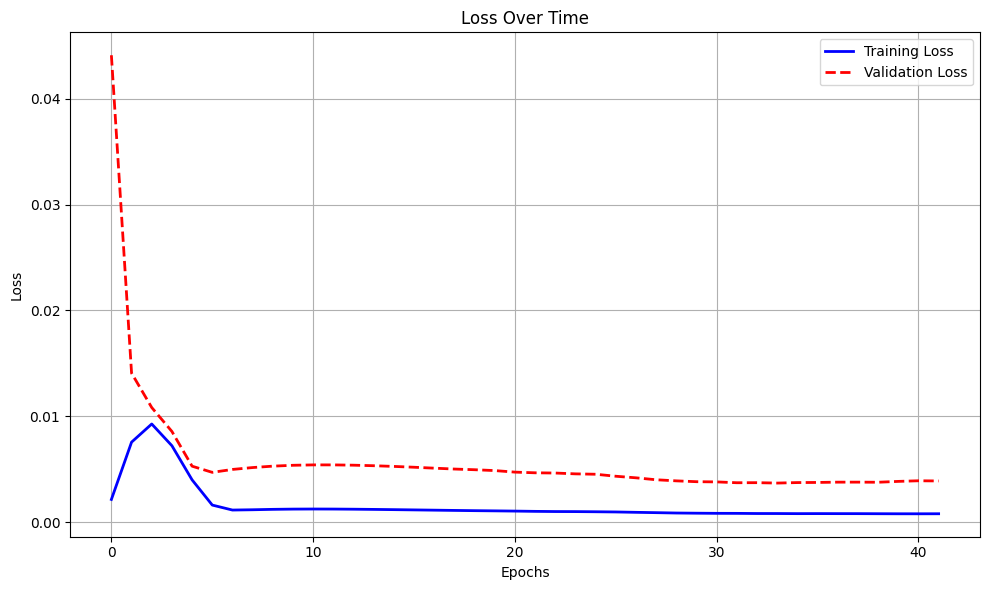

7/7 [==============================] - 1s 4ms/step


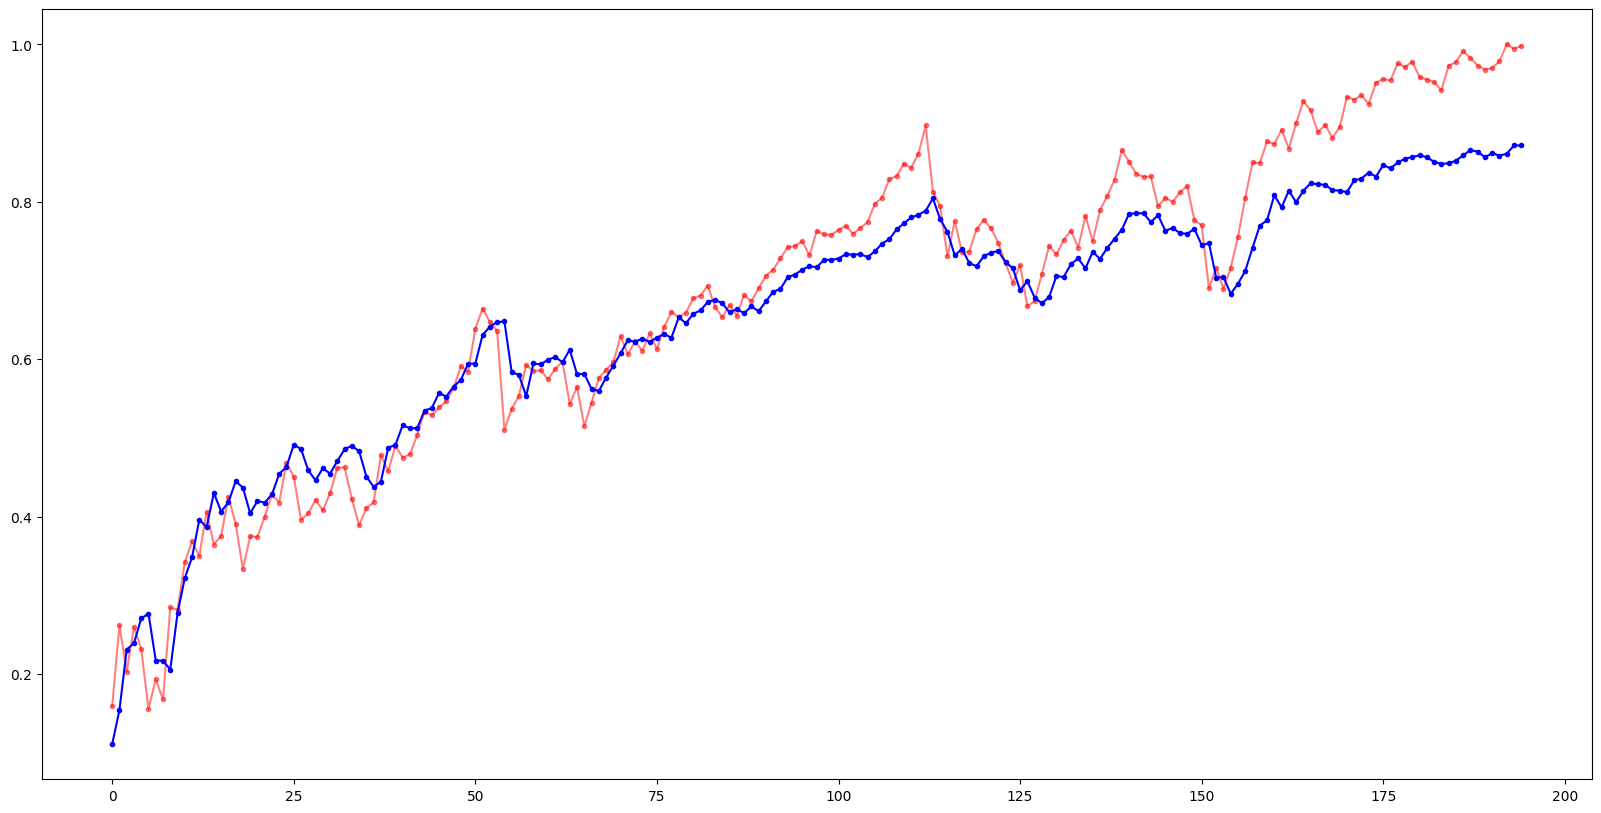

R2 Score: 0.9105826473466722
MAE: 0.048266194675691376
RMSE: 0.06112406311426214
Model 1: 120,100,100
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 4, 120)            60000     
                                                                 
 lstm_19 (LSTM)              (None, 100)               88400     
                                                                 
 dense_9 (Dense)             (None, 1)                 101       
                                                                 
Total params: 148501 (580.08 KB)
Trainable params: 148501 (580.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
start: 0
Epoch 1/50
98/98 [==============================] - 6s 20ms/step - loss: 0.0023 - val_loss: 0.0314
Epoch 2/50
98/98 [==============================] - 1s 10ms/step - l

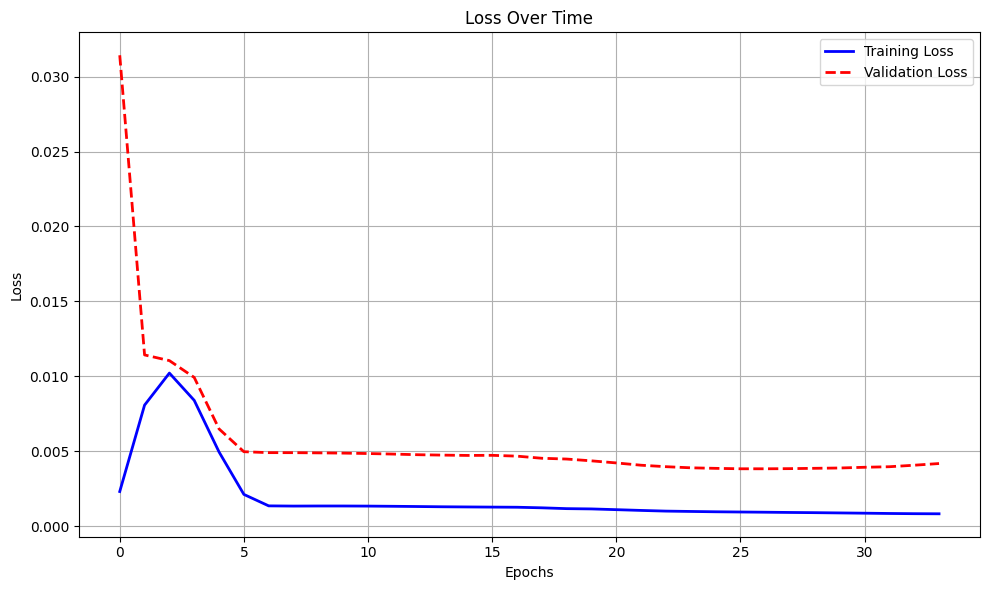

7/7 [==============================] - 1s 5ms/step


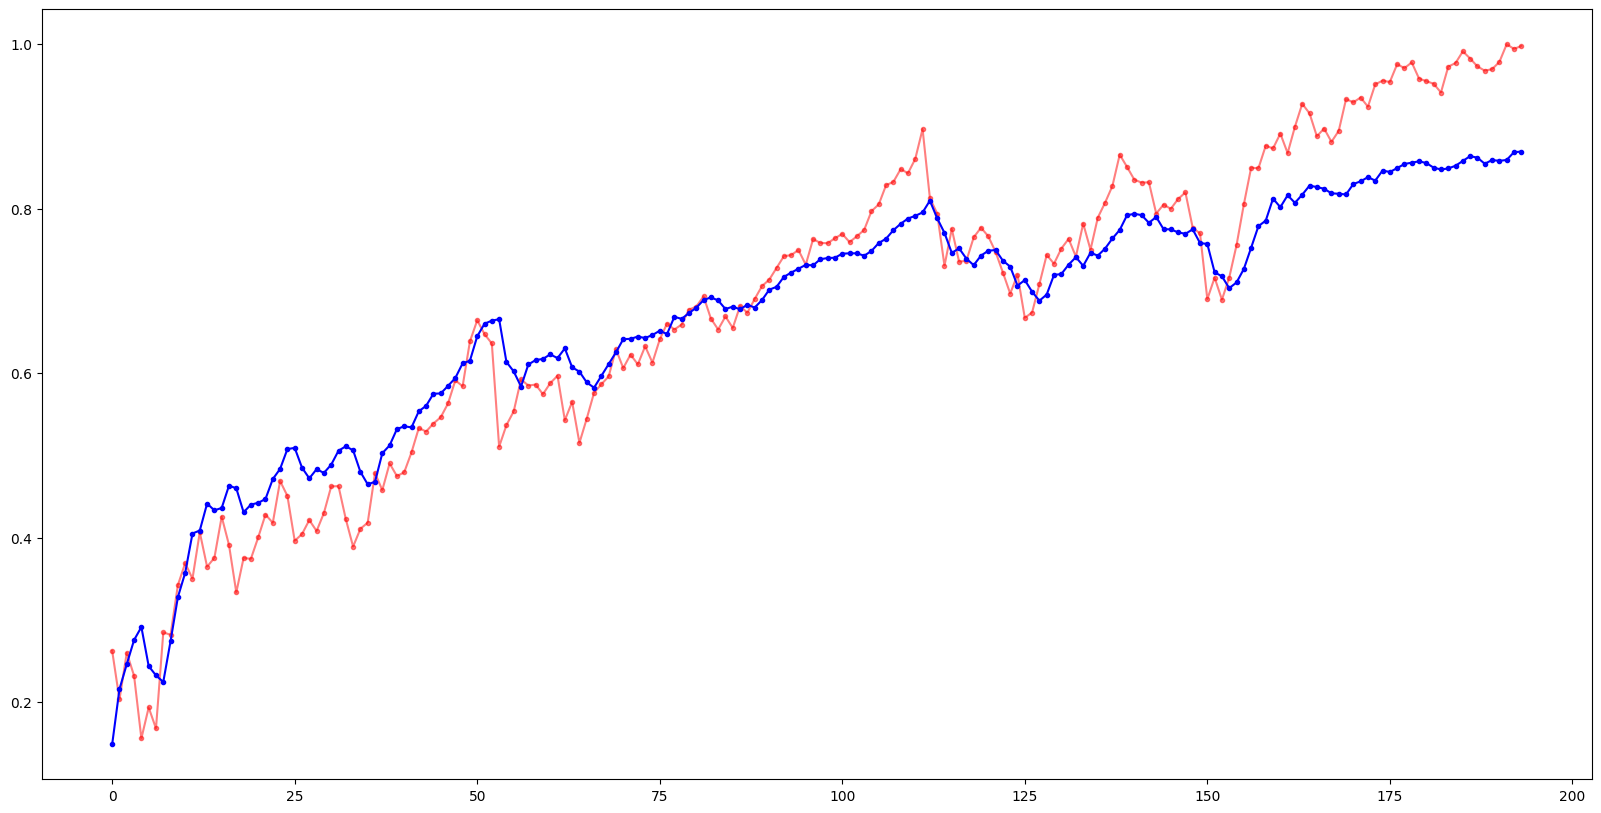

R2 Score: 0.9042144079605372
MAE: 0.04935815706921123
RMSE: 0.0623715246131913
Model 4: 200,100,100
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 4, 200)            164000    
                                                                 
 lstm_21 (LSTM)              (None, 100)               120400    
                                                                 
 dense_10 (Dense)            (None, 1)                 101       
                                                                 
Total params: 284501 (1.09 MB)
Trainable params: 284501 (1.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
start: 0
Epoch 1/50
98/98 [==============================] - 6s 29ms/step - loss: 0.0017 - val_loss: 0.0387
Epoch 2/50
98/98 [==============================] - 2s 19ms/step - loss: 

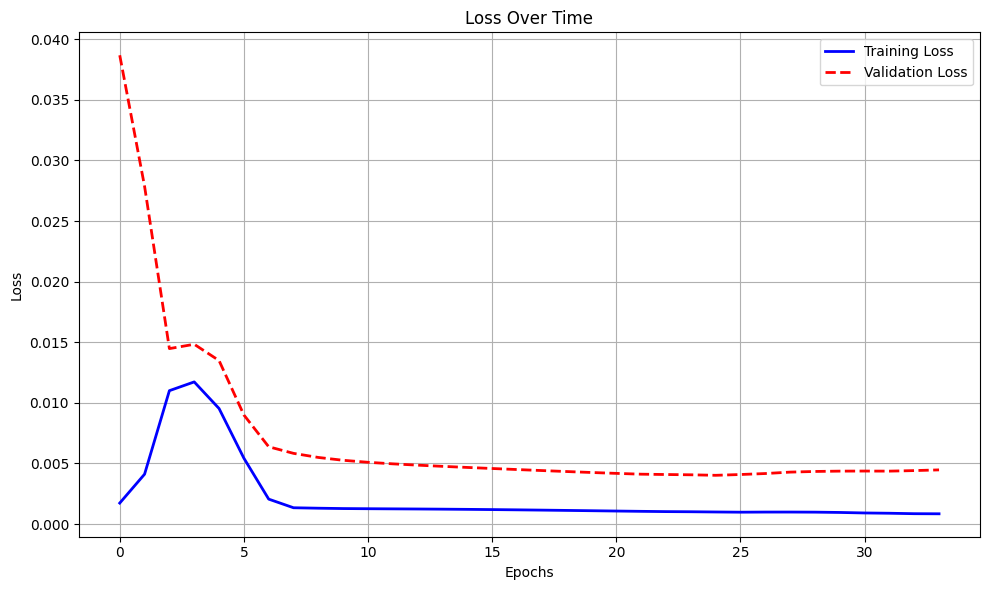

7/7 [==============================] - 1s 7ms/step


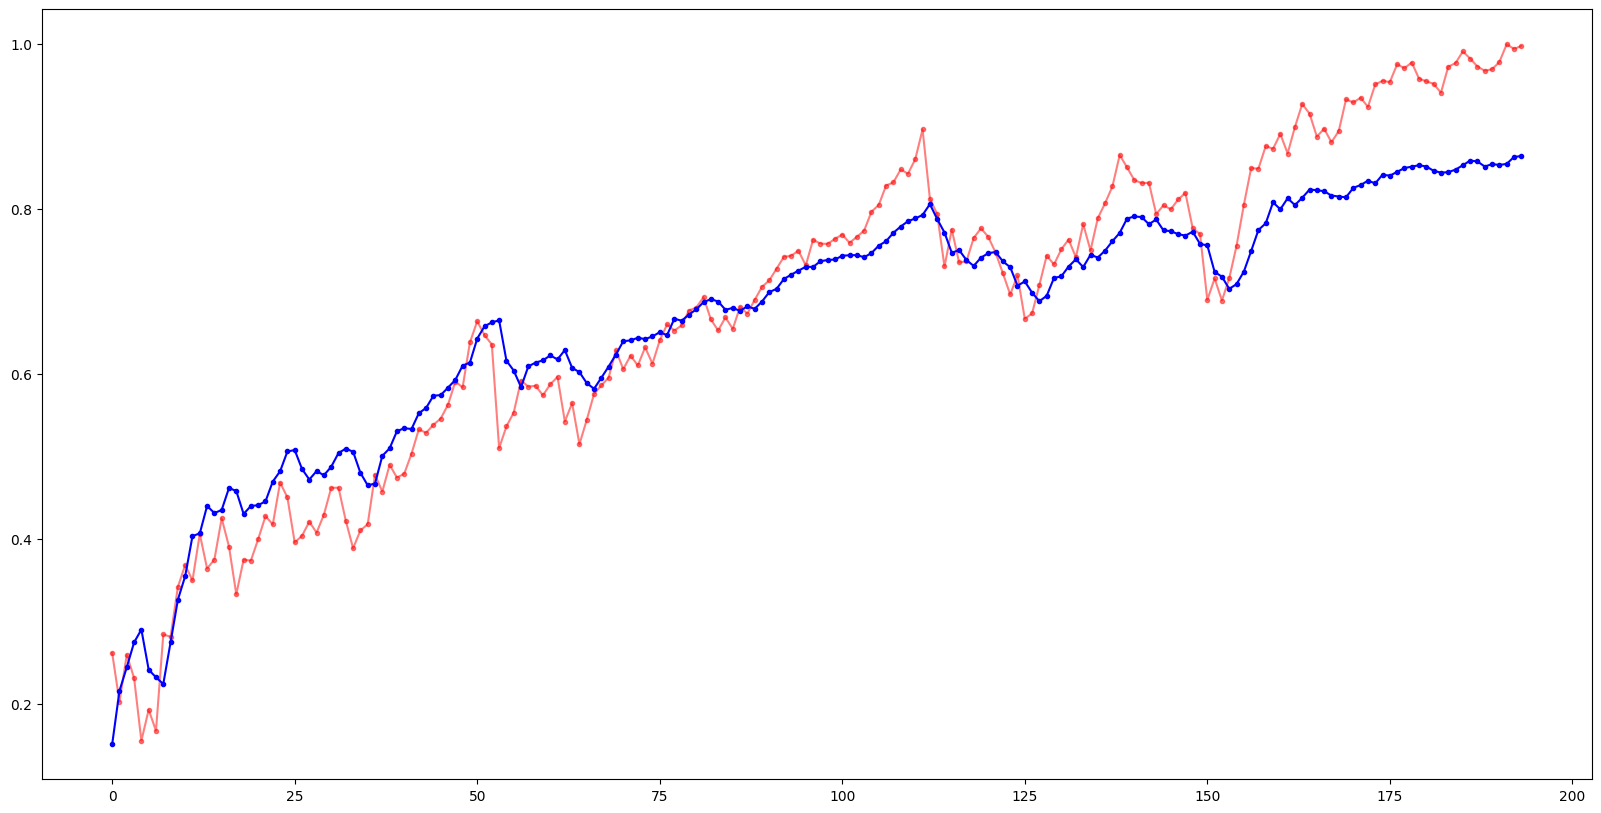

R2 Score: 0.9000074457780378
MAE: 0.05032978183133831
RMSE: 0.06372650447844751
Model 7: 120,105,105
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 4, 120)            60000     
                                                                 
 lstm_23 (LSTM)              (None, 105)               94920     
                                                                 
 dense_11 (Dense)            (None, 1)                 106       
                                                                 
Total params: 155026 (605.57 KB)
Trainable params: 155026 (605.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
start: 0
Epoch 1/50
98/98 [==============================] - 5s 18ms/step - loss: 0.0020 - val_loss: 0.0201
Epoch 2/50
98/98 [==============================] - 1s 9ms/step - lo

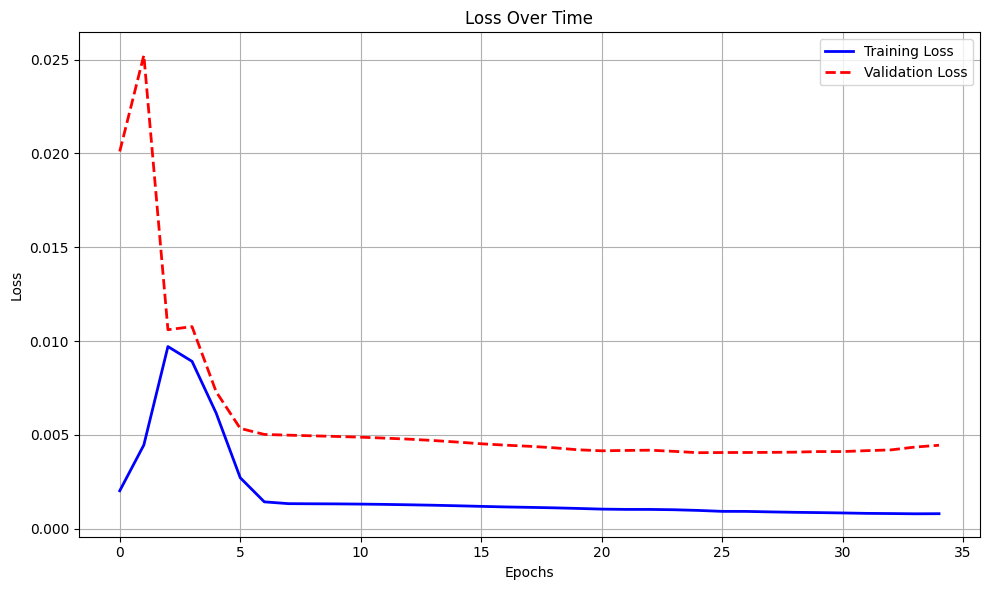

7/7 [==============================] - 1s 5ms/step


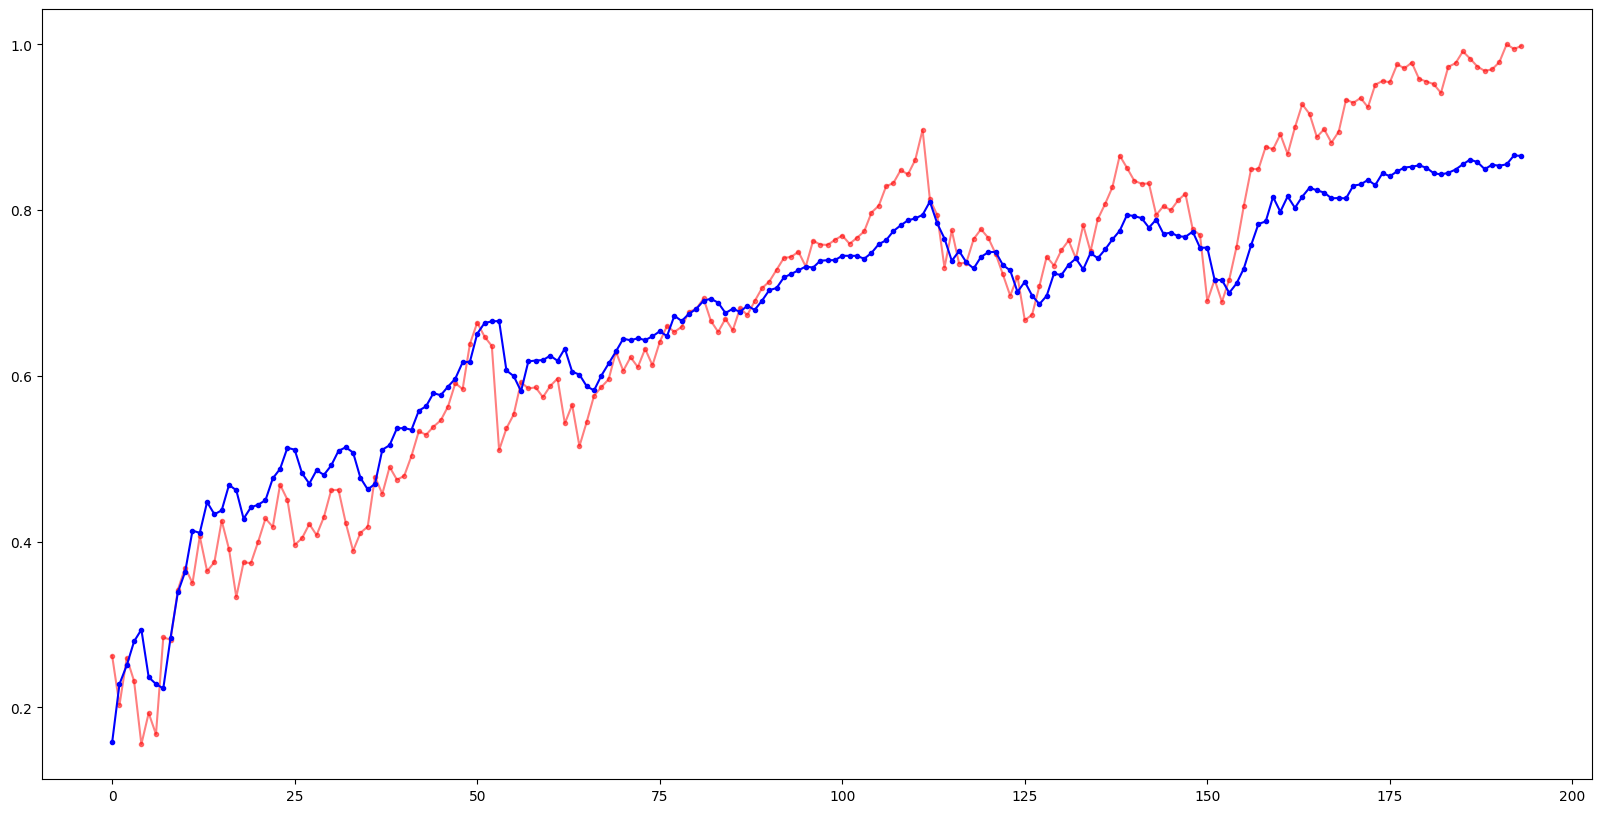

R2 Score: 0.9002875575477225
MAE: 0.05031377349197939
RMSE: 0.0636371825138045
Model 1: 120,100,100
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 5, 120)            60000     
                                                                 
 lstm_25 (LSTM)              (None, 100)               88400     
                                                                 
 dense_12 (Dense)            (None, 1)                 101       
                                                                 
Total params: 148501 (580.08 KB)
Trainable params: 148501 (580.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
start: 0
Epoch 1/50
98/98 [==============================] - 7s 24ms/step - loss: 0.0022 - val_loss: 0.0327
Epoch 2/50
98/98 [==============================] - 1s 14ms/step - lo

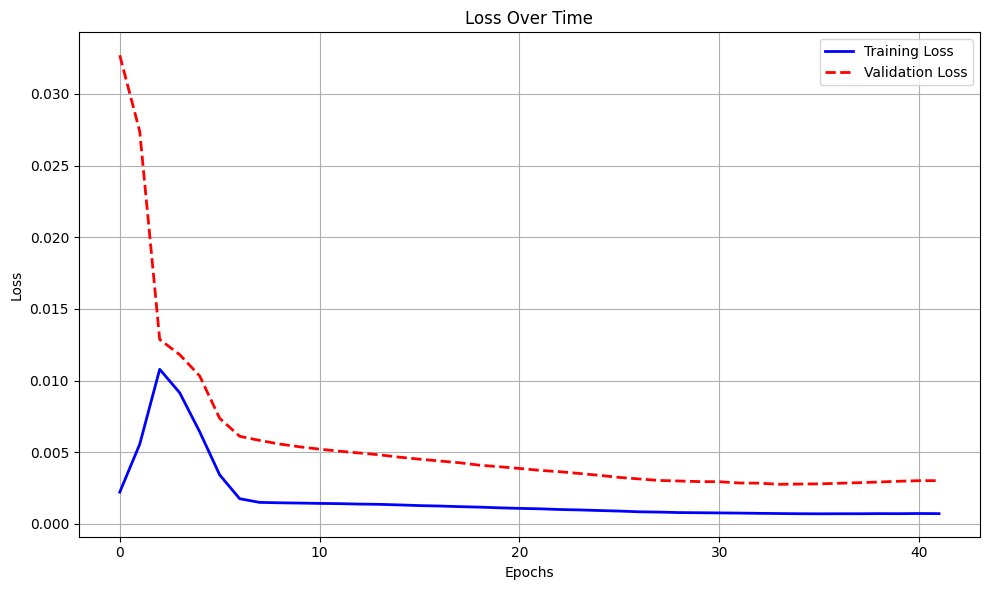

7/7 [==============================] - 1s 6ms/step


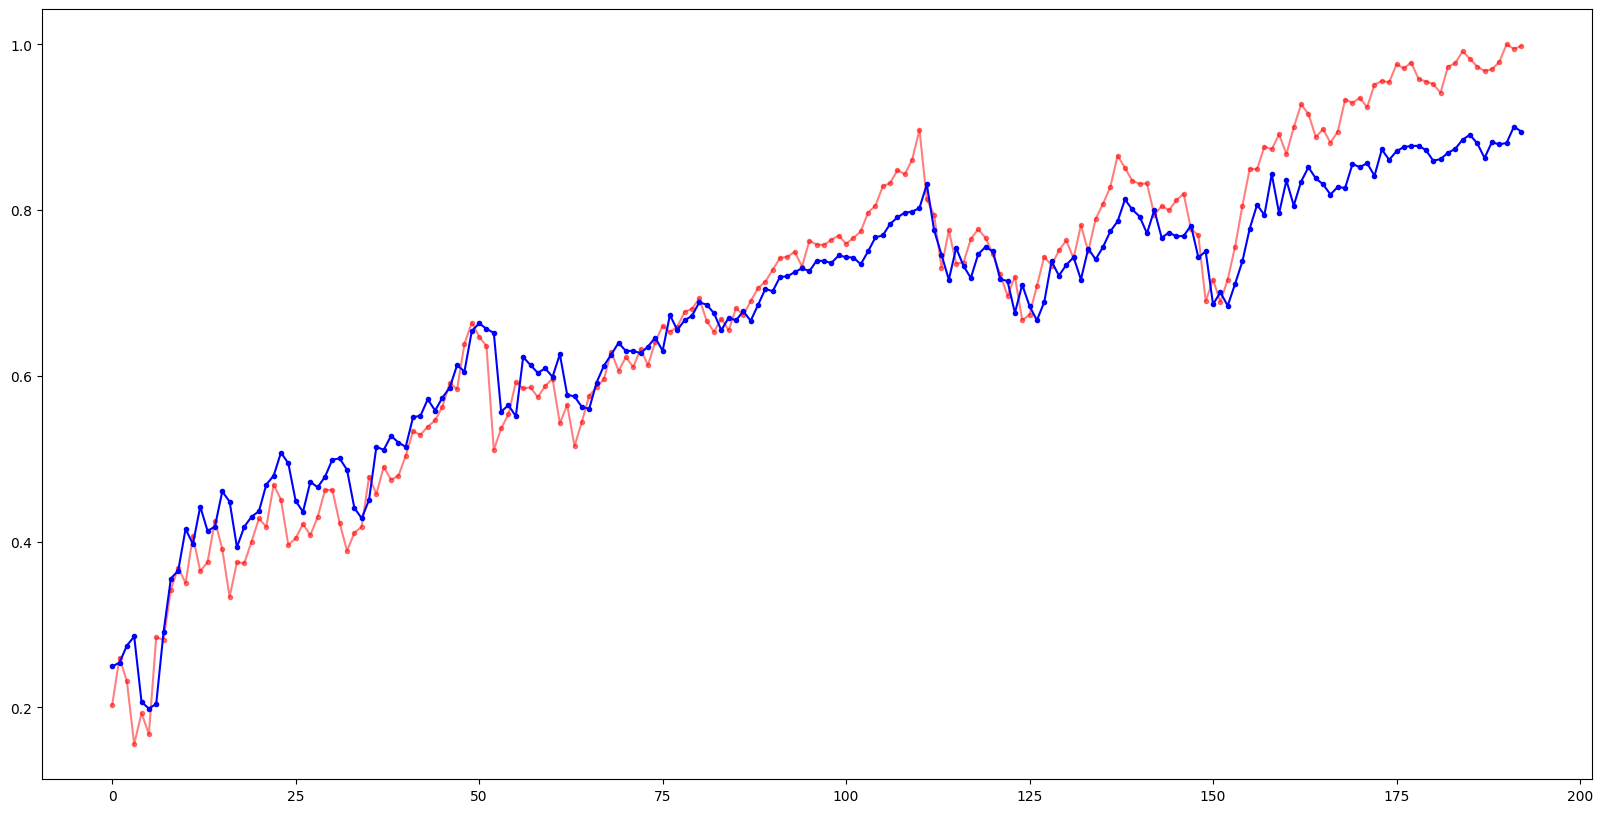

R2 Score: 0.928627687325964
MAE: 0.04238005551020932
RMSE: 0.05337807311876545
Model 4: 200,100,100
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 5, 200)            164000    
                                                                 
 lstm_27 (LSTM)              (None, 100)               120400    
                                                                 
 dense_13 (Dense)            (None, 1)                 101       
                                                                 
Total params: 284501 (1.09 MB)
Trainable params: 284501 (1.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
start: 0
Epoch 1/50
98/98 [==============================] - 8s 38ms/step - loss: 0.0022 - val_loss: 0.0301
Epoch 2/50
98/98 [==============================] - 3s 27ms/step - loss: 

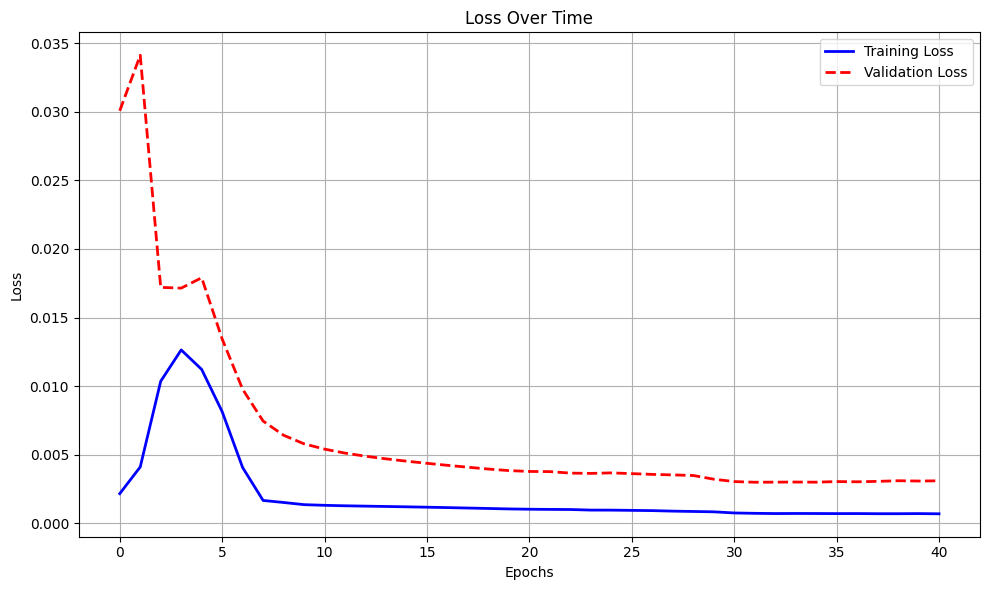

7/7 [==============================] - 1s 8ms/step


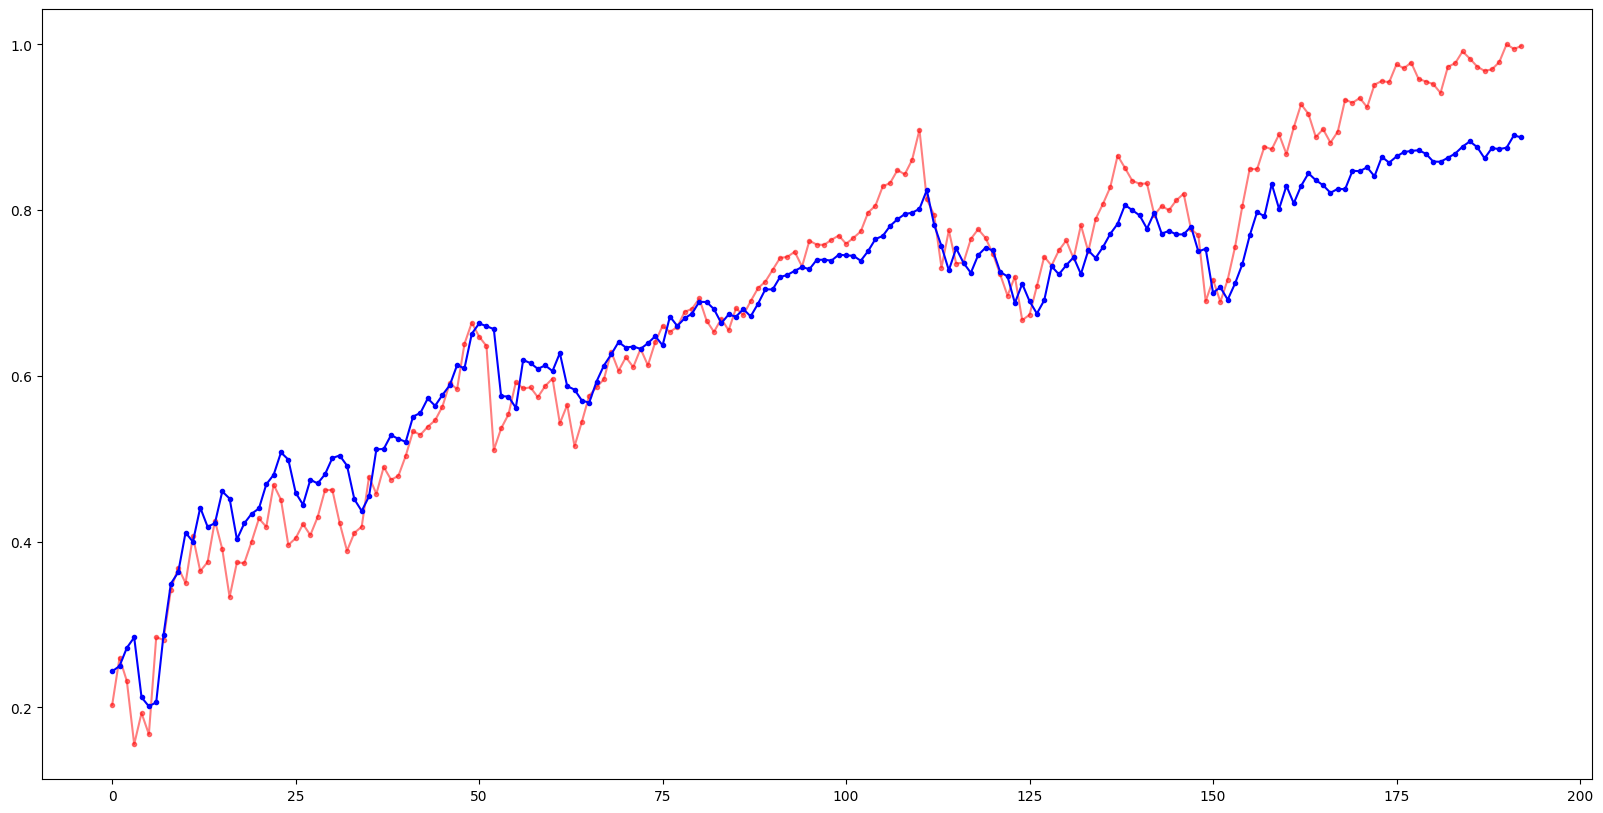

R2 Score: 0.9238098297518741
MAE: 0.043588585460956376
RMSE: 0.055150249248566326
Model 7: 120,105,105
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 5, 120)            60000     
                                                                 
 lstm_29 (LSTM)              (None, 105)               94920     
                                                                 
 dense_14 (Dense)            (None, 1)                 106       
                                                                 
Total params: 155026 (605.57 KB)
Trainable params: 155026 (605.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
start: 0
Epoch 1/50
98/98 [==============================] - 7s 23ms/step - loss: 0.0022 - val_loss: 0.0284
Epoch 2/50
98/98 [==============================] - 1s 14ms/step -

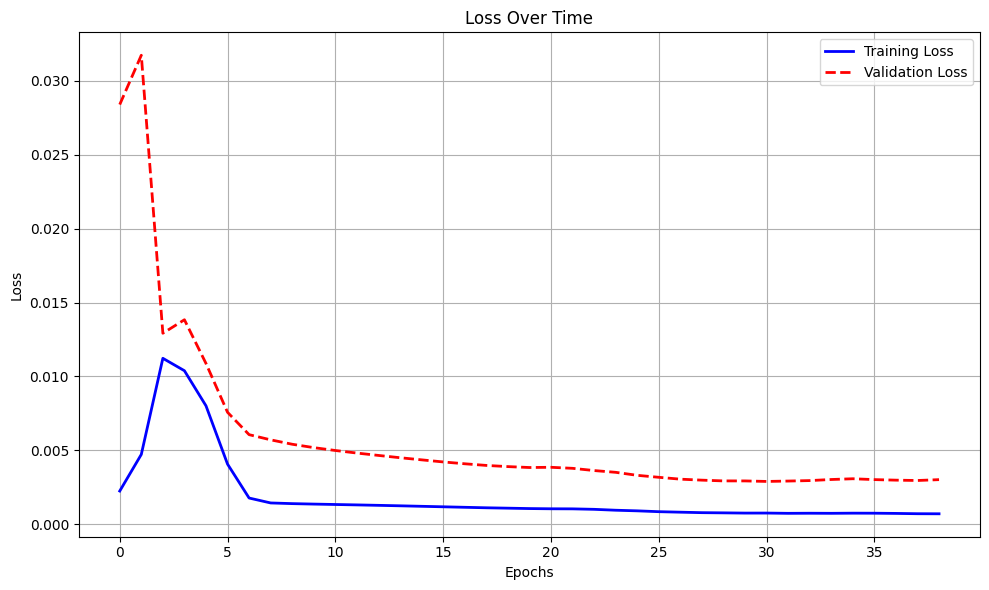

7/7 [==============================] - 1s 7ms/step


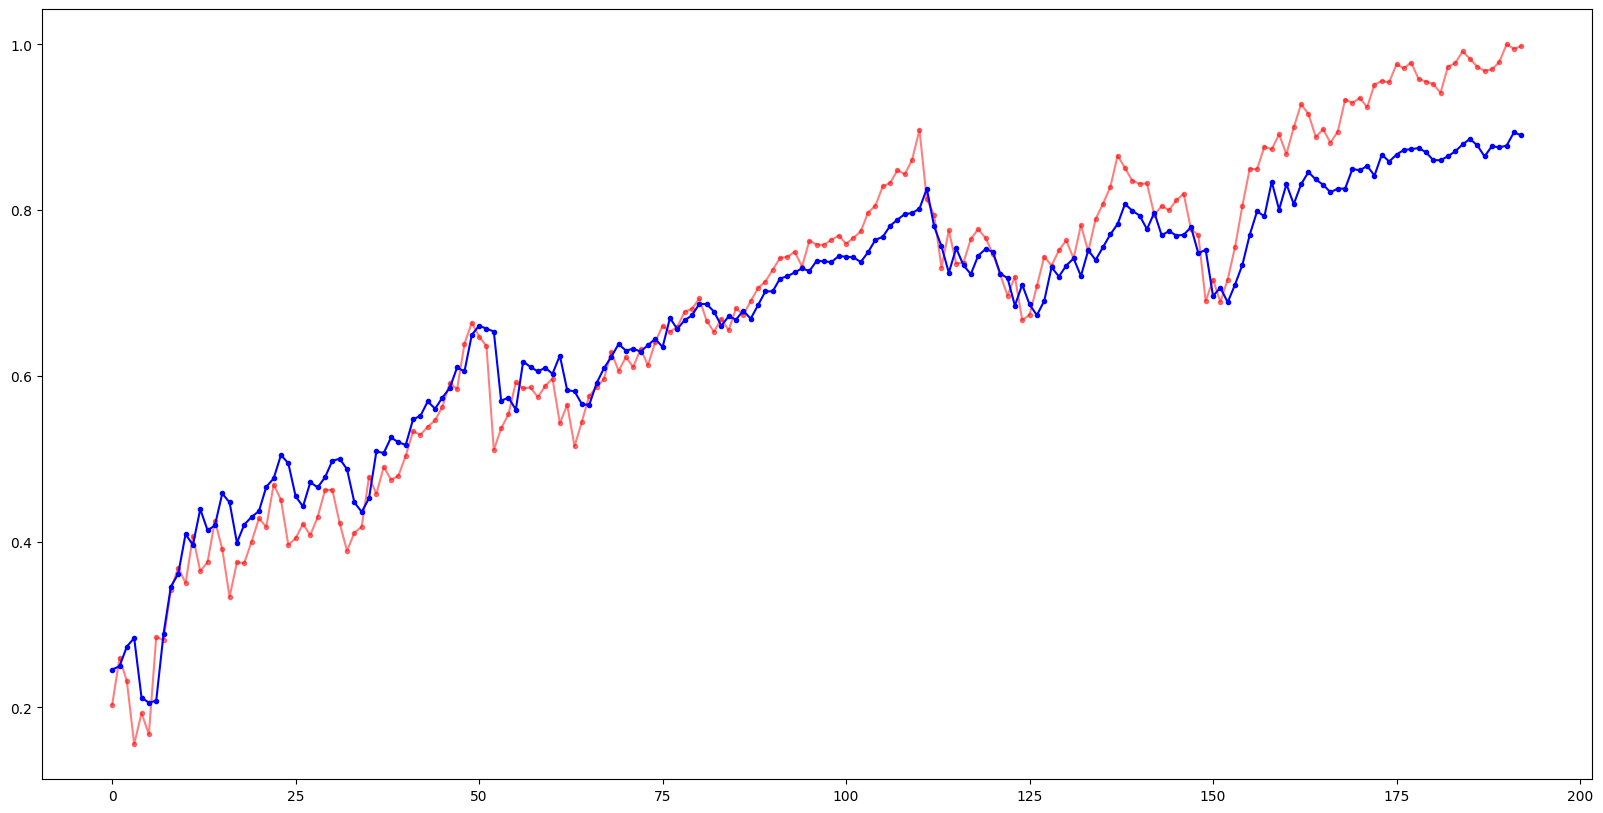

R2 Score: 0.9265675898662395
MAE: 0.04286221580115401
RMSE: 0.05414294800476043
Model 1: 120,100,100
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 6, 120)            60000     
                                                                 
 lstm_31 (LSTM)              (None, 100)               88400     
                                                                 
 dense_15 (Dense)            (None, 1)                 101       
                                                                 
Total params: 148501 (580.08 KB)
Trainable params: 148501 (580.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
start: 0
Epoch 1/50
98/98 [==============================] - 7s 24ms/step - loss: 0.0022 - val_loss: 0.0367
Epoch 2/50
98/98 [==============================] - 1s 14ms/step - l

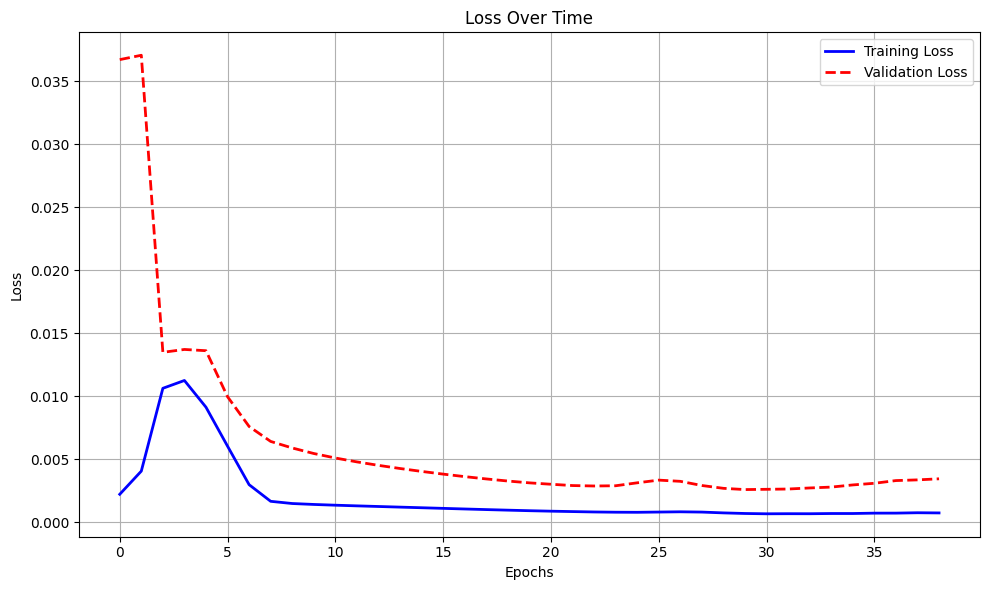

6/6 [==============================] - 1s 8ms/step


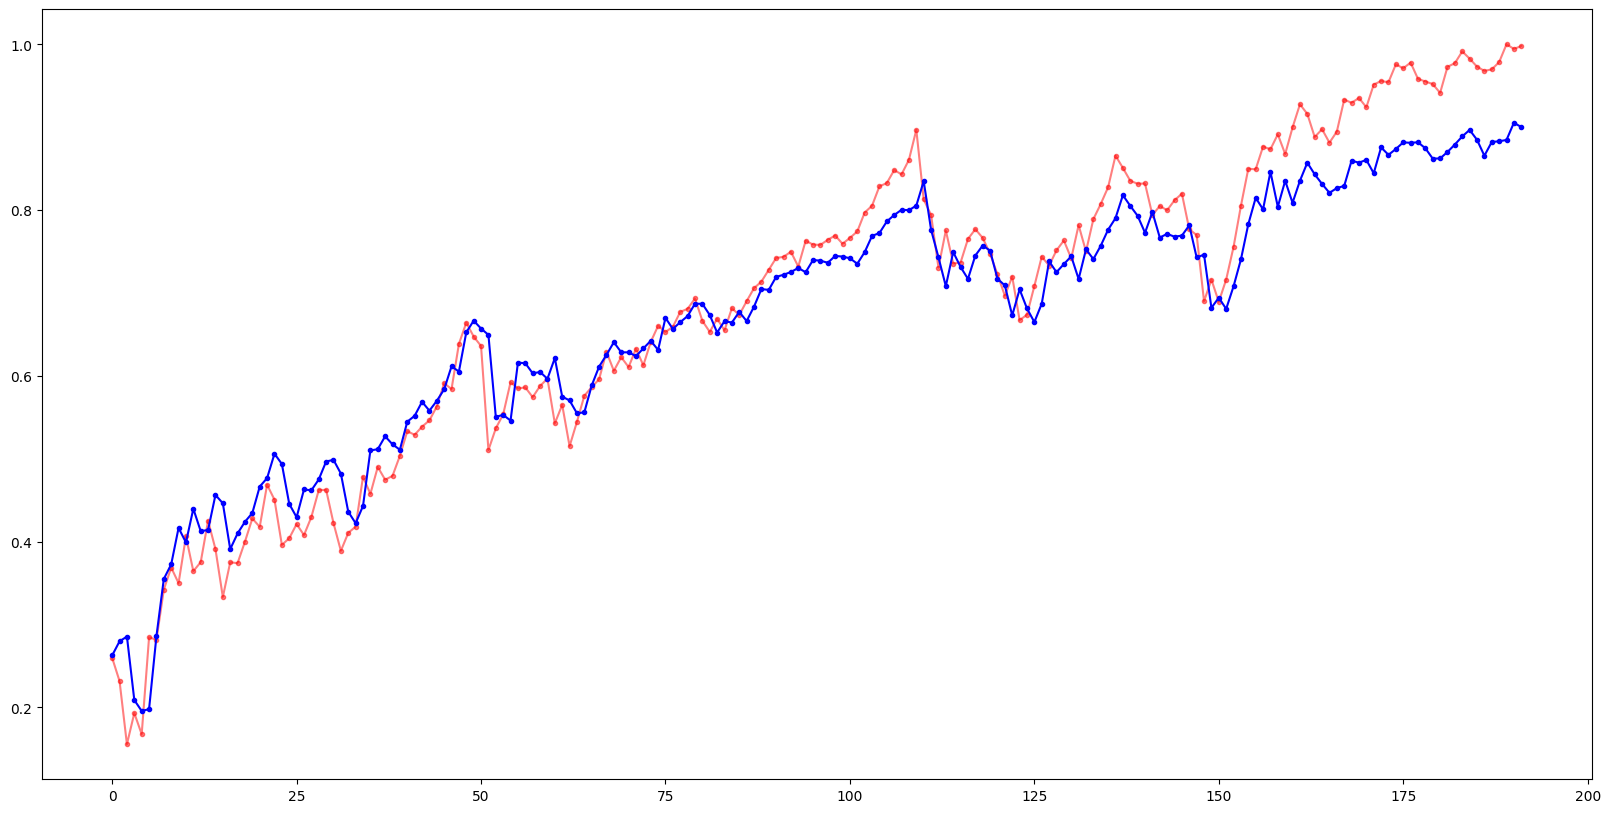

R2 Score: 0.9313449693944769
MAE: 0.04069501823595384
RMSE: 0.051700547769565335
Model 4: 200,100,100
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 6, 200)            164000    
                                                                 
 lstm_33 (LSTM)              (None, 100)               120400    
                                                                 
 dense_16 (Dense)            (None, 1)                 101       
                                                                 
Total params: 284501 (1.09 MB)
Trainable params: 284501 (1.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
start: 0
Epoch 1/50
98/98 [==============================] - 7s 33ms/step - loss: 0.0022 - val_loss: 0.0502
Epoch 2/50
98/98 [==============================] - 2s 24ms/step - loss

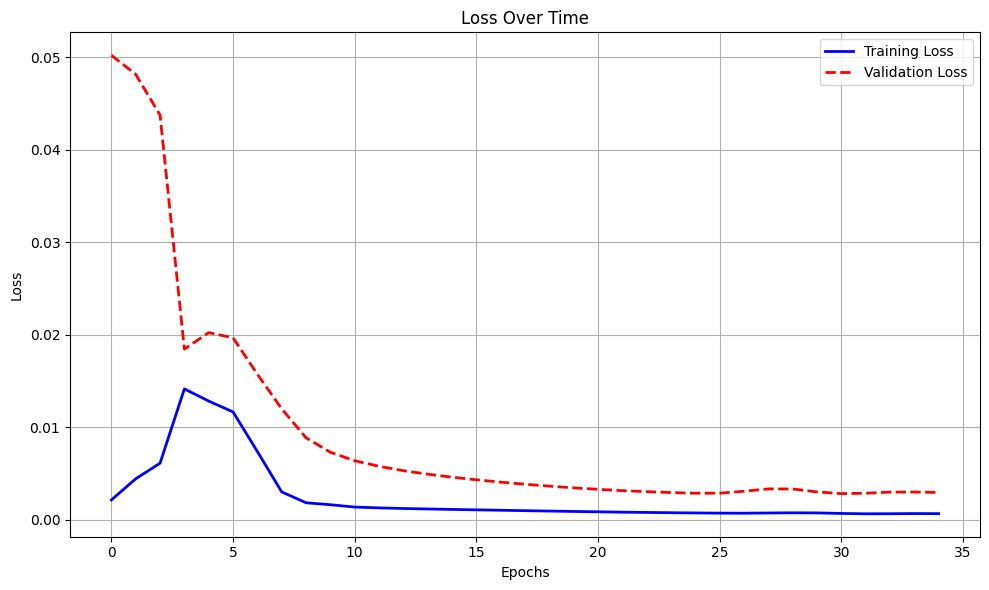

6/6 [==============================] - 1s 11ms/step


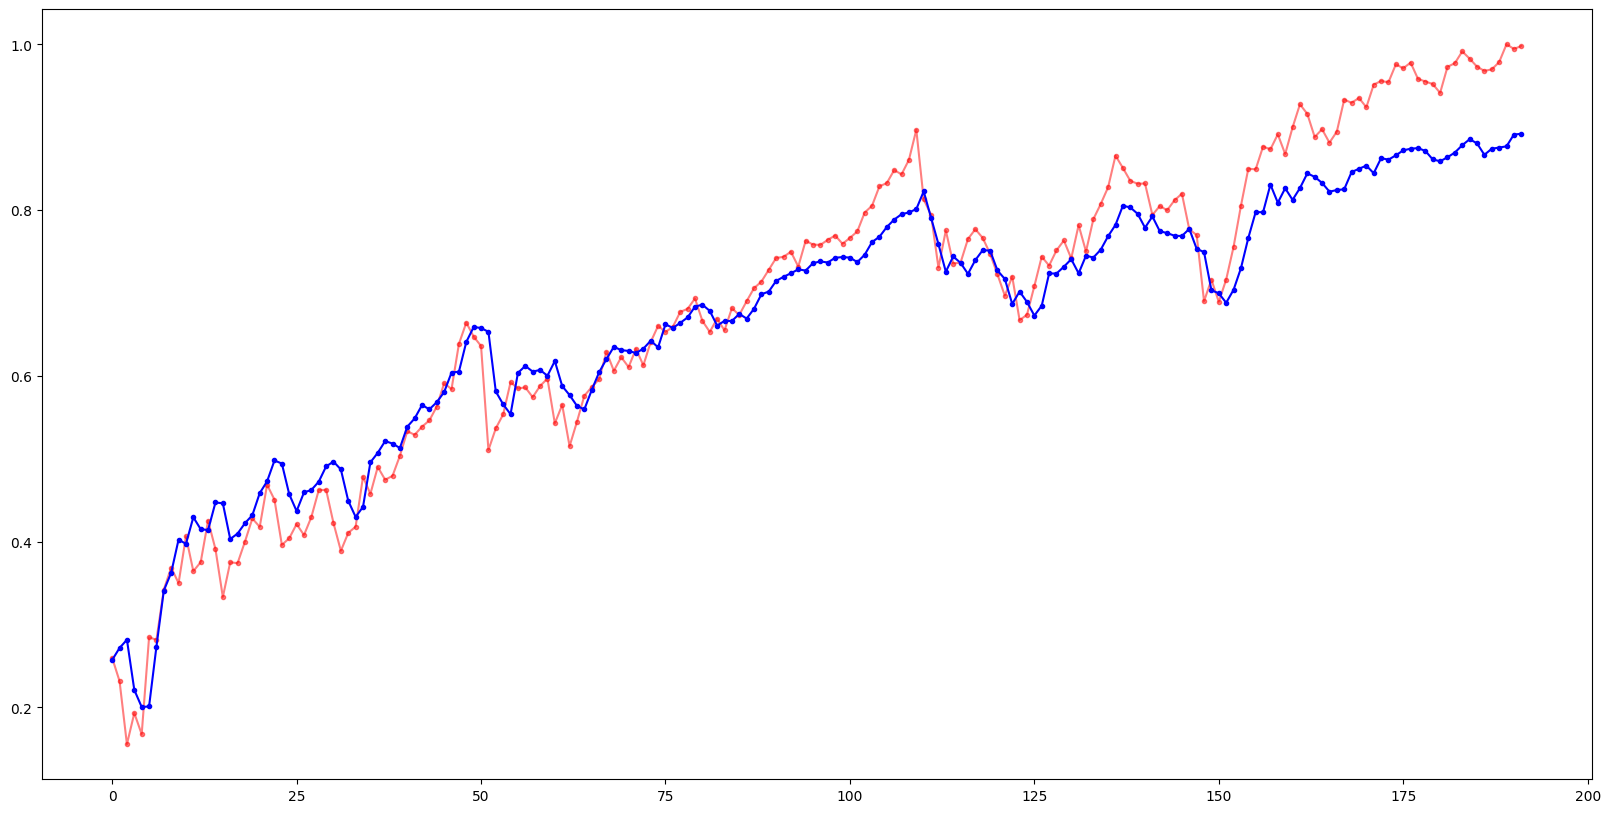

R2 Score: 0.9260062457476166
MAE: 0.042029431614247374
RMSE: 0.05367307698762338
Model 7: 120,105,105
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 6, 120)            60000     
                                                                 
 lstm_35 (LSTM)              (None, 105)               94920     
                                                                 
 dense_17 (Dense)            (None, 1)                 106       
                                                                 
Total params: 155026 (605.57 KB)
Trainable params: 155026 (605.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
start: 0
Epoch 1/50
98/98 [==============================] - 7s 24ms/step - loss: 0.0023 - val_loss: 0.0355
Epoch 2/50
98/98 [==============================] - 1s 15ms/step - 

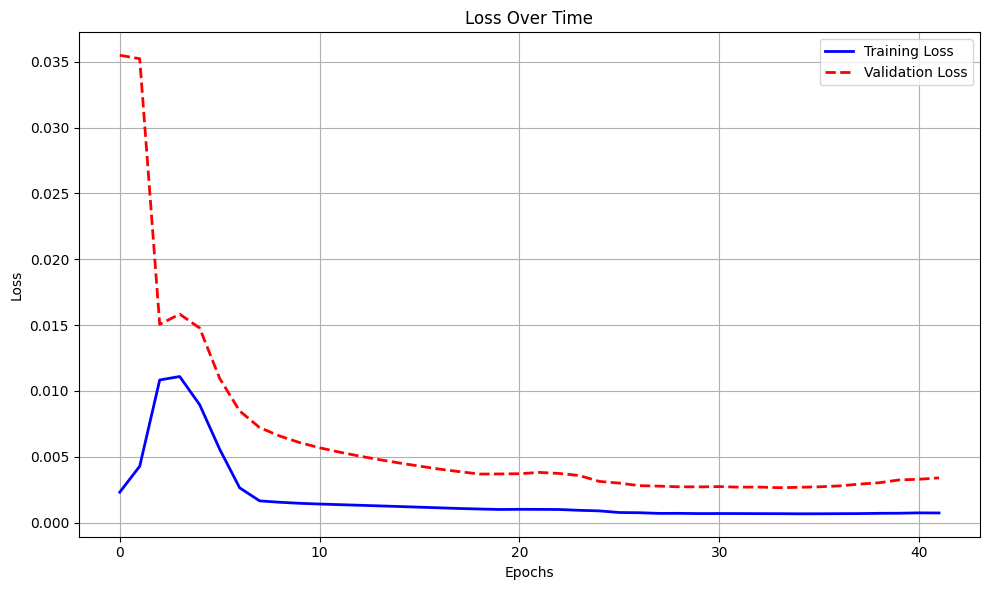

6/6 [==============================] - 1s 8ms/step


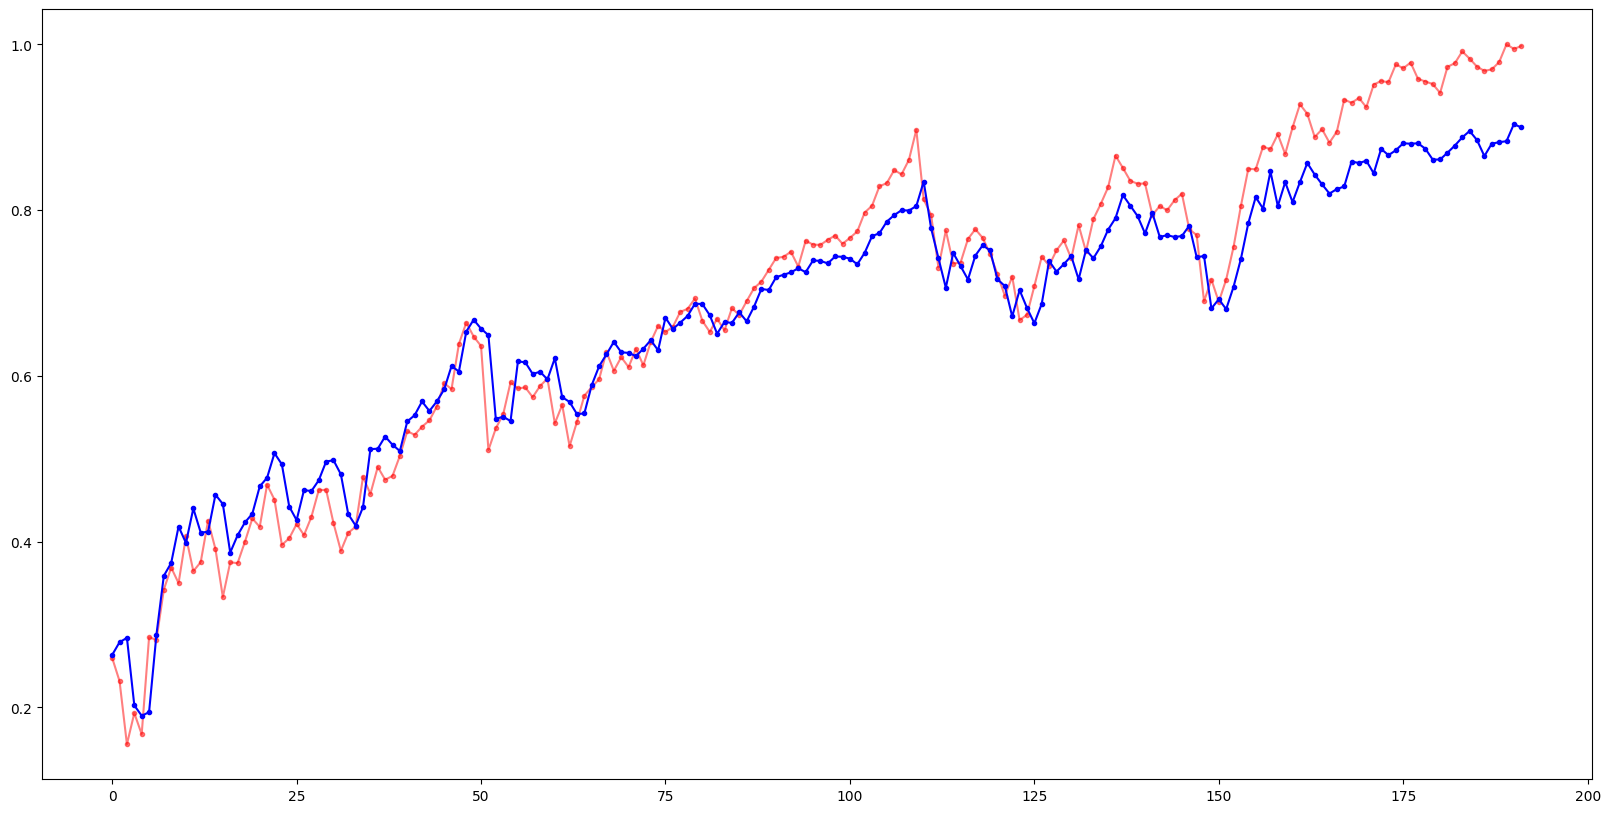

R2 Score: 0.930709453080022
MAE: 0.04075781669627845
RMSE: 0.051939283778535586
Model 1: 120,100,100
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 7, 120)            60000     
                                                                 
 lstm_37 (LSTM)              (None, 100)               88400     
                                                                 
 dense_18 (Dense)            (None, 1)                 101       
                                                                 
Total params: 148501 (580.08 KB)
Trainable params: 148501 (580.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
start: 0
Epoch 1/50
98/98 [==============================] - 7s 25ms/step - loss: 0.0024 - val_loss: 0.0418
Epoch 2/50
98/98 [==============================] - 1s 15ms/step - l

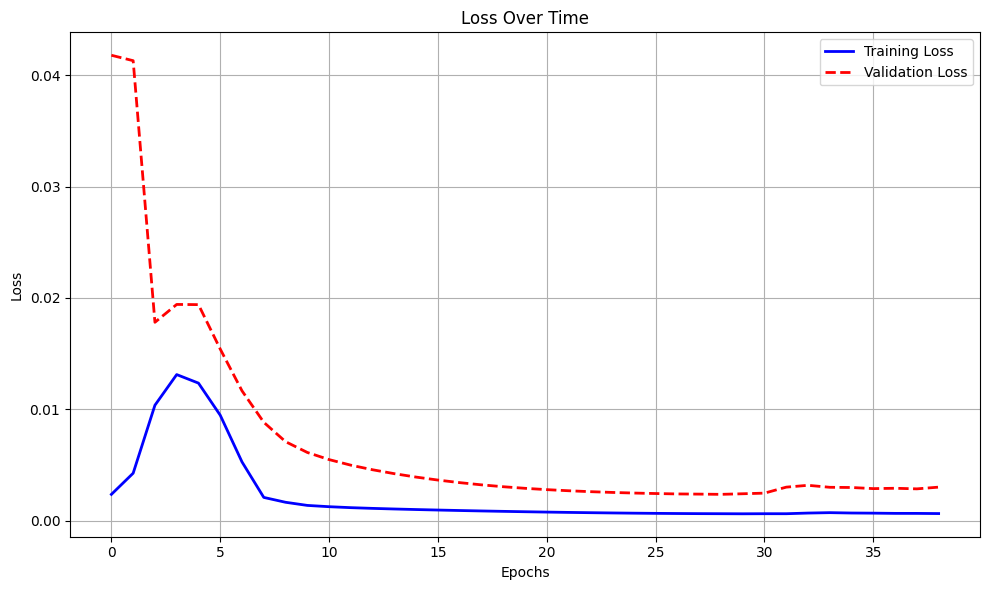

6/6 [==============================] - 1s 8ms/step


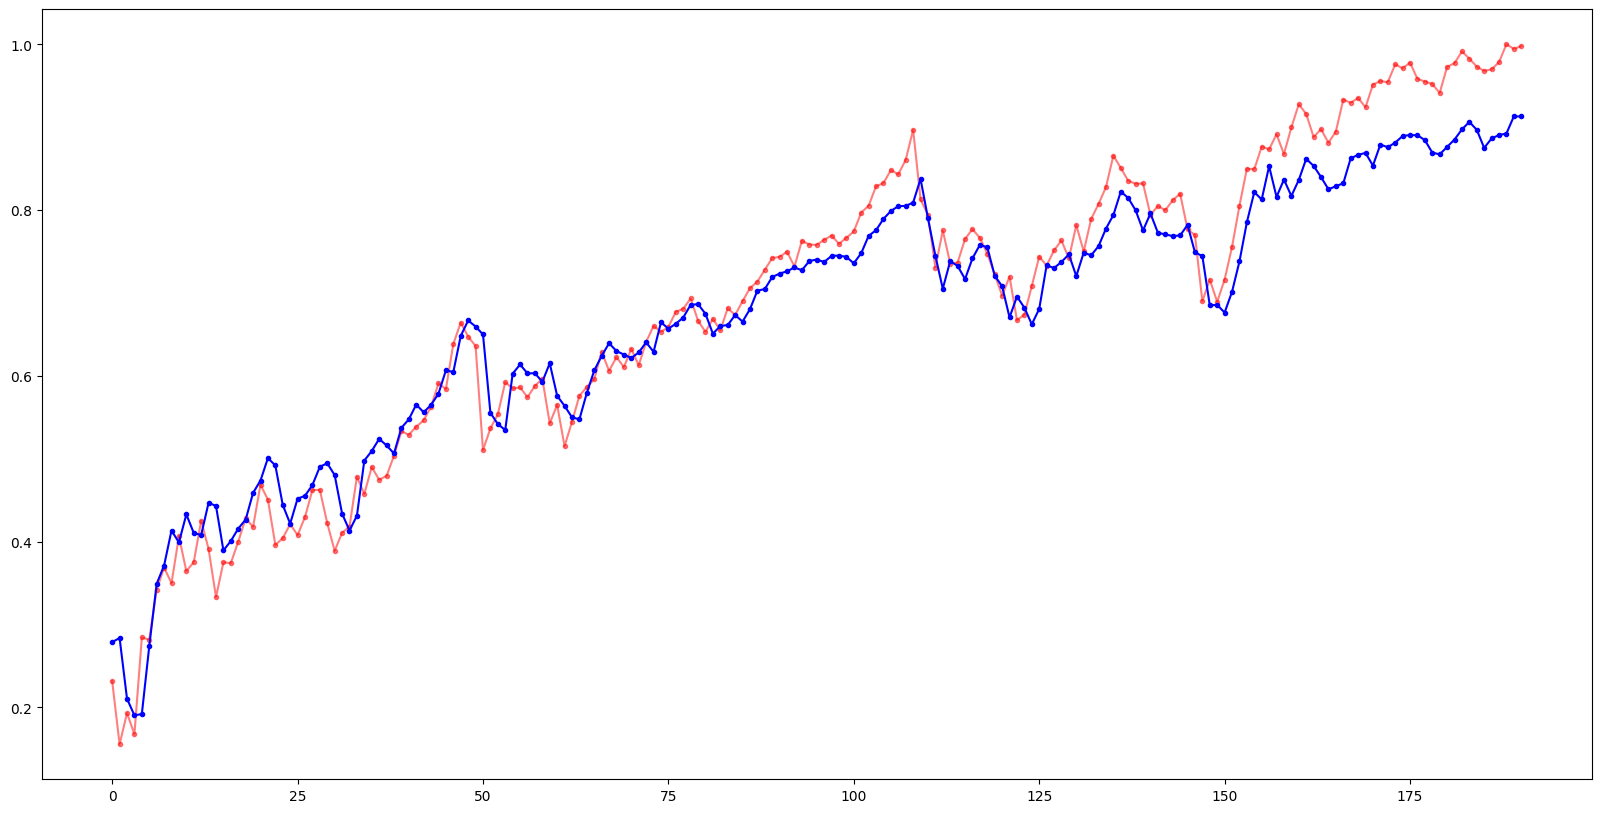

R2 Score: 0.9377132949136732
MAE: 0.038252986038273366
RMSE: 0.04877417590404687
Model 4: 200,100,100
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_38 (LSTM)              (None, 7, 200)            164000    
                                                                 
 lstm_39 (LSTM)              (None, 100)               120400    
                                                                 
 dense_19 (Dense)            (None, 1)                 101       
                                                                 
Total params: 284501 (1.09 MB)
Trainable params: 284501 (1.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
start: 0
Epoch 1/50
98/98 [==============================] - 9s 44ms/step - loss: 0.0022 - val_loss: 0.0752
Epoch 2/50
98/98 [==============================] - 3s 34ms/step - loss

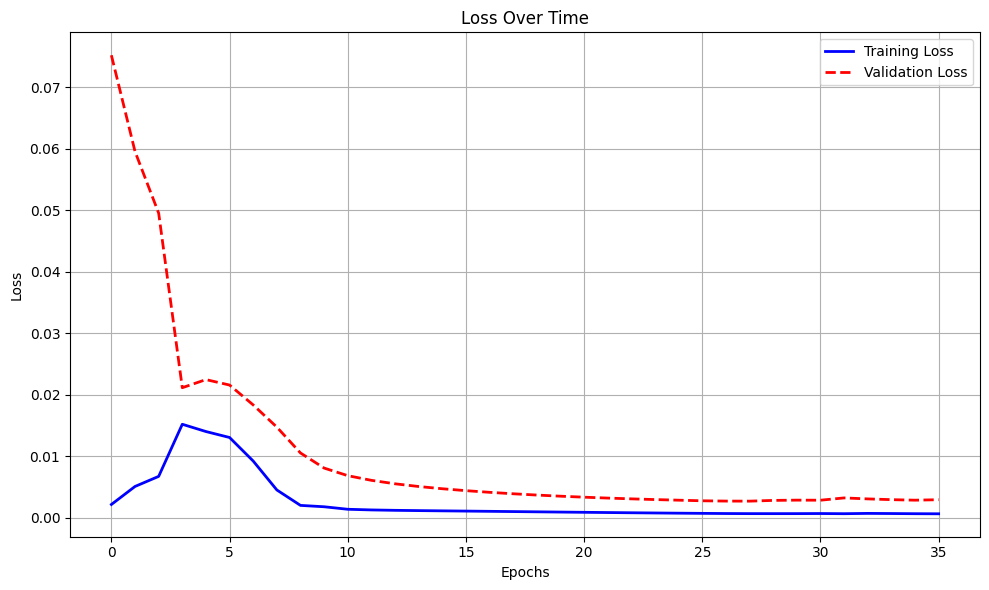

6/6 [==============================] - 1s 12ms/step


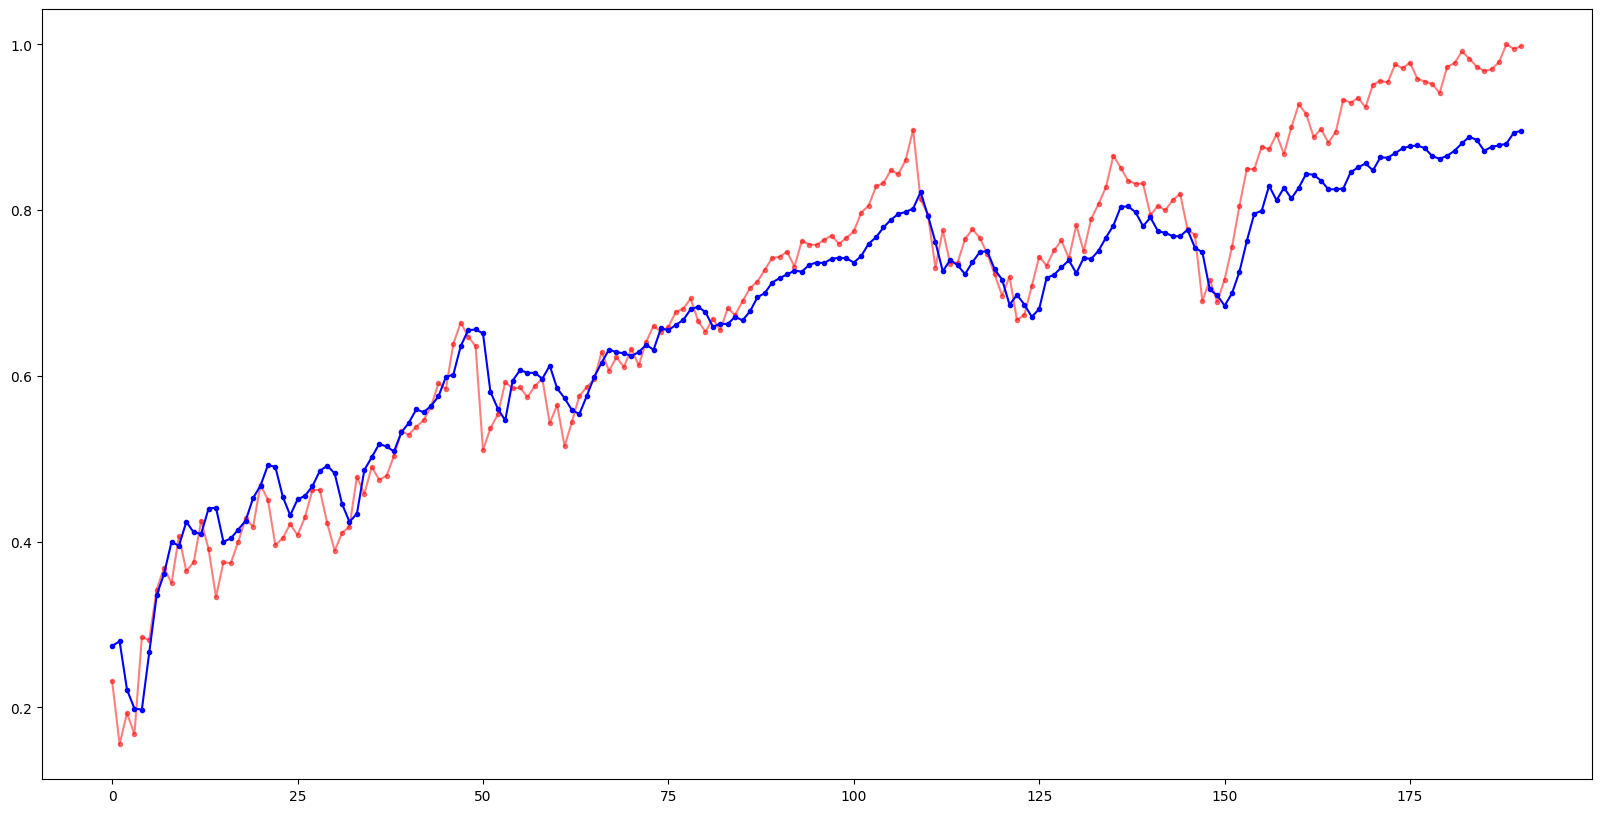

R2 Score: 0.9271920501181331
MAE: 0.041300264652607624
RMSE: 0.052732900844372155
Model 7: 120,105,105
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 7, 120)            60000     
                                                                 
 lstm_41 (LSTM)              (None, 105)               94920     
                                                                 
 dense_20 (Dense)            (None, 1)                 106       
                                                                 
Total params: 155026 (605.57 KB)
Trainable params: 155026 (605.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
start: 0
Epoch 1/50
98/98 [==============================] - 7s 26ms/step - loss: 0.0024 - val_loss: 0.0421
Epoch 2/50
98/98 [==============================] - 2s 16ms/step -

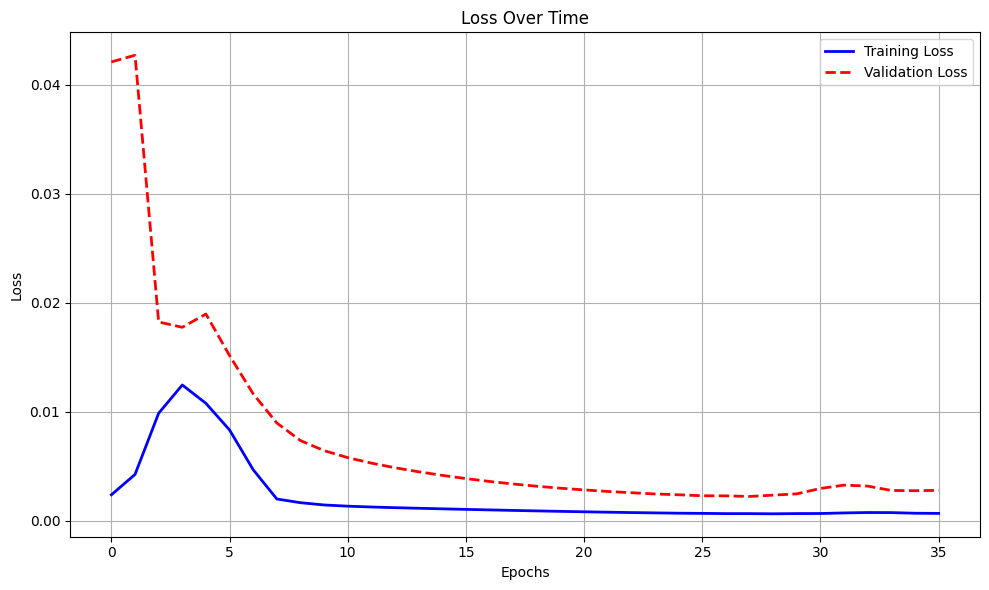

6/6 [==============================] - 1s 9ms/step


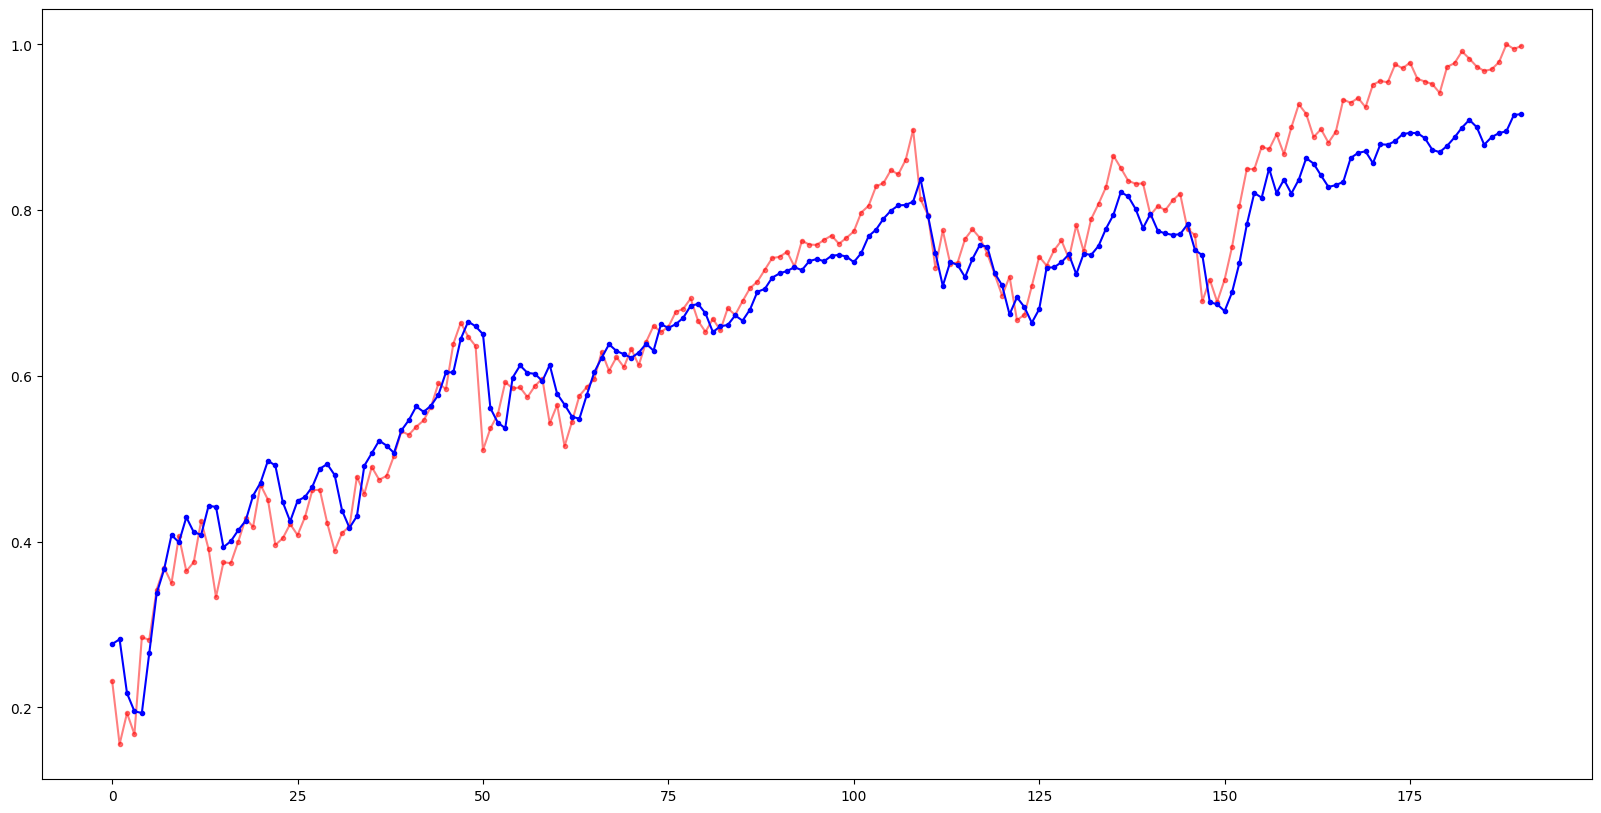

R2 Score: 0.9402238208123969
MAE: 0.03754036087071777
RMSE: 0.0477811213127302
Model 1: 120,100,100
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_42 (LSTM)              (None, 8, 120)            60000     
                                                                 
 lstm_43 (LSTM)              (None, 100)               88400     
                                                                 
 dense_21 (Dense)            (None, 1)                 101       
                                                                 
Total params: 148501 (580.08 KB)
Trainable params: 148501 (580.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
start: 0
Epoch 1/50
98/98 [==============================] - 7s 27ms/step - loss: 0.0025 - val_loss: 0.0518
Epoch 2/50
98/98 [==============================] - 2s 17ms/step - lo

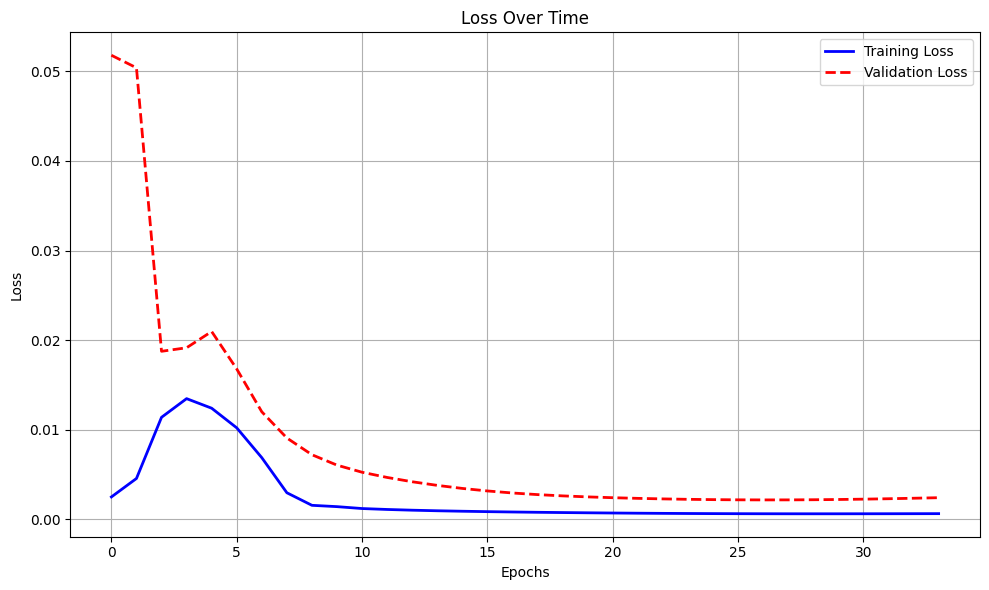

6/6 [==============================] - 1s 12ms/step


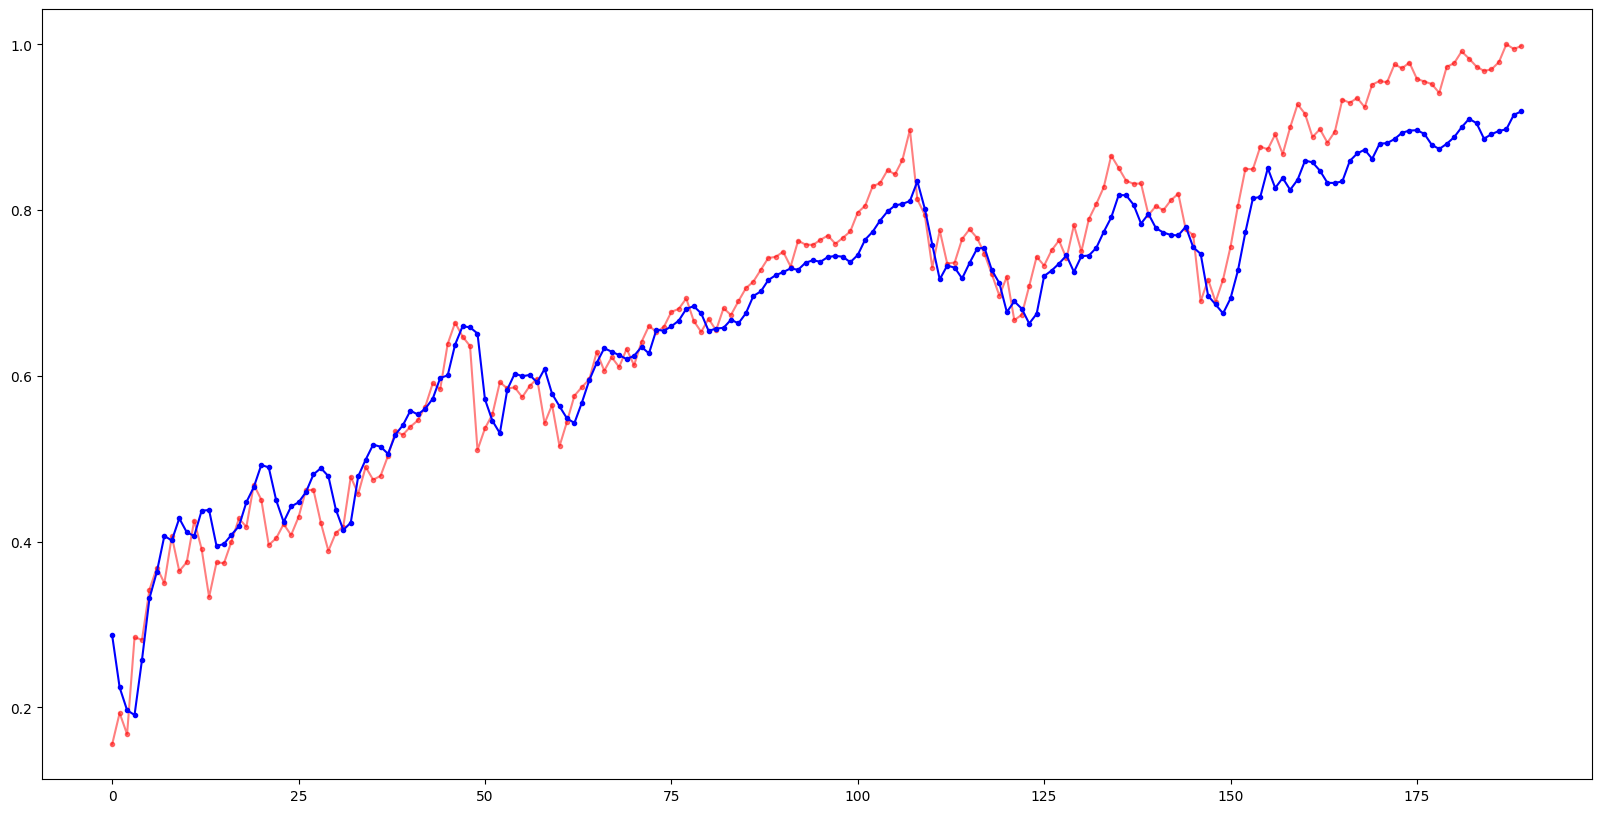

R2 Score: 0.9399226273219989
MAE: 0.03733825333997919
RMSE: 0.04734098239002104
Model 4: 200,100,100
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_44 (LSTM)              (None, 8, 200)            164000    
                                                                 
 lstm_45 (LSTM)              (None, 100)               120400    
                                                                 
 dense_22 (Dense)            (None, 1)                 101       
                                                                 
Total params: 284501 (1.09 MB)
Trainable params: 284501 (1.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
start: 0
Epoch 1/50
98/98 [==============================] - 9s 49ms/step - loss: 0.0023 - val_loss: 0.0844
Epoch 2/50
98/98 [==============================] - 4s 40ms/step - loss:

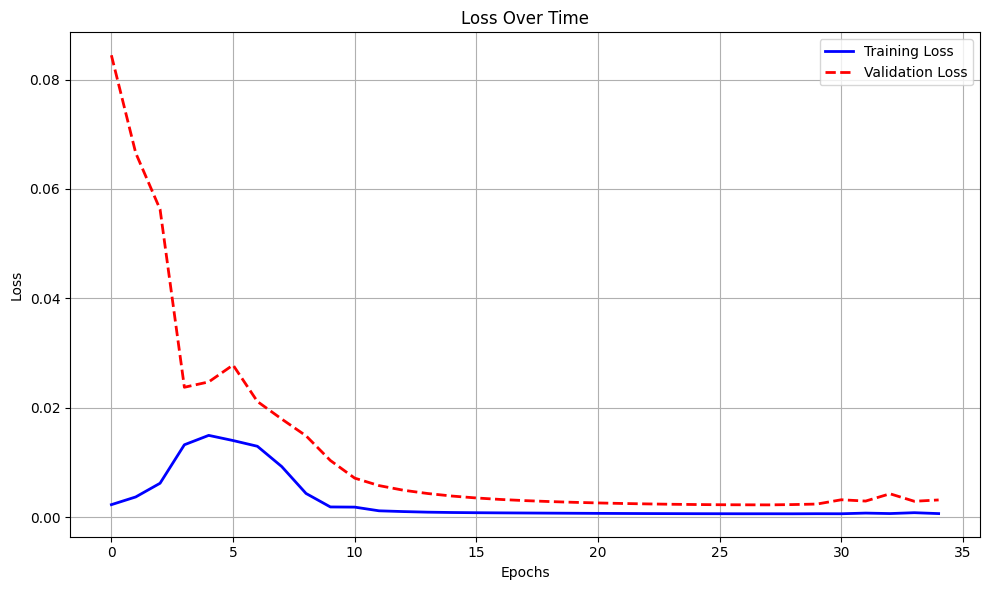

6/6 [==============================] - 1s 14ms/step


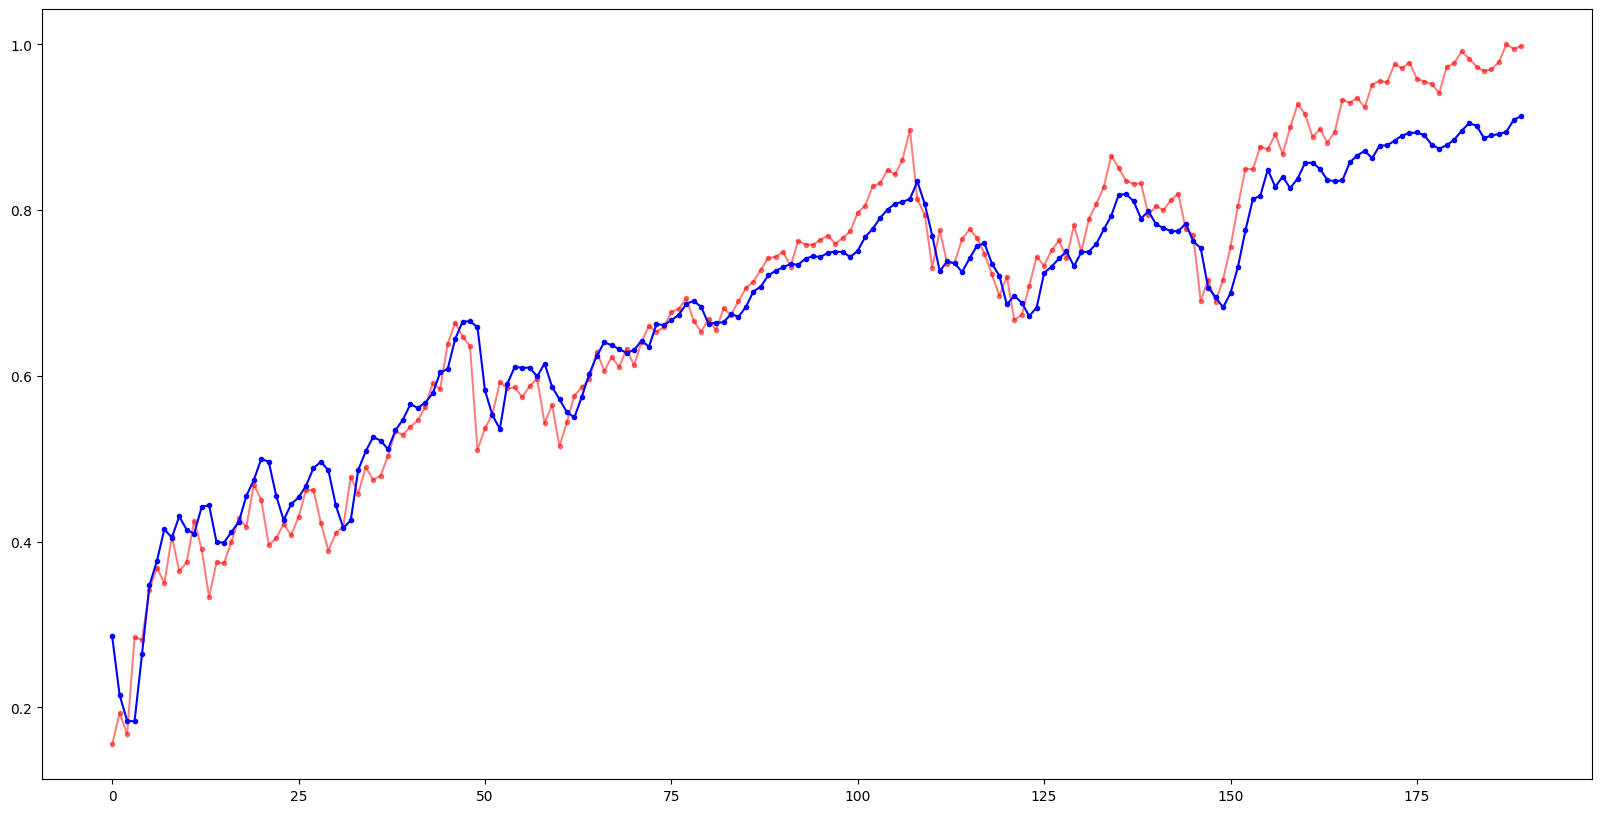

R2 Score: 0.9385720473667608
MAE: 0.037389680761580266
RMSE: 0.04787015353337239
Model 7: 120,105,105
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_46 (LSTM)              (None, 8, 120)            60000     
                                                                 
 lstm_47 (LSTM)              (None, 105)               94920     
                                                                 
 dense_23 (Dense)            (None, 1)                 106       
                                                                 
Total params: 155026 (605.57 KB)
Trainable params: 155026 (605.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
start: 0
Epoch 1/50
98/98 [==============================] - 7s 28ms/step - loss: 0.0023 - val_loss: 0.0677
Epoch 2/50
98/98 [==============================] - 2s 19ms/step - 

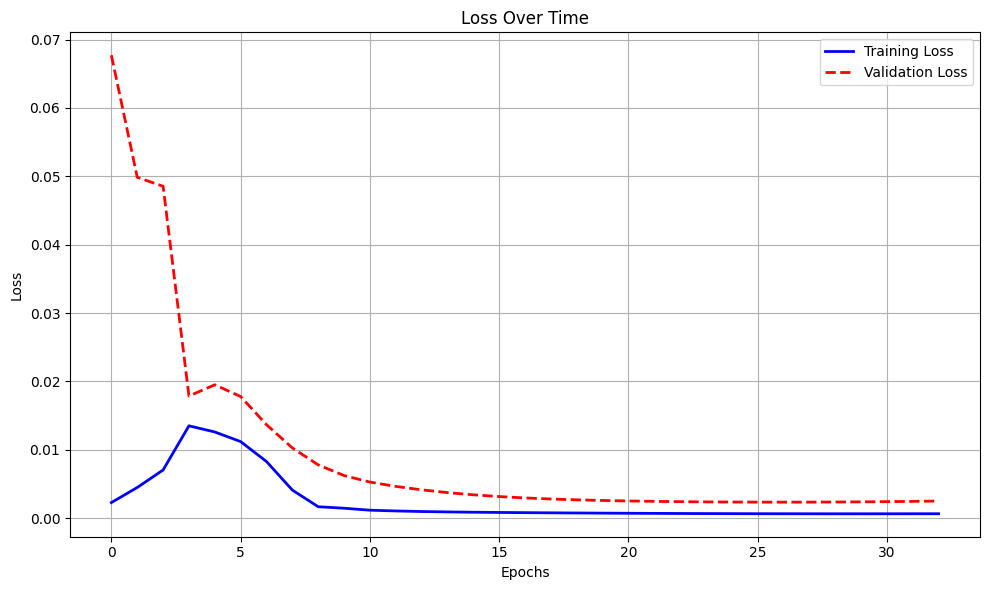

6/6 [==============================] - 1s 11ms/step


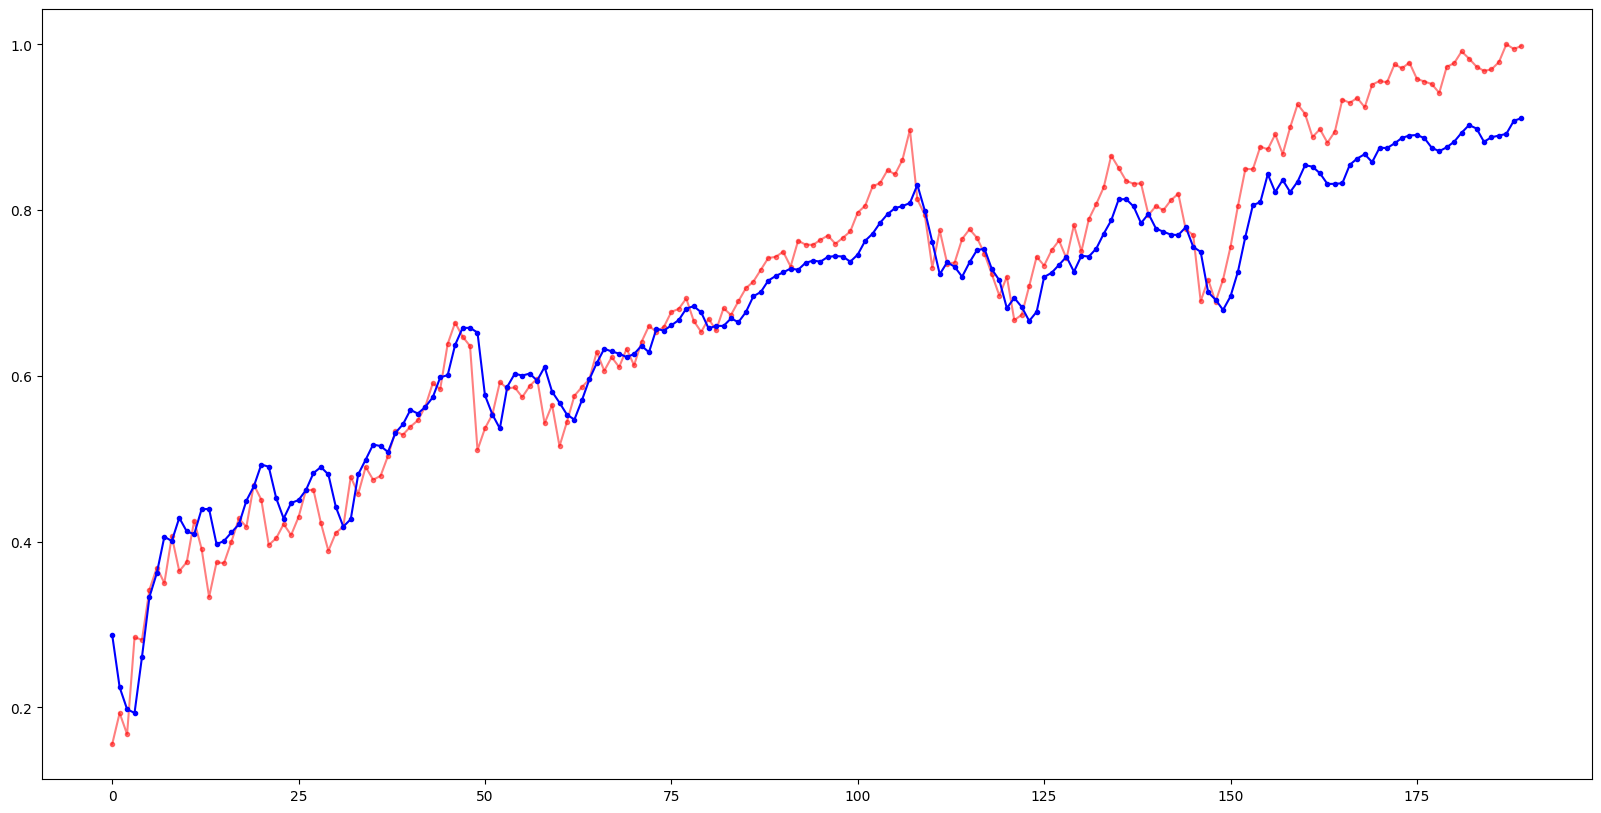

R2 Score: 0.9355635712862637
MAE: 0.03847945440060436
RMSE: 0.049028378613038326
Model 1: 120,100,100
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 9, 120)            60000     
                                                                 
 lstm_49 (LSTM)              (None, 100)               88400     
                                                                 
 dense_24 (Dense)            (None, 1)                 101       
                                                                 
Total params: 148501 (580.08 KB)
Trainable params: 148501 (580.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
start: 0
Epoch 1/50
98/98 [==============================] - 8s 31ms/step - loss: 0.0026 - val_loss: 0.0542
Epoch 2/50
98/98 [==============================] - 2s 22ms/step - 

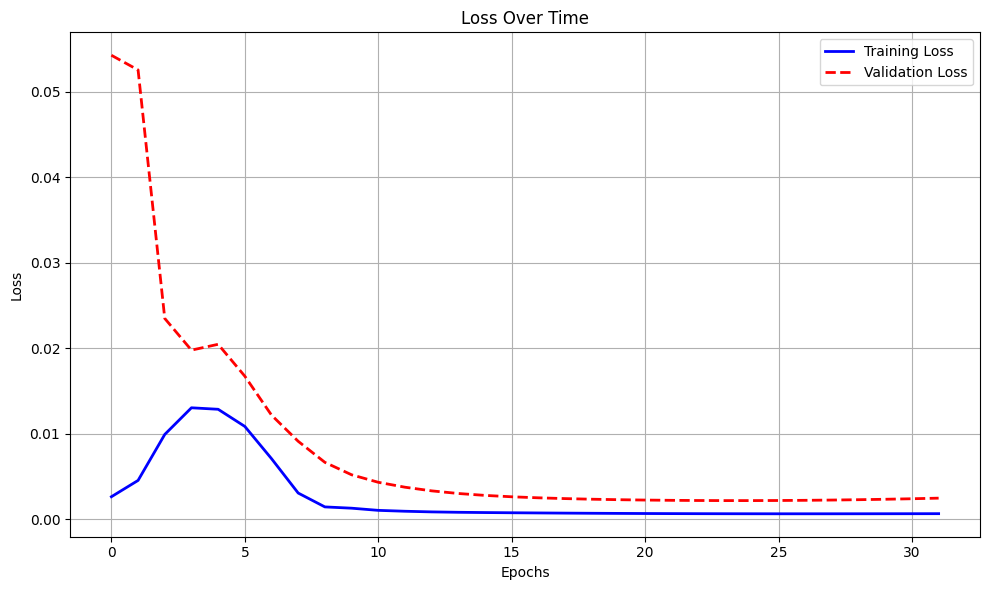

6/6 [==============================] - 1s 13ms/step


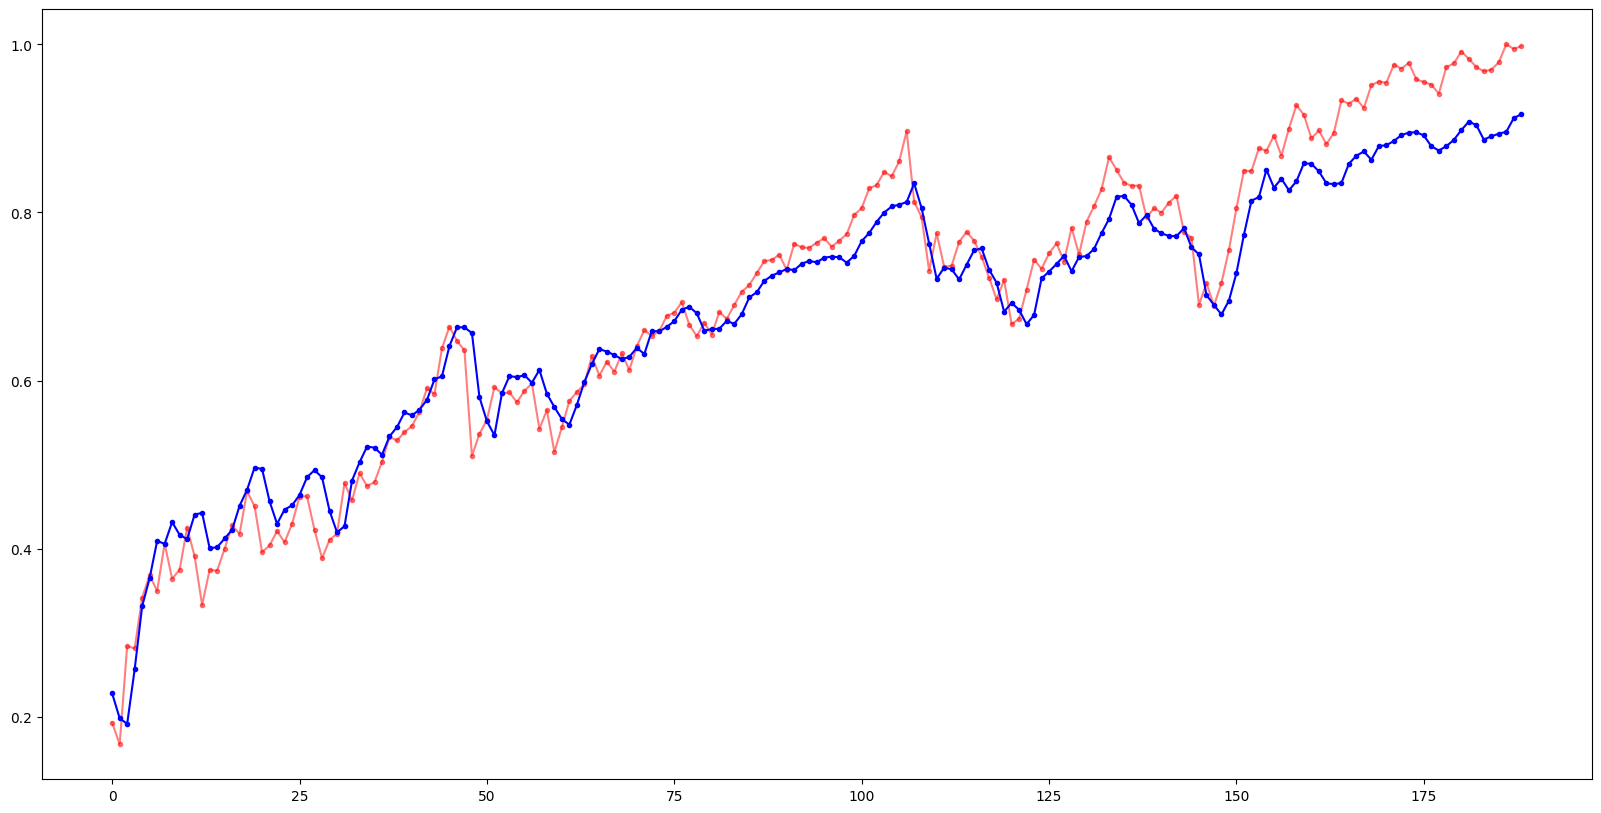

R2 Score: 0.9390532008807951
MAE: 0.03693966870783001
RMSE: 0.04683774935393367
Model 4: 200,100,100
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_50 (LSTM)              (None, 9, 200)            164000    
                                                                 
 lstm_51 (LSTM)              (None, 100)               120400    
                                                                 
 dense_25 (Dense)            (None, 1)                 101       
                                                                 
Total params: 284501 (1.09 MB)
Trainable params: 284501 (1.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
start: 0
Epoch 1/50
98/98 [==============================] - 10s 55ms/step - loss: 0.0025 - val_loss: 0.0805
Epoch 2/50
98/98 [==============================] - 4s 44ms/step - loss

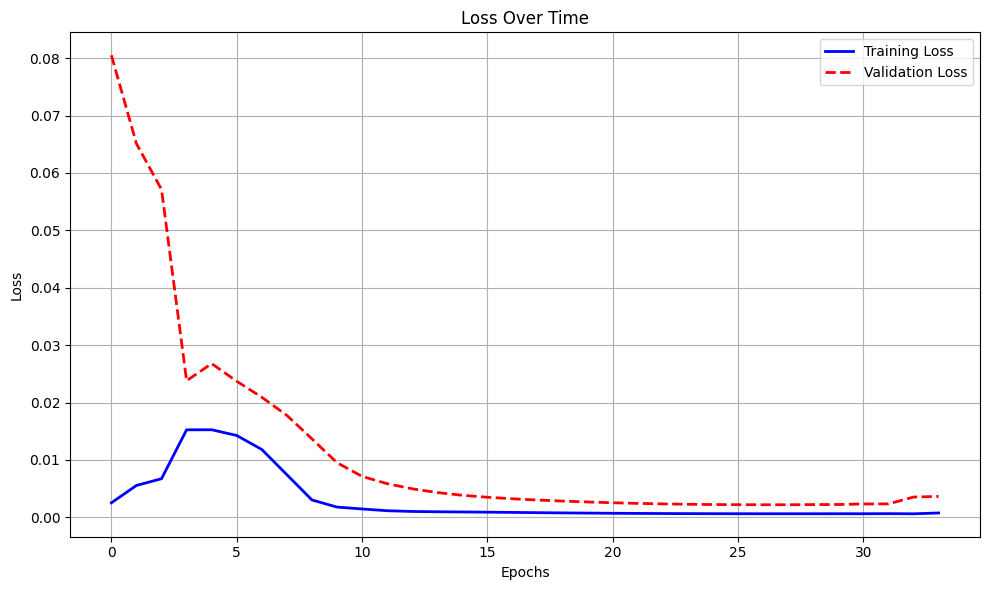

6/6 [==============================] - 1s 15ms/step


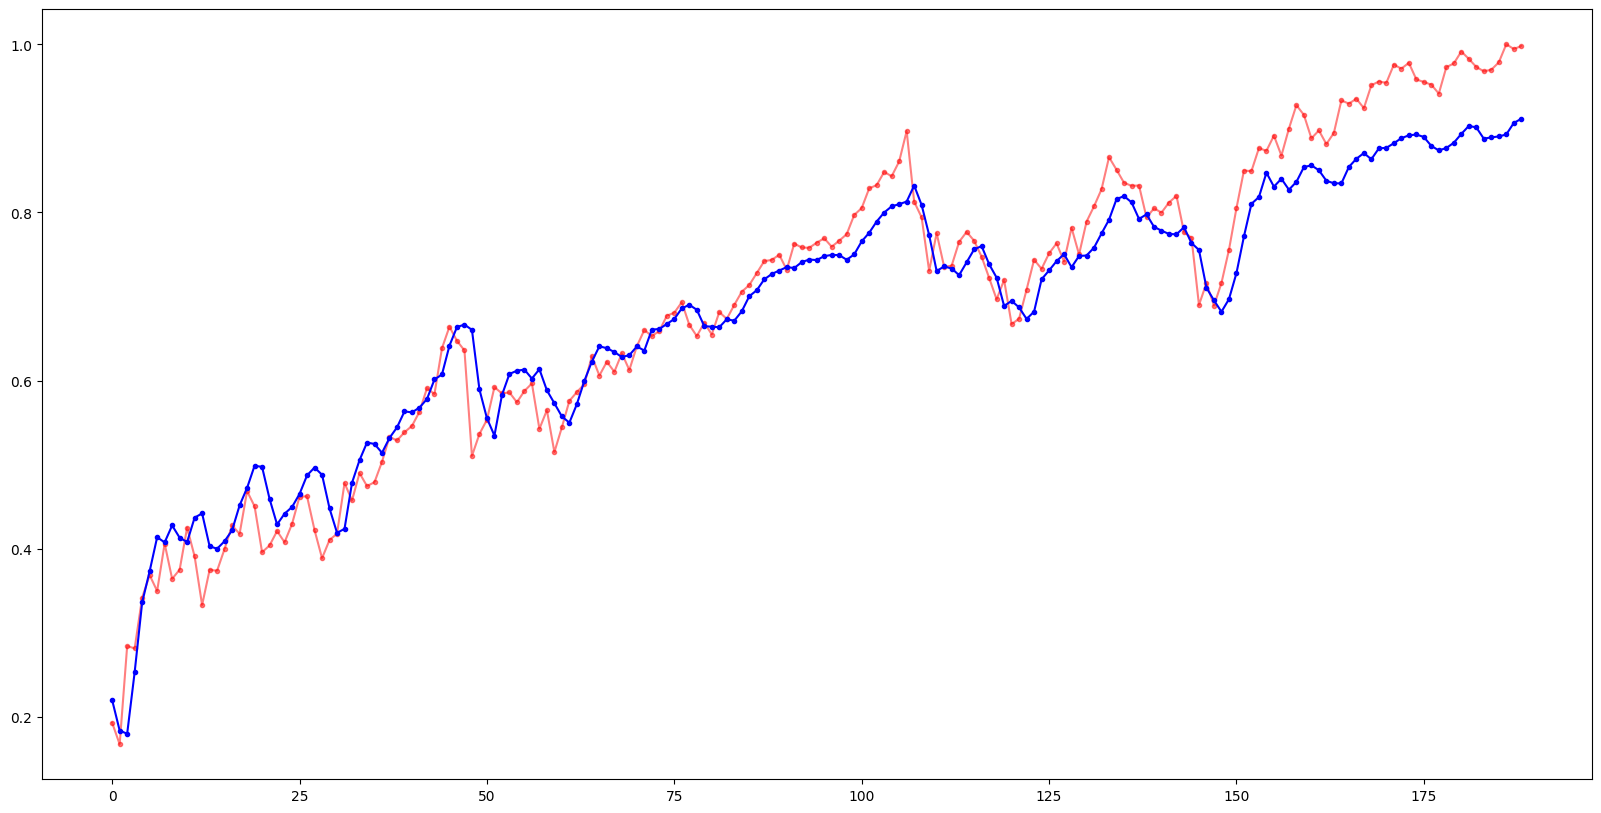

R2 Score: 0.9369728173254783
MAE: 0.03730111842814831
RMSE: 0.047630431351558804
Model 7: 120,105,105
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_52 (LSTM)              (None, 9, 120)            60000     
                                                                 
 lstm_53 (LSTM)              (None, 105)               94920     
                                                                 
 dense_26 (Dense)            (None, 1)                 106       
                                                                 
Total params: 155026 (605.57 KB)
Trainable params: 155026 (605.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
start: 0
Epoch 1/50
98/98 [==============================] - 7s 30ms/step - loss: 0.0027 - val_loss: 0.0519
Epoch 2/50
98/98 [==============================] - 2s 21ms/step - 

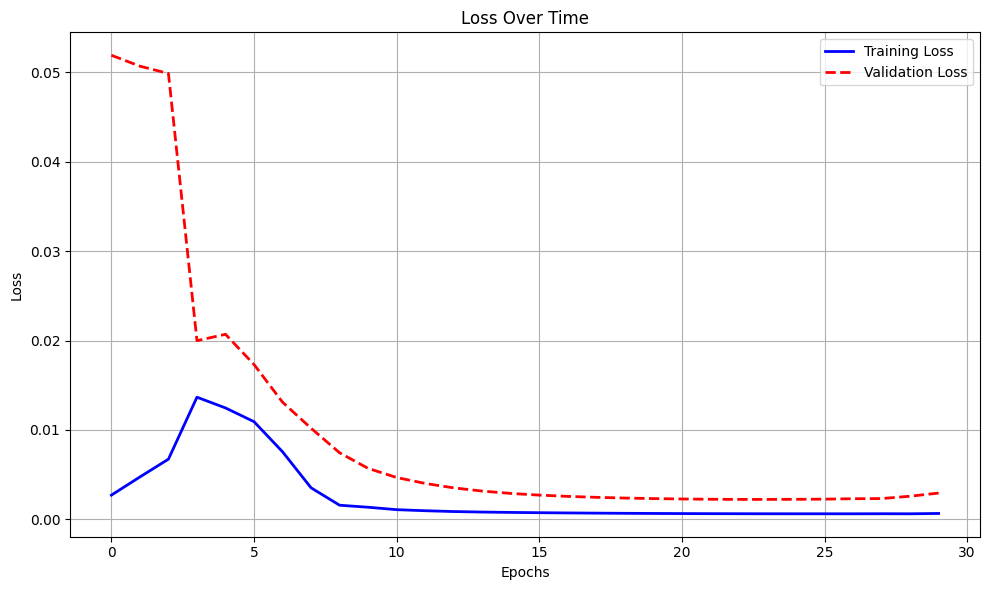

6/6 [==============================] - 2s 13ms/step


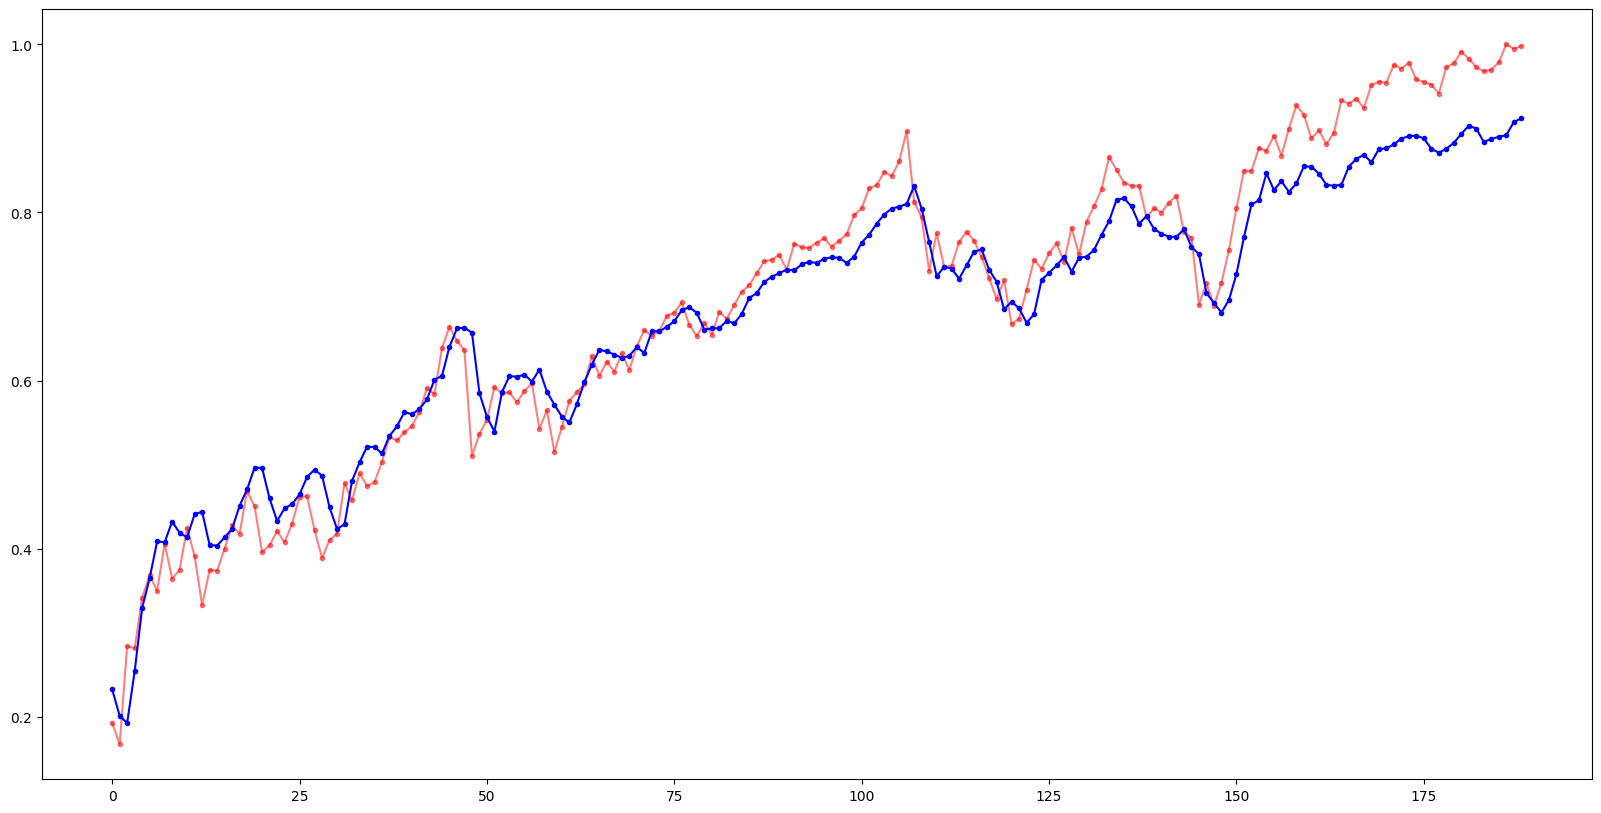

R2 Score: 0.9353203103062523
MAE: 0.03811304161024689
RMSE: 0.048250801423488095
Model 1: 120,100,100
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_54 (LSTM)              (None, 10, 120)           60000     
                                                                 
 lstm_55 (LSTM)              (None, 100)               88400     
                                                                 
 dense_27 (Dense)            (None, 1)                 101       
                                                                 
Total params: 148501 (580.08 KB)
Trainable params: 148501 (580.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
start: 0
Epoch 1/50
98/98 [==============================] - 7s 33ms/step - loss: 0.0029 - val_loss: 0.0590
Epoch 2/50
98/98 [==============================] - 2s 23ms/step - 

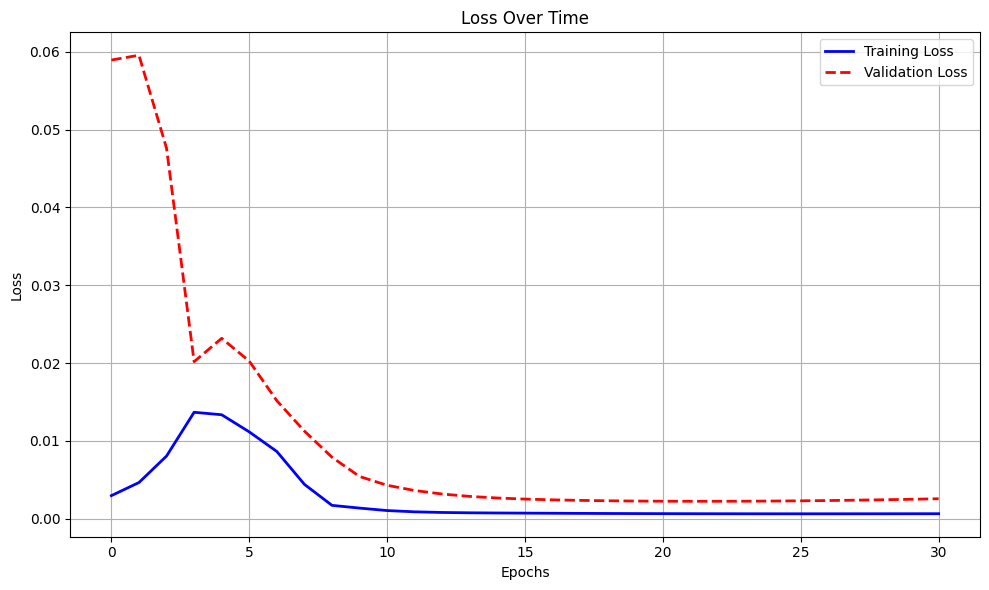

6/6 [==============================] - 1s 13ms/step


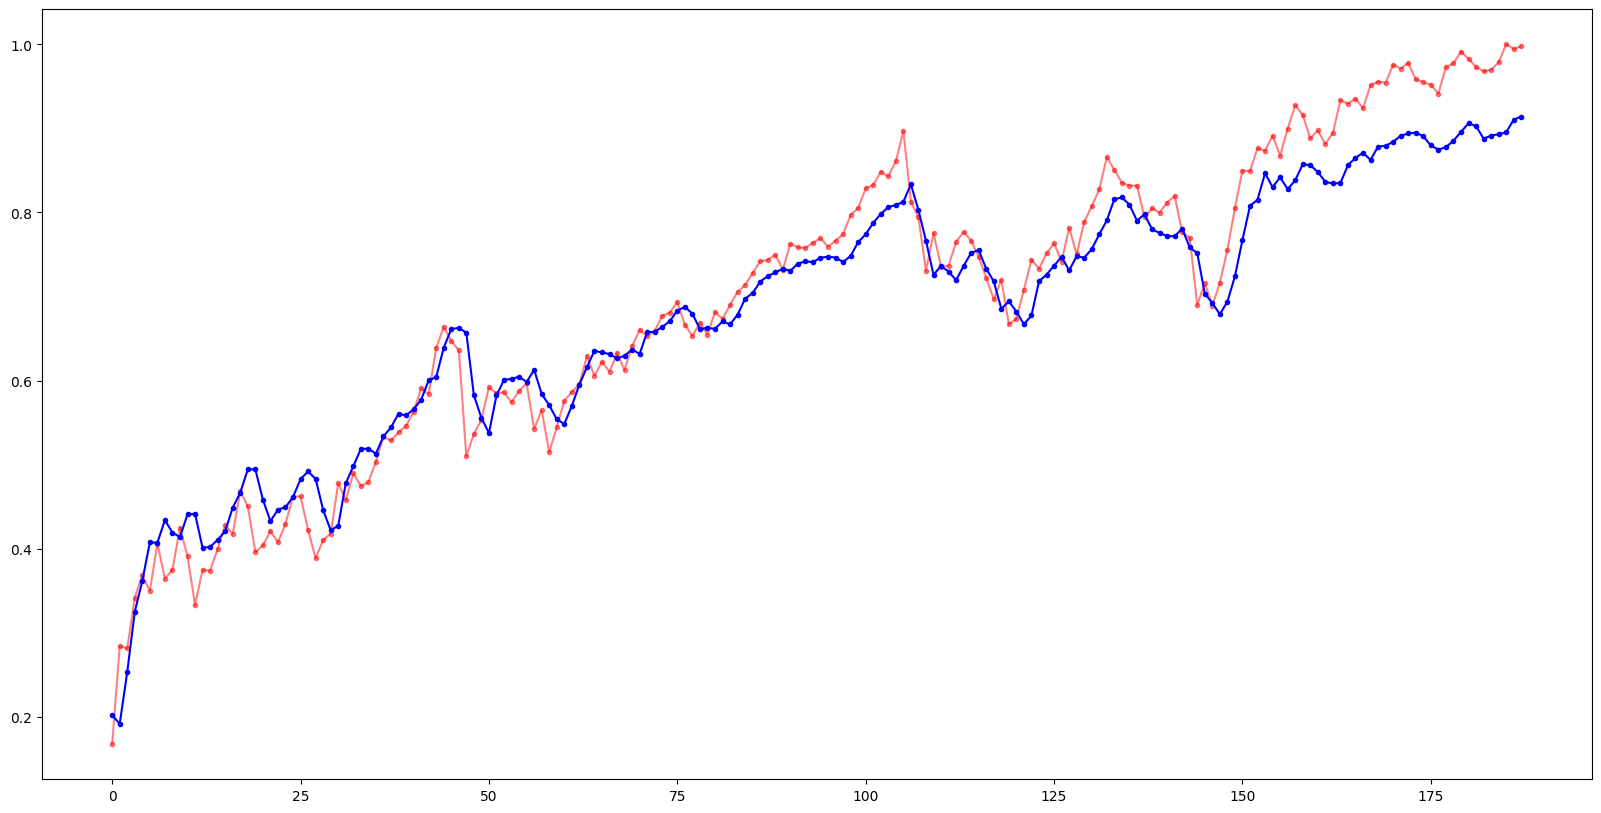

R2 Score: 0.9359653361742365
MAE: 0.037316402283729705
RMSE: 0.04724868980416914
Model 4: 200,100,100
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_56 (LSTM)              (None, 10, 200)           164000    
                                                                 
 lstm_57 (LSTM)              (None, 100)               120400    
                                                                 
 dense_28 (Dense)            (None, 1)                 101       
                                                                 
Total params: 284501 (1.09 MB)
Trainable params: 284501 (1.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
start: 0
Epoch 1/50
98/98 [==============================] - 10s 61ms/step - loss: 0.0029 - val_loss: 0.0883
Epoch 2/50
98/98 [==============================] - 5s 50ms/step - los

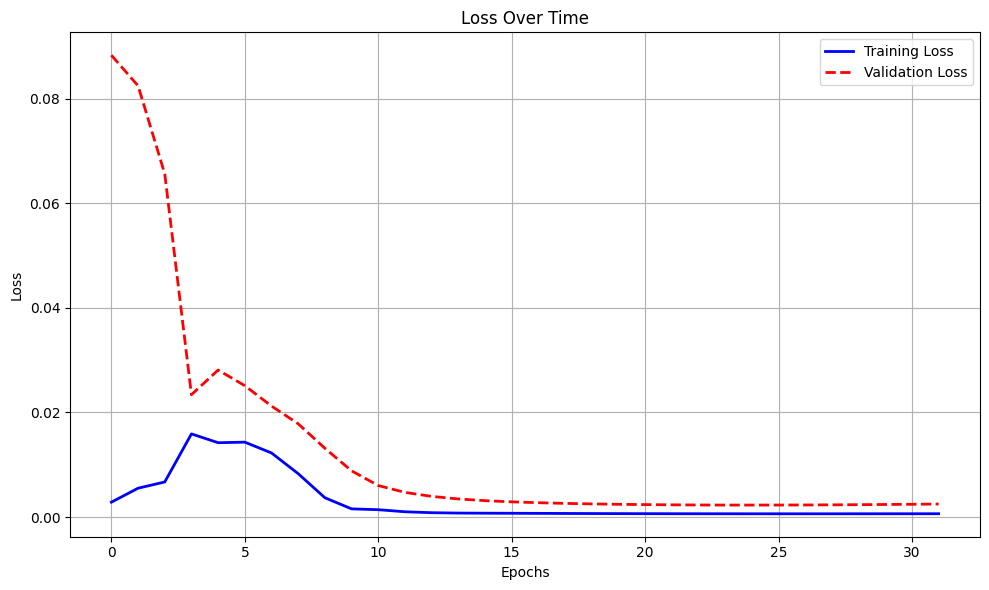

6/6 [==============================] - 1s 18ms/step


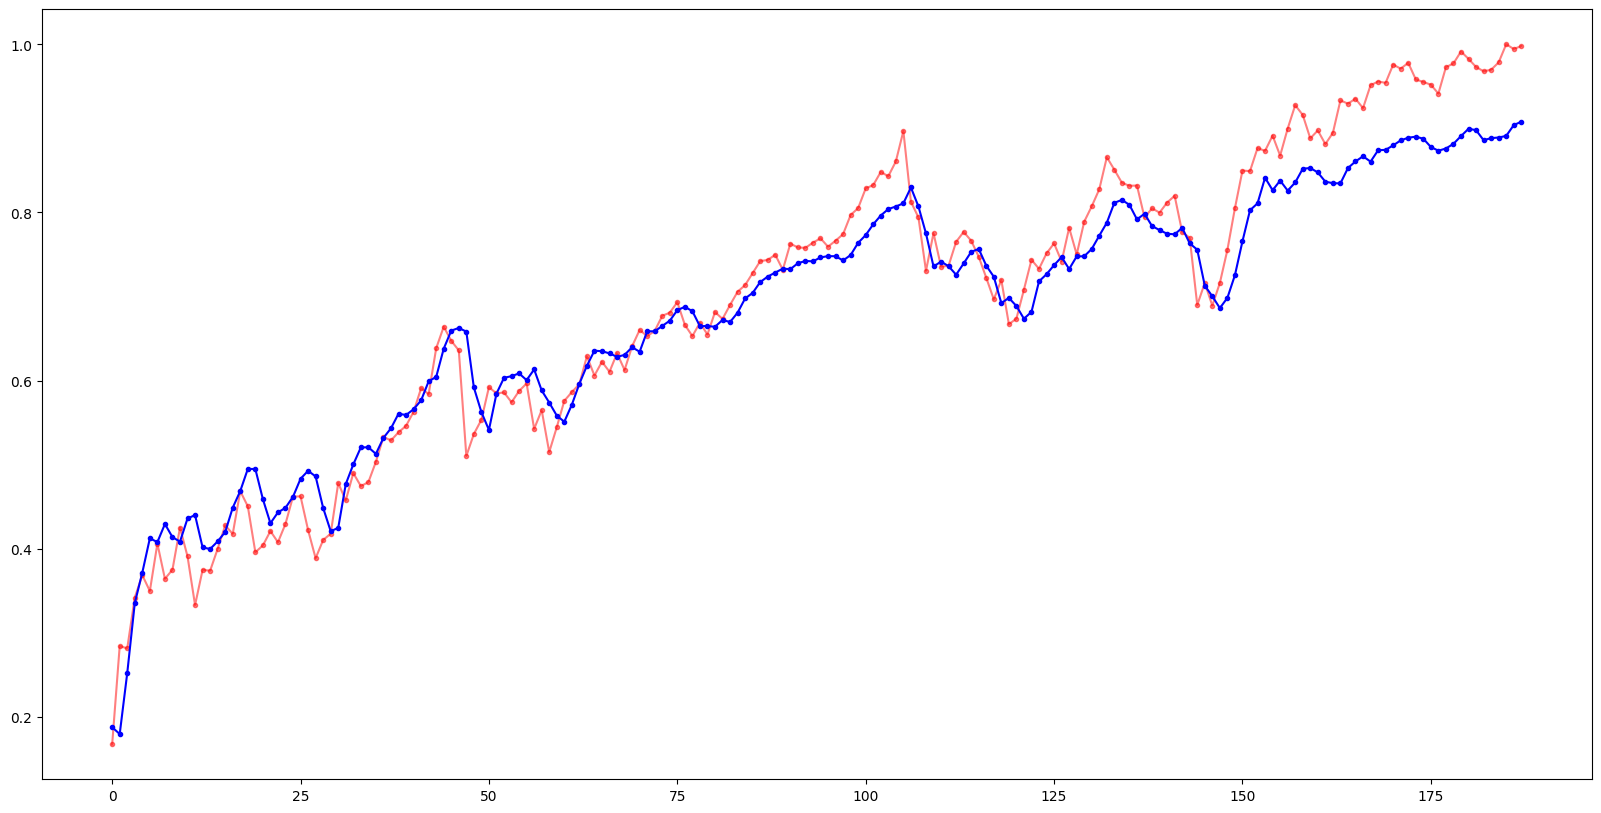

R2 Score: 0.9328190311465767
MAE: 0.037873786858821805
RMSE: 0.04839553938234193
Model 7: 120,105,105
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_58 (LSTM)              (None, 10, 120)           60000     
                                                                 
 lstm_59 (LSTM)              (None, 105)               94920     
                                                                 
 dense_29 (Dense)            (None, 1)                 106       
                                                                 
Total params: 155026 (605.57 KB)
Trainable params: 155026 (605.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
start: 0
Epoch 1/50
98/98 [==============================] - 8s 33ms/step - loss: 0.0029 - val_loss: 0.0601
Epoch 2/50
98/98 [==============================] - 2s 24ms/step - 

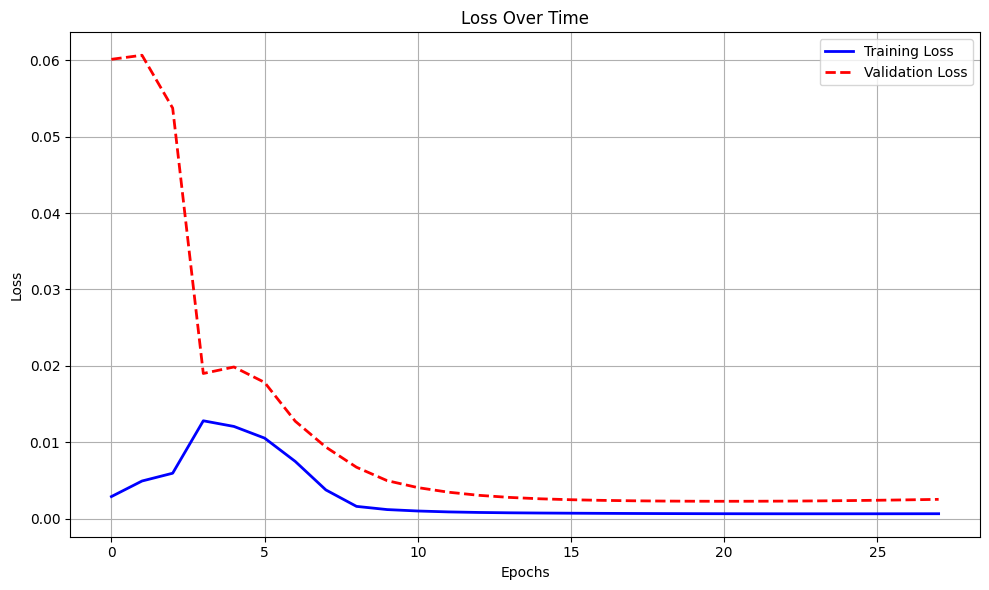

6/6 [==============================] - 1s 14ms/step


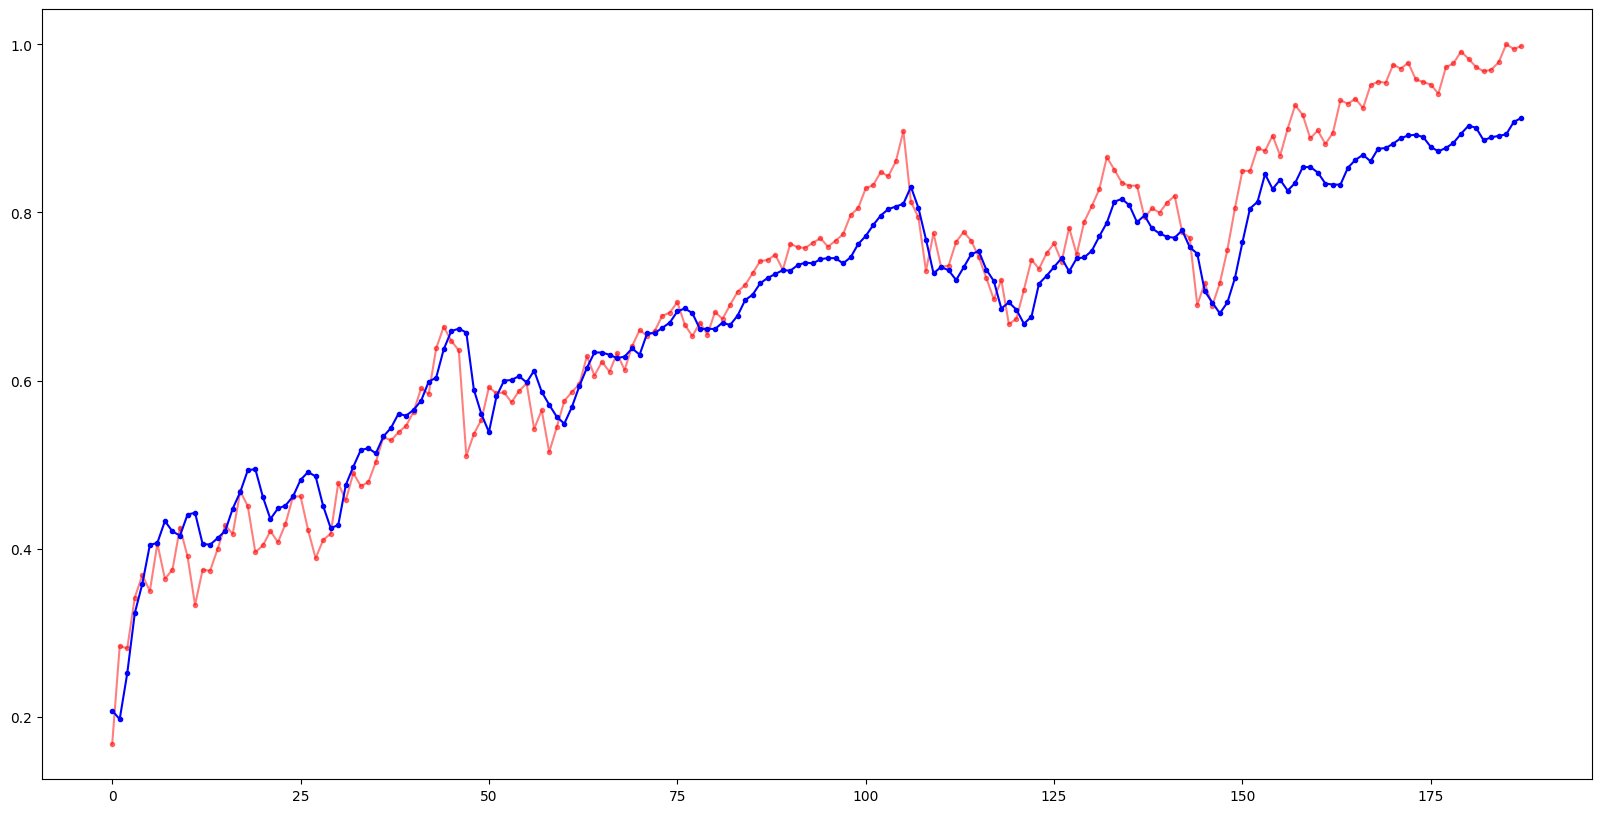

R2 Score: 0.9330631605322991
MAE: 0.03827315504084691
RMSE: 0.0483075269102382
Model 1: 120,100,100
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_60 (LSTM)              (None, 11, 120)           60000     
                                                                 
 lstm_61 (LSTM)              (None, 100)               88400     
                                                                 
 dense_30 (Dense)            (None, 1)                 101       
                                                                 
Total params: 148501 (580.08 KB)
Trainable params: 148501 (580.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
start: 0
Epoch 1/50
98/98 [==============================] - 7s 34ms/step - loss: 0.0030 - val_loss: 0.0634
Epoch 2/50
98/98 [==============================] - 2s 25ms/step - lo

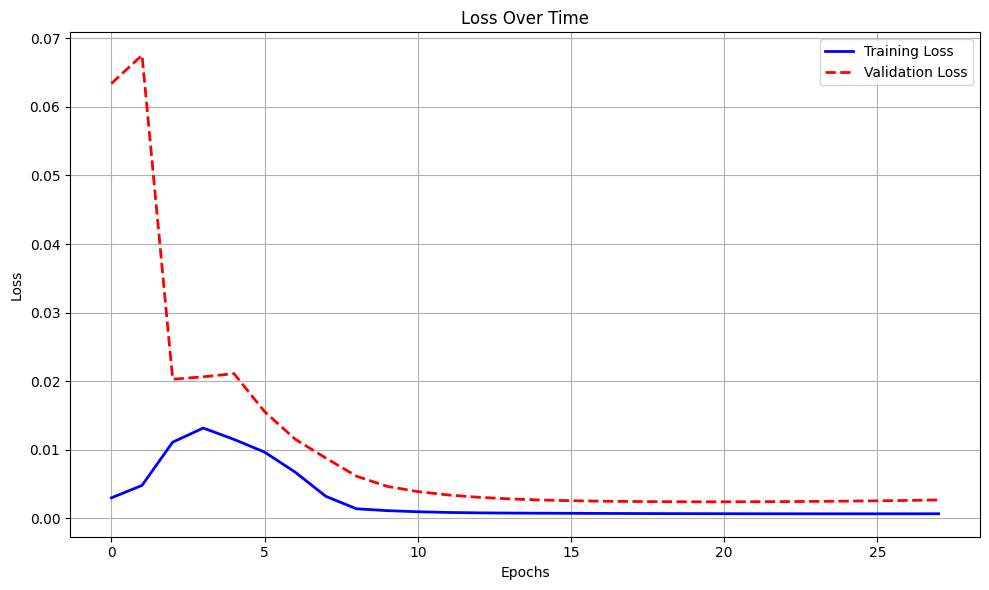

6/6 [==============================] - 1s 14ms/step


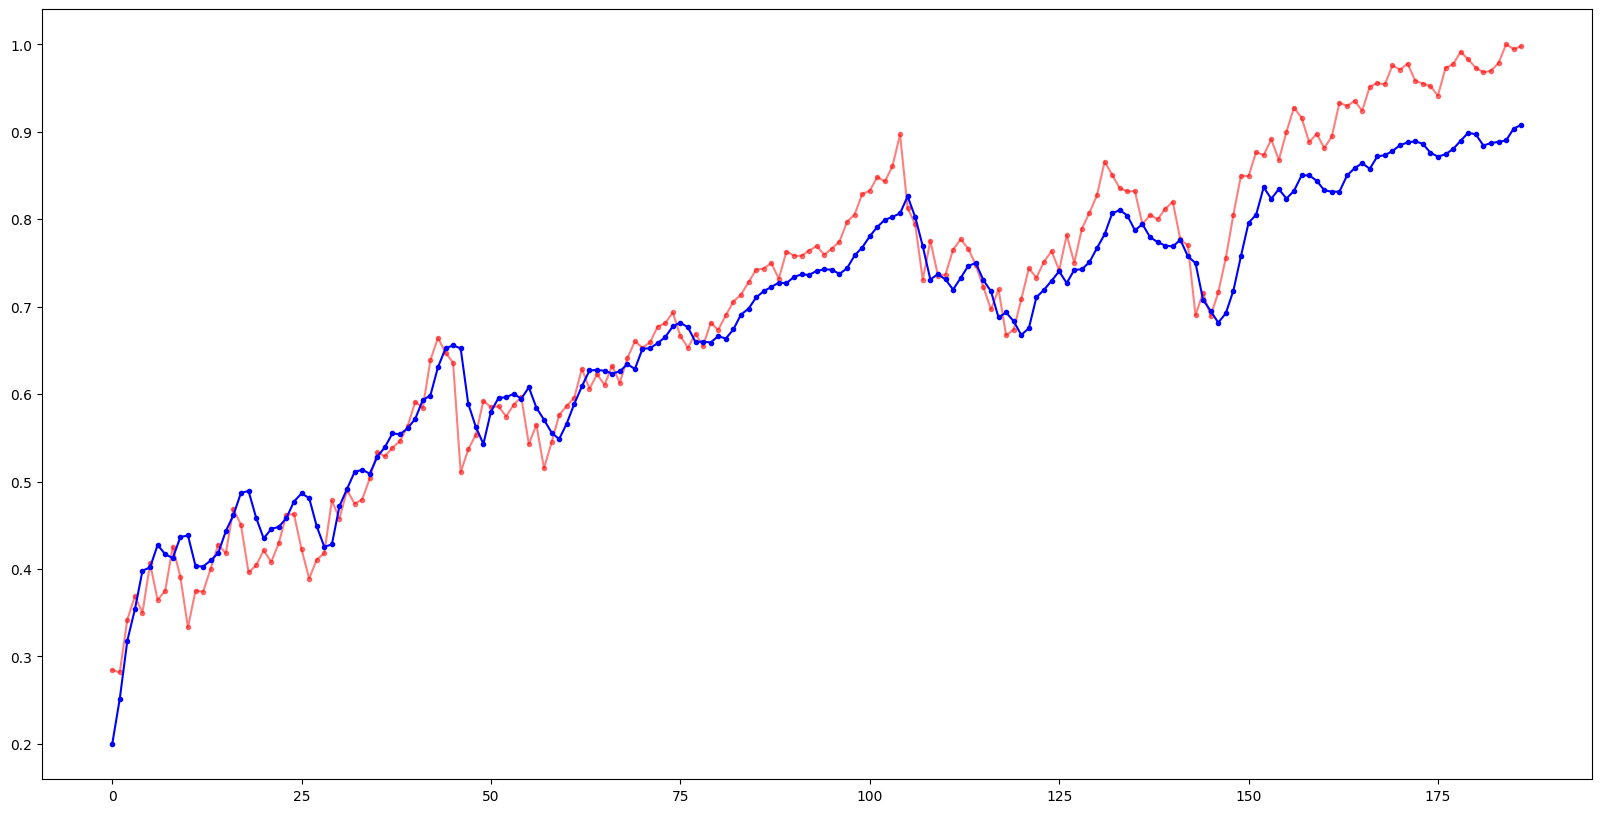

R2 Score: 0.9271376782277871
MAE: 0.039265043852213334
RMSE: 0.049452420524400825
Model 4: 200,100,100
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_62 (LSTM)              (None, 11, 200)           164000    
                                                                 
 lstm_63 (LSTM)              (None, 100)               120400    
                                                                 
 dense_31 (Dense)            (None, 1)                 101       
                                                                 
Total params: 284501 (1.09 MB)
Trainable params: 284501 (1.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
start: 0
Epoch 1/50
98/98 [==============================] - 9s 54ms/step - loss: 0.0028 - val_loss: 0.0821
Epoch 2/50
98/98 [==============================] - 4s 44ms/step - los

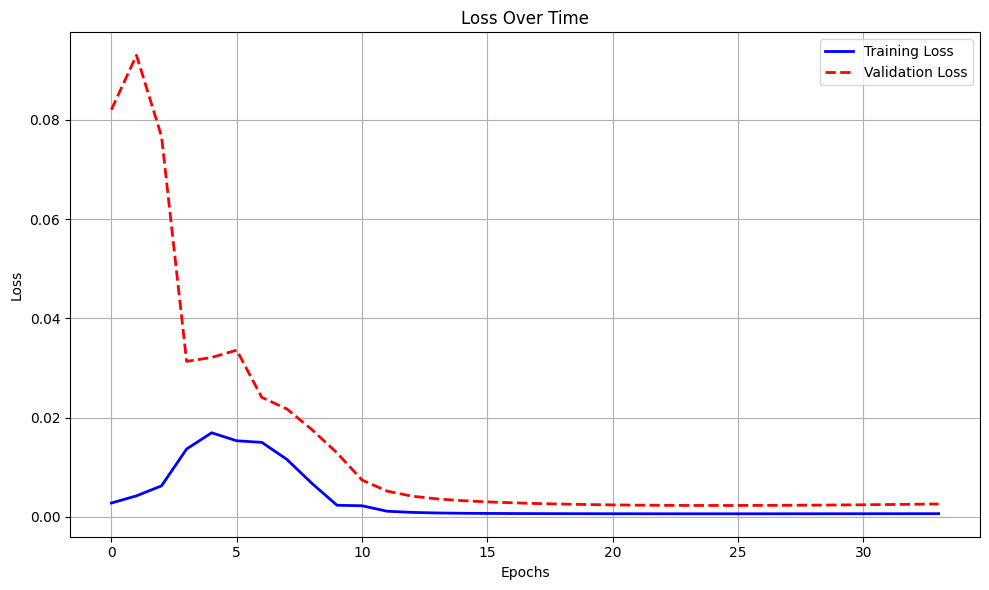

6/6 [==============================] - 1s 18ms/step


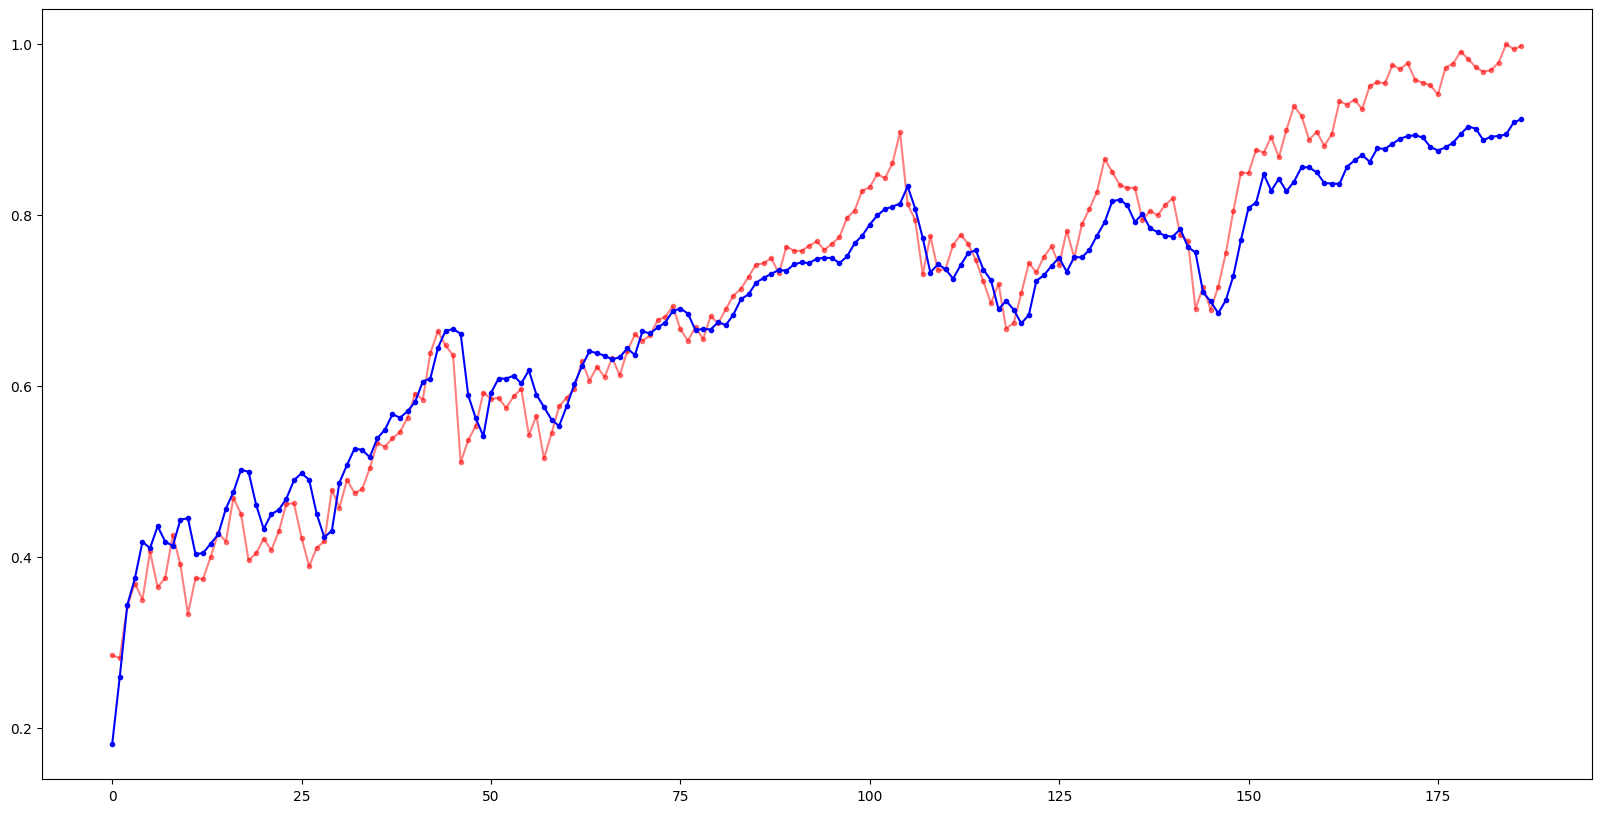

R2 Score: 0.9318832678428923
MAE: 0.03776171488987911
RMSE: 0.04781486711017919
Model 7: 120,105,105
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_64 (LSTM)              (None, 11, 120)           60000     
                                                                 
 lstm_65 (LSTM)              (None, 105)               94920     
                                                                 
 dense_32 (Dense)            (None, 1)                 106       
                                                                 
Total params: 155026 (605.57 KB)
Trainable params: 155026 (605.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
start: 0
Epoch 1/50
98/98 [==============================] - 8s 35ms/step - loss: 0.0030 - val_loss: 0.0623
Epoch 2/50
98/98 [==============================] - 2s 25ms/step - l

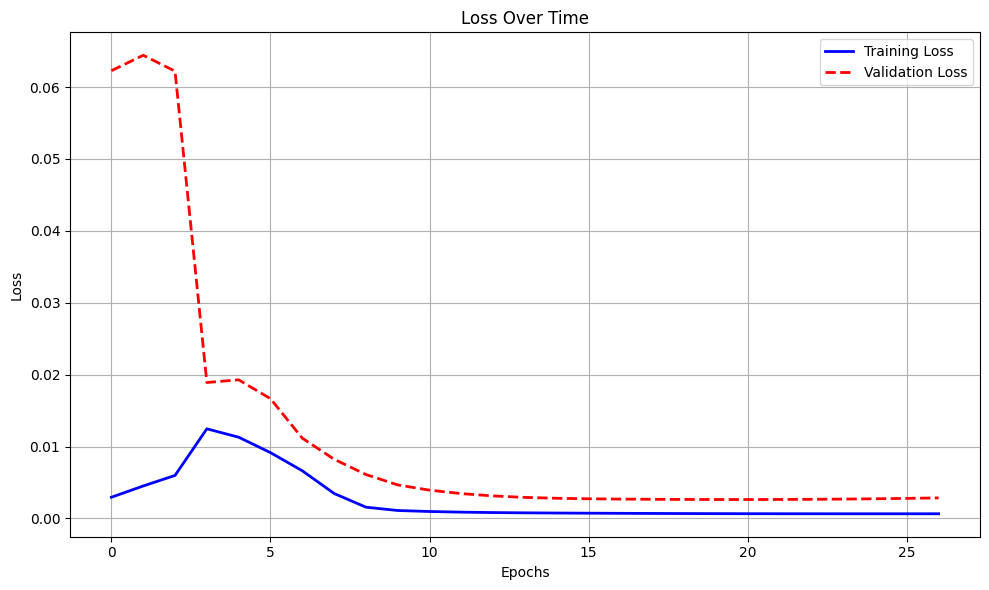

6/6 [==============================] - 1s 15ms/step


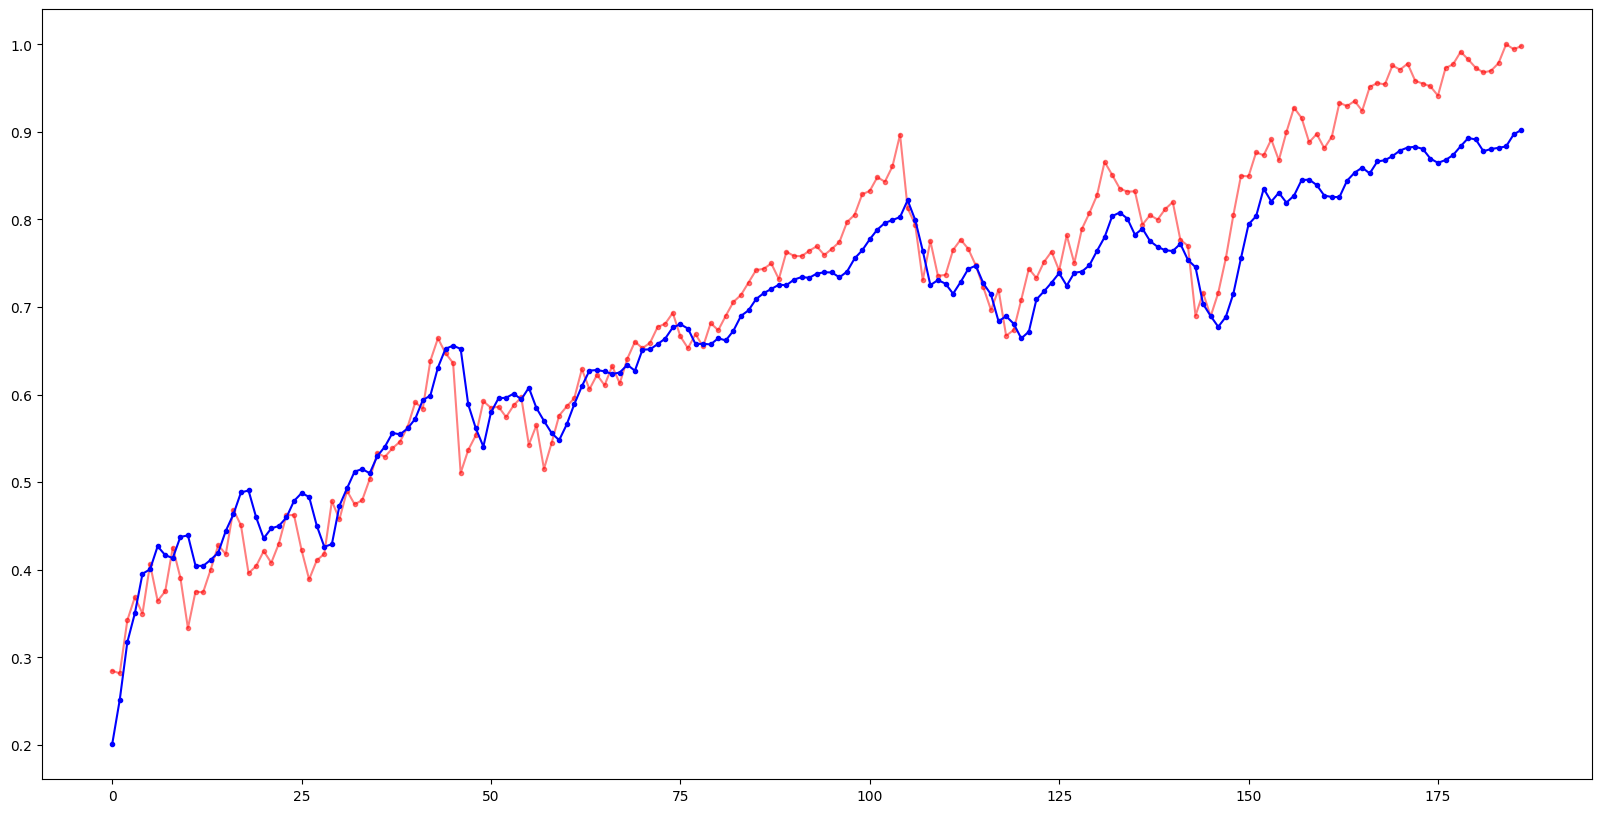

R2 Score: 0.9196254067342853
MAE: 0.04126332916240459
RMSE: 0.05193922256600893
Model 1: 120,100,100
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_66 (LSTM)              (None, 12, 120)           60000     
                                                                 
 lstm_67 (LSTM)              (None, 100)               88400     
                                                                 
 dense_33 (Dense)            (None, 1)                 101       
                                                                 
Total params: 148501 (580.08 KB)
Trainable params: 148501 (580.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
start: 0
Epoch 1/50
97/97 [==============================] - 7s 34ms/step - loss: 0.0028 - val_loss: 0.0308
Epoch 2/50
97/97 [==============================] - 2s 24ms/step - l

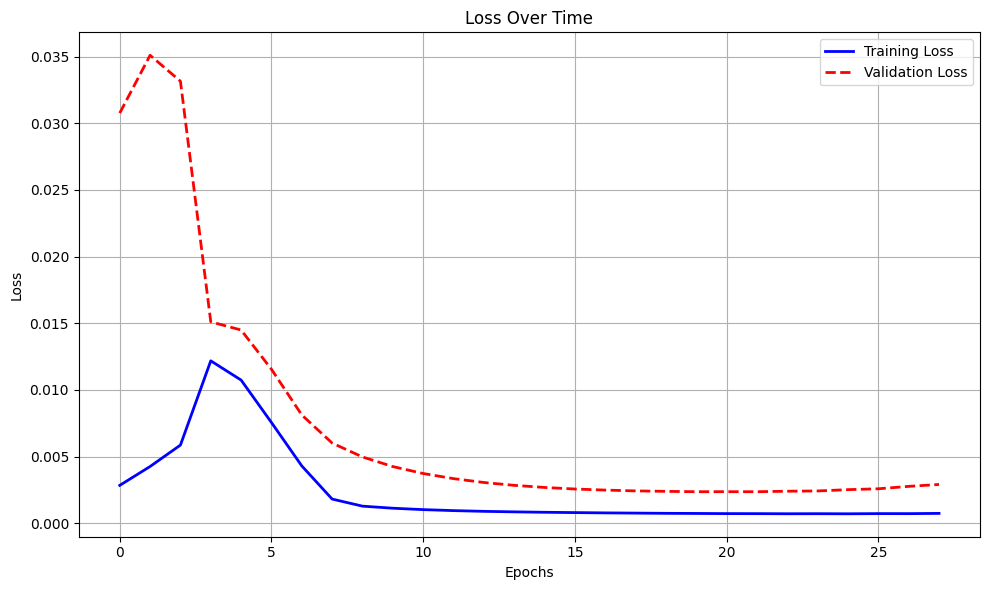

6/6 [==============================] - 1s 14ms/step


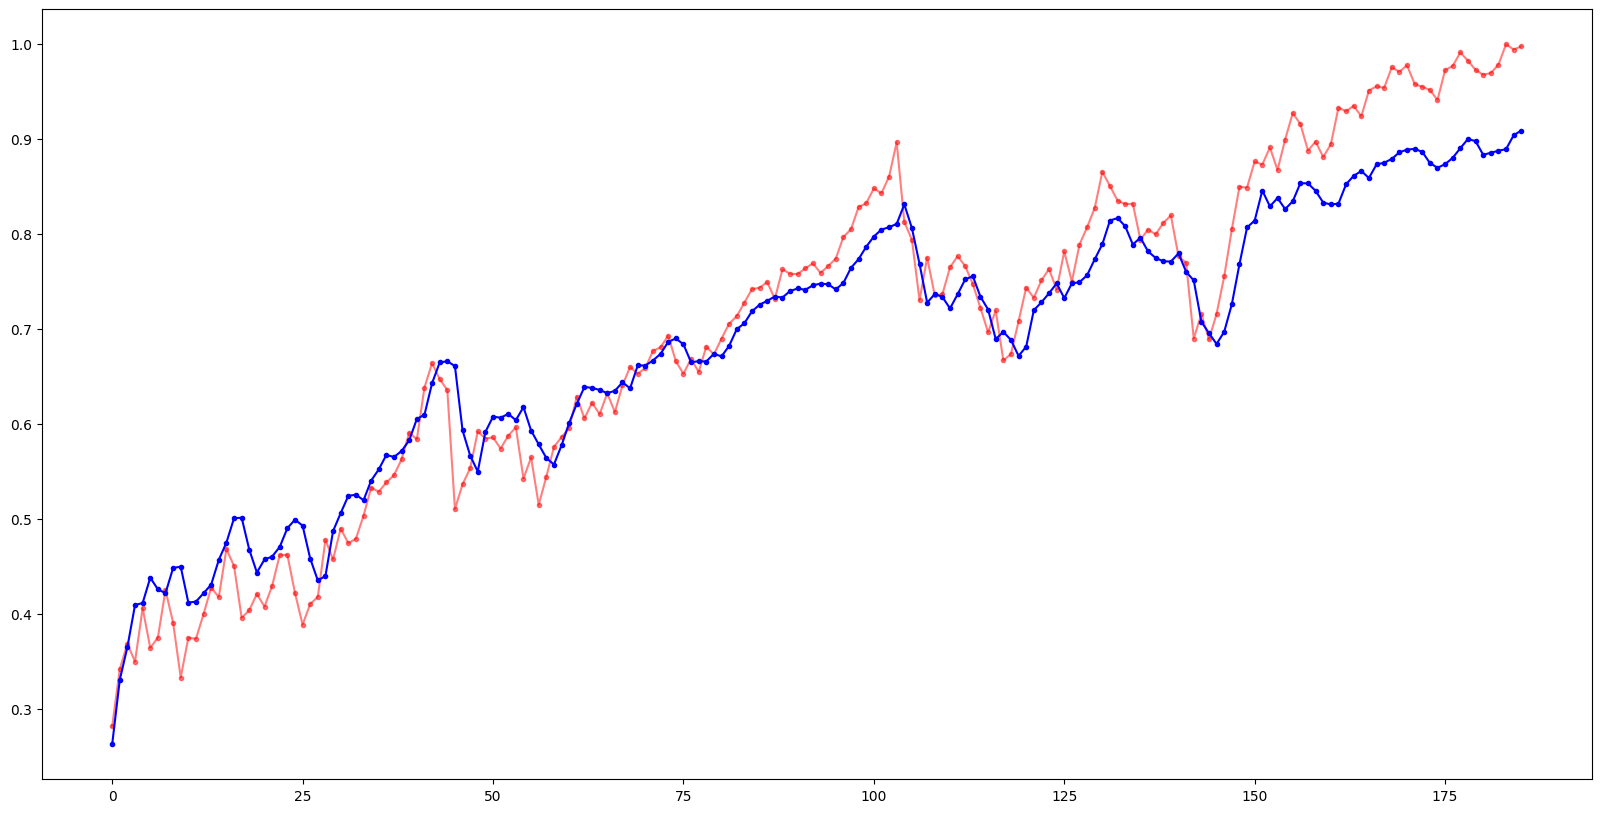

R2 Score: 0.926180731061029
MAE: 0.039056801940532584
RMSE: 0.04922779127271319
Model 4: 200,100,100
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_68 (LSTM)              (None, 12, 200)           164000    
                                                                 
 lstm_69 (LSTM)              (None, 100)               120400    
                                                                 
 dense_34 (Dense)            (None, 1)                 101       
                                                                 
Total params: 284501 (1.09 MB)
Trainable params: 284501 (1.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
start: 0
Epoch 1/50
97/97 [==============================] - 9s 59ms/step - loss: 0.0030 - val_loss: 0.0365
Epoch 2/50
97/97 [==============================] - 5s 56ms/step - loss:

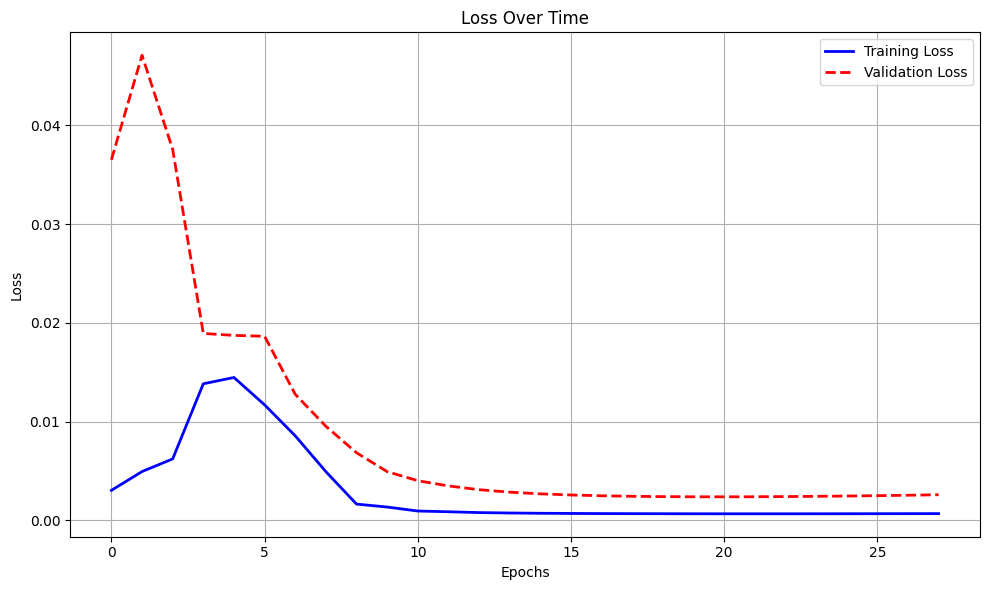

6/6 [==============================] - 1s 21ms/step


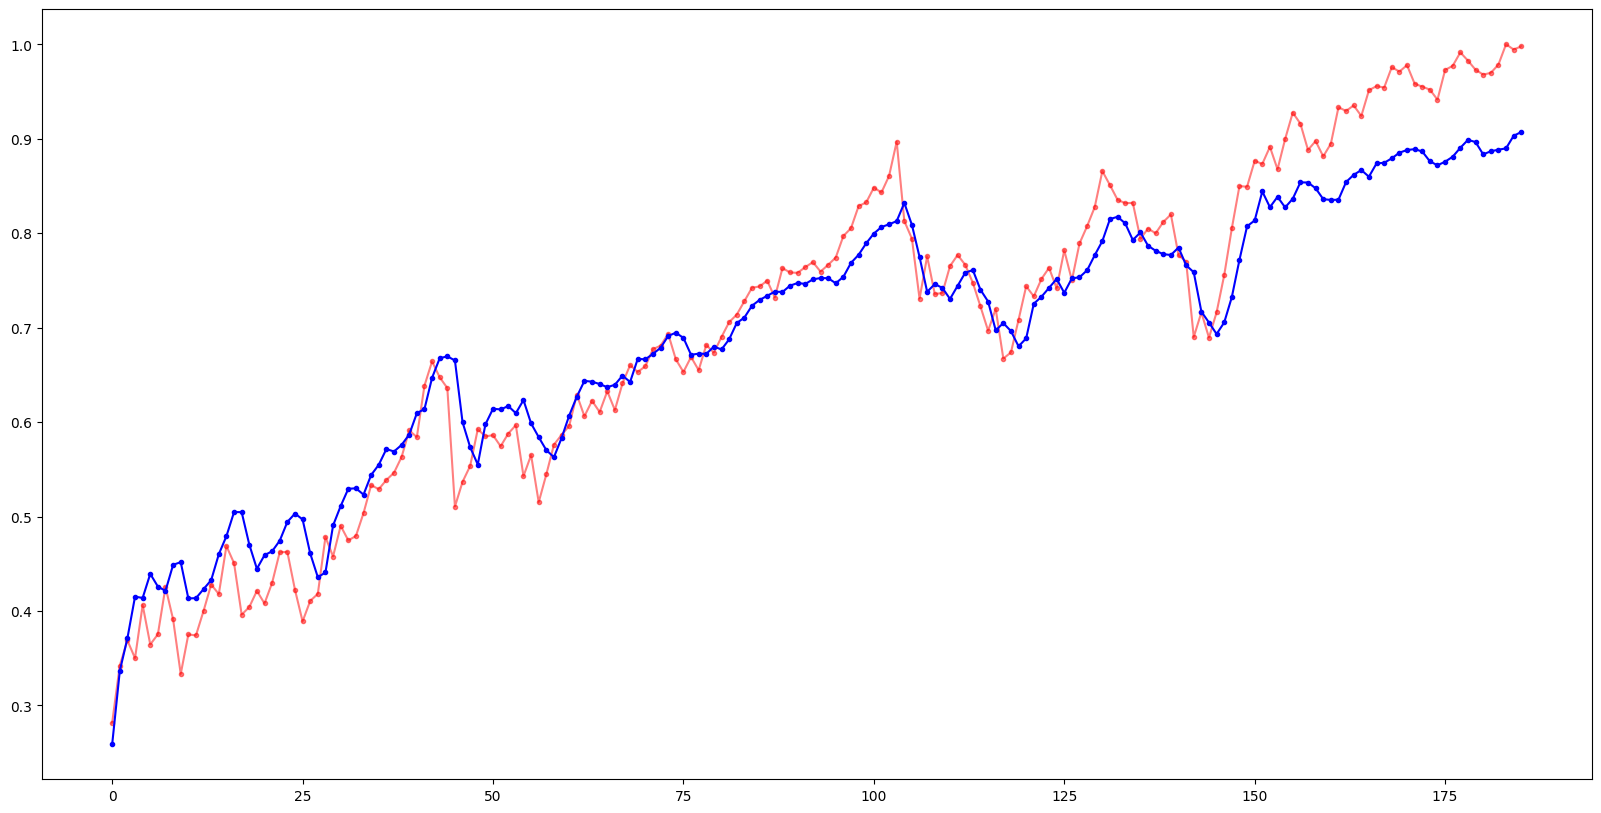

R2 Score: 0.9261185655489997
MAE: 0.03907113813837167
RMSE: 0.04924851504089894
Model 7: 120,105,105
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_70 (LSTM)              (None, 12, 120)           60000     
                                                                 
 lstm_71 (LSTM)              (None, 105)               94920     
                                                                 
 dense_35 (Dense)            (None, 1)                 106       
                                                                 
Total params: 155026 (605.57 KB)
Trainable params: 155026 (605.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
start: 0
Epoch 1/50
97/97 [==============================] - 7s 35ms/step - loss: 0.0029 - val_loss: 0.0295
Epoch 2/50
97/97 [==============================] - 2s 25ms/step - l

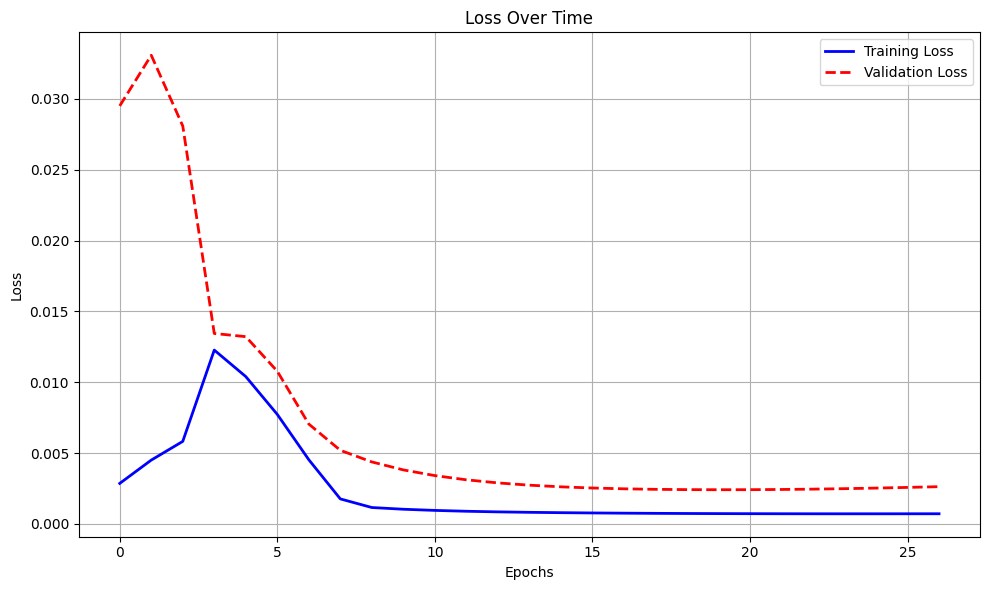

6/6 [==============================] - 1s 15ms/step


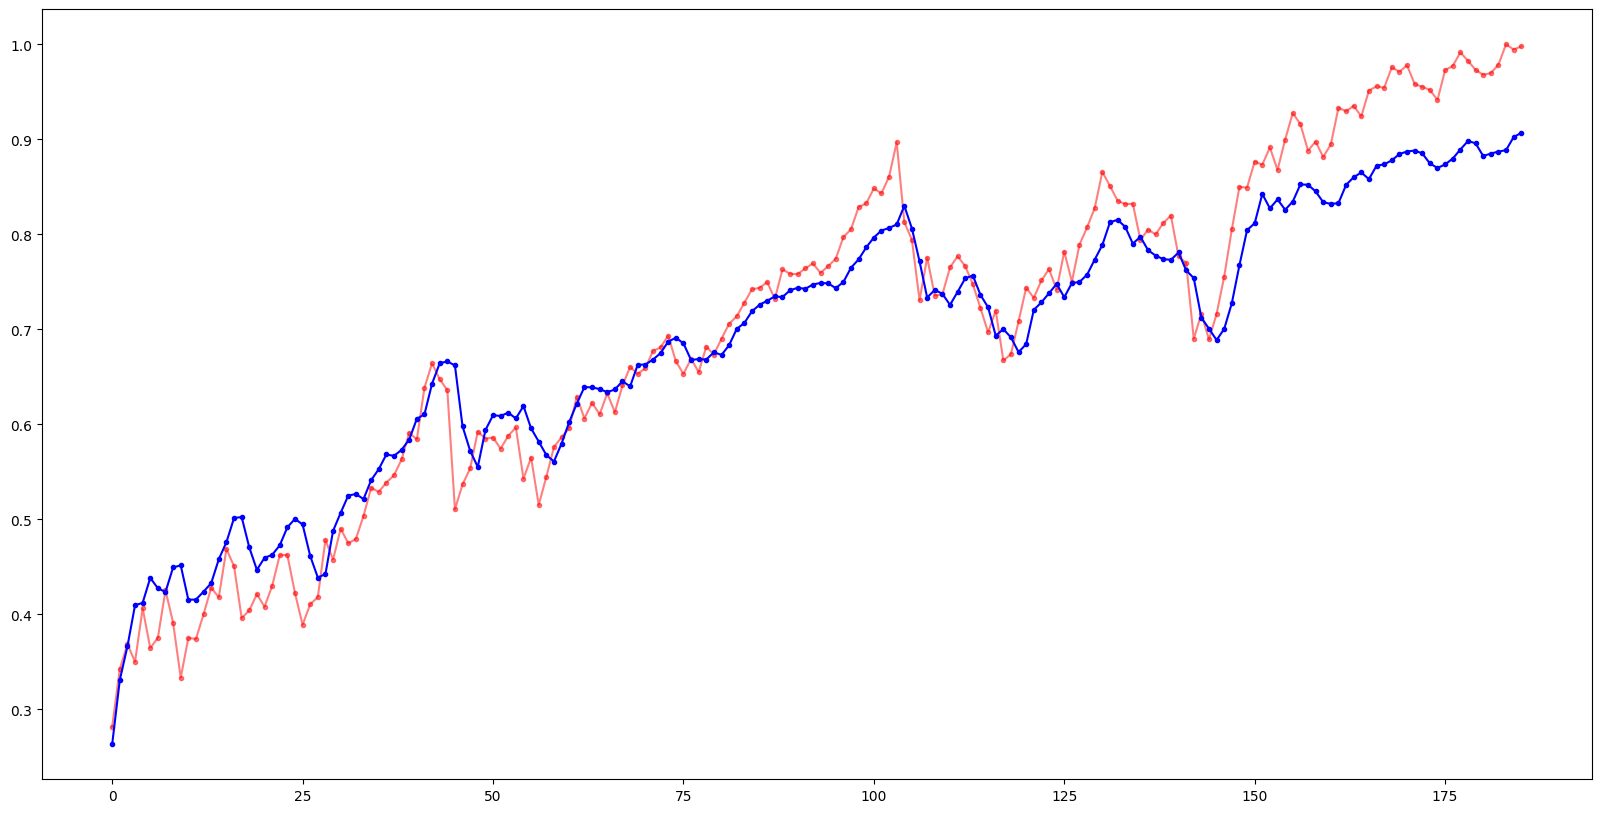

R2 Score: 0.9246110706491701
MAE: 0.03948416918344328
RMSE: 0.04974841727264468
Model 1: 120,100,100
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_72 (LSTM)              (None, 13, 120)           60000     
                                                                 
 lstm_73 (LSTM)              (None, 100)               88400     
                                                                 
 dense_36 (Dense)            (None, 1)                 101       
                                                                 
Total params: 148501 (580.08 KB)
Trainable params: 148501 (580.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
start: 0
Epoch 1/50
97/97 [==============================] - 8s 39ms/step - loss: 0.0030 - val_loss: 0.0395
Epoch 2/50
97/97 [==============================] - 3s 29ms/step - l

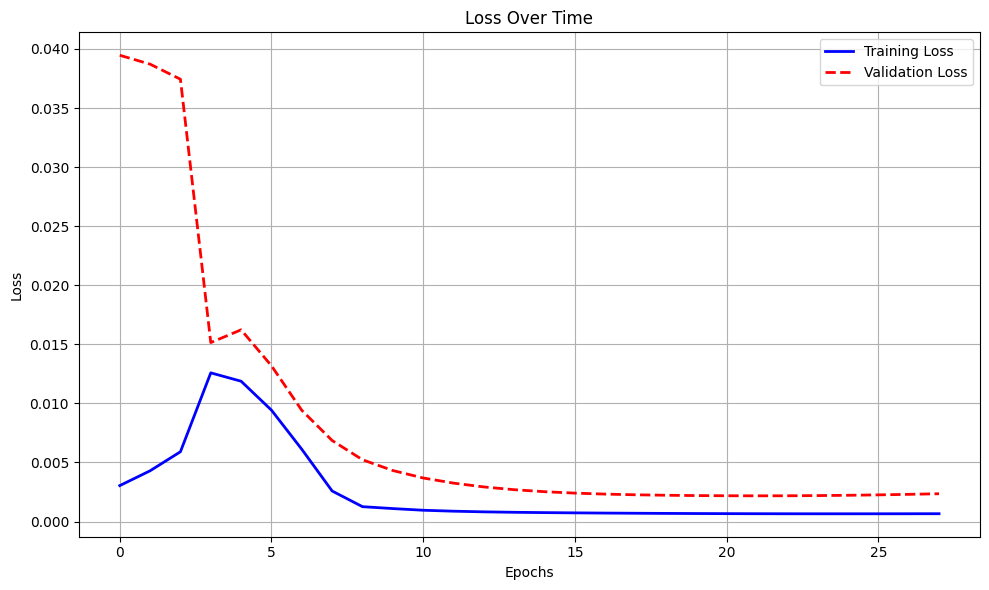

6/6 [==============================] - 1s 14ms/step


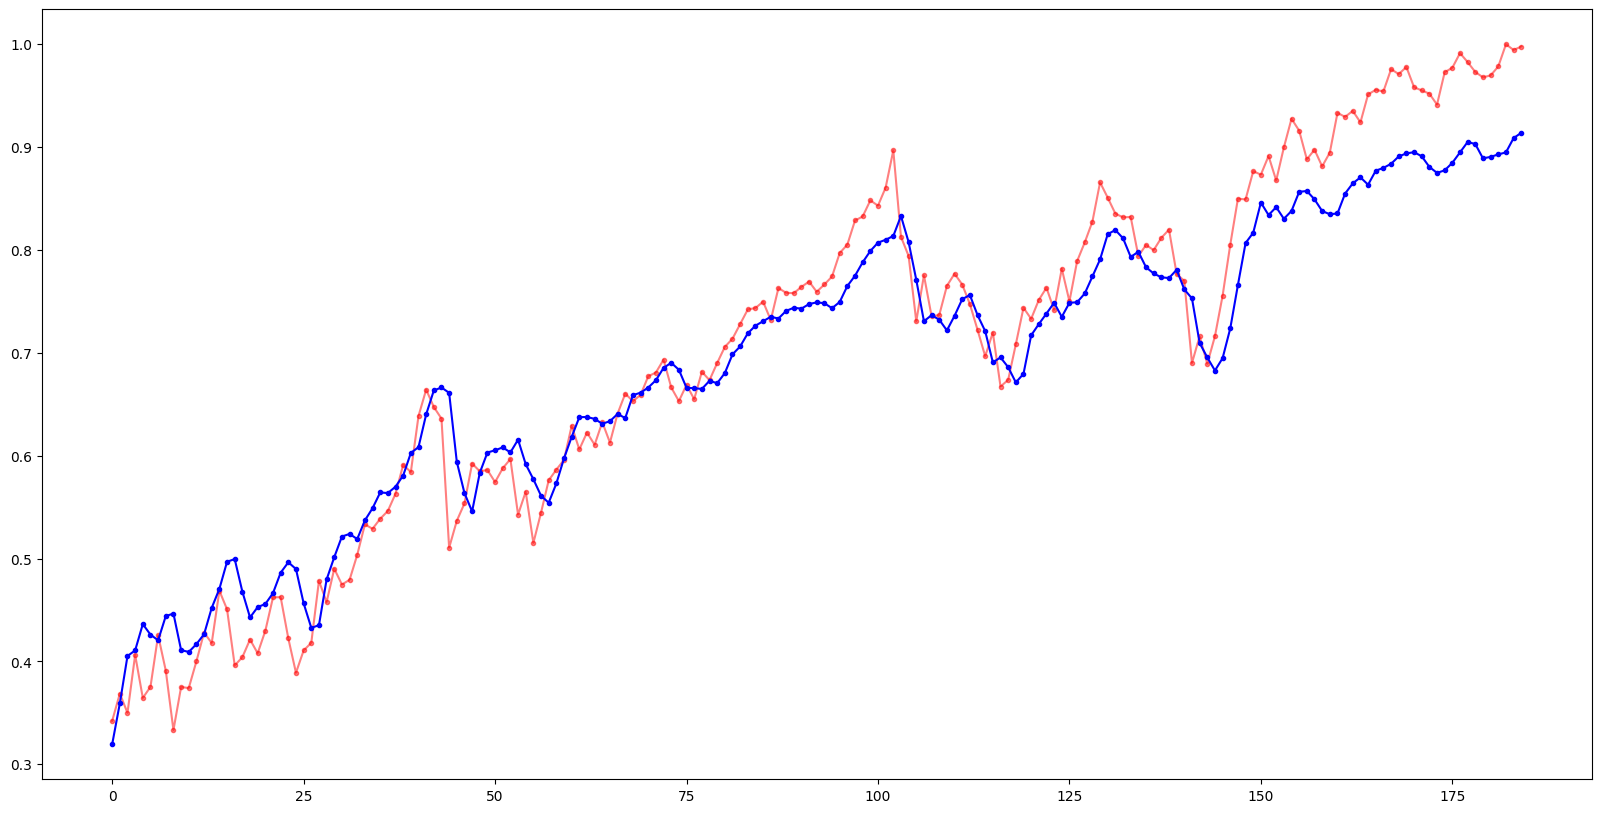

R2 Score: 0.9293826453642035
MAE: 0.037713671555756244
RMSE: 0.04758316691845886
Model 4: 200,100,100
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_74 (LSTM)              (None, 13, 200)           164000    
                                                                 
 lstm_75 (LSTM)              (None, 100)               120400    
                                                                 
 dense_37 (Dense)            (None, 1)                 101       
                                                                 
Total params: 284501 (1.09 MB)
Trainable params: 284501 (1.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
start: 0
Epoch 1/50
97/97 [==============================] - 13s 83ms/step - loss: 0.0031 - val_loss: 0.0442
Epoch 2/50
97/97 [==============================] - 7s 73ms/step - los

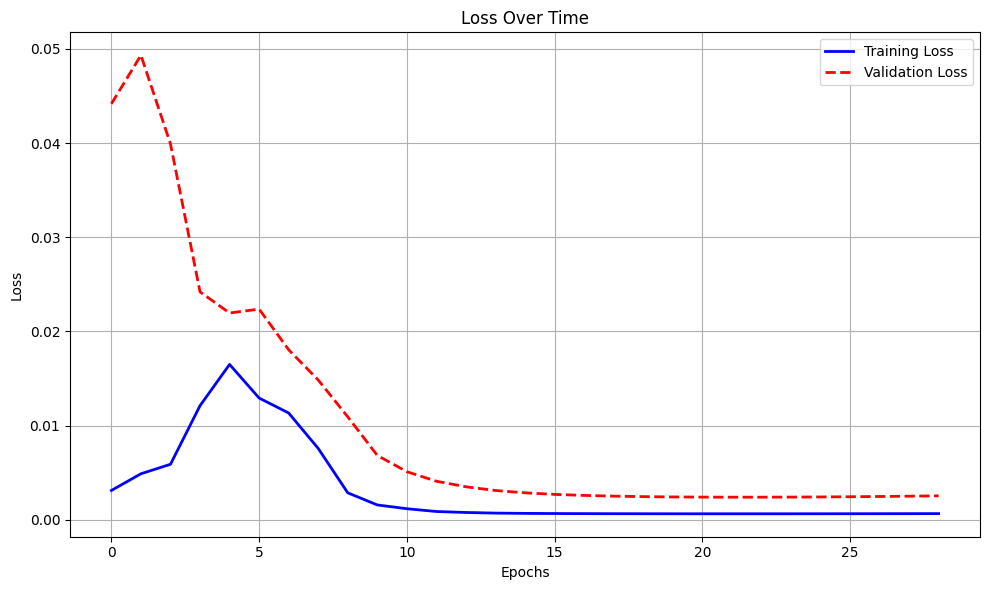

6/6 [==============================] - 1s 27ms/step


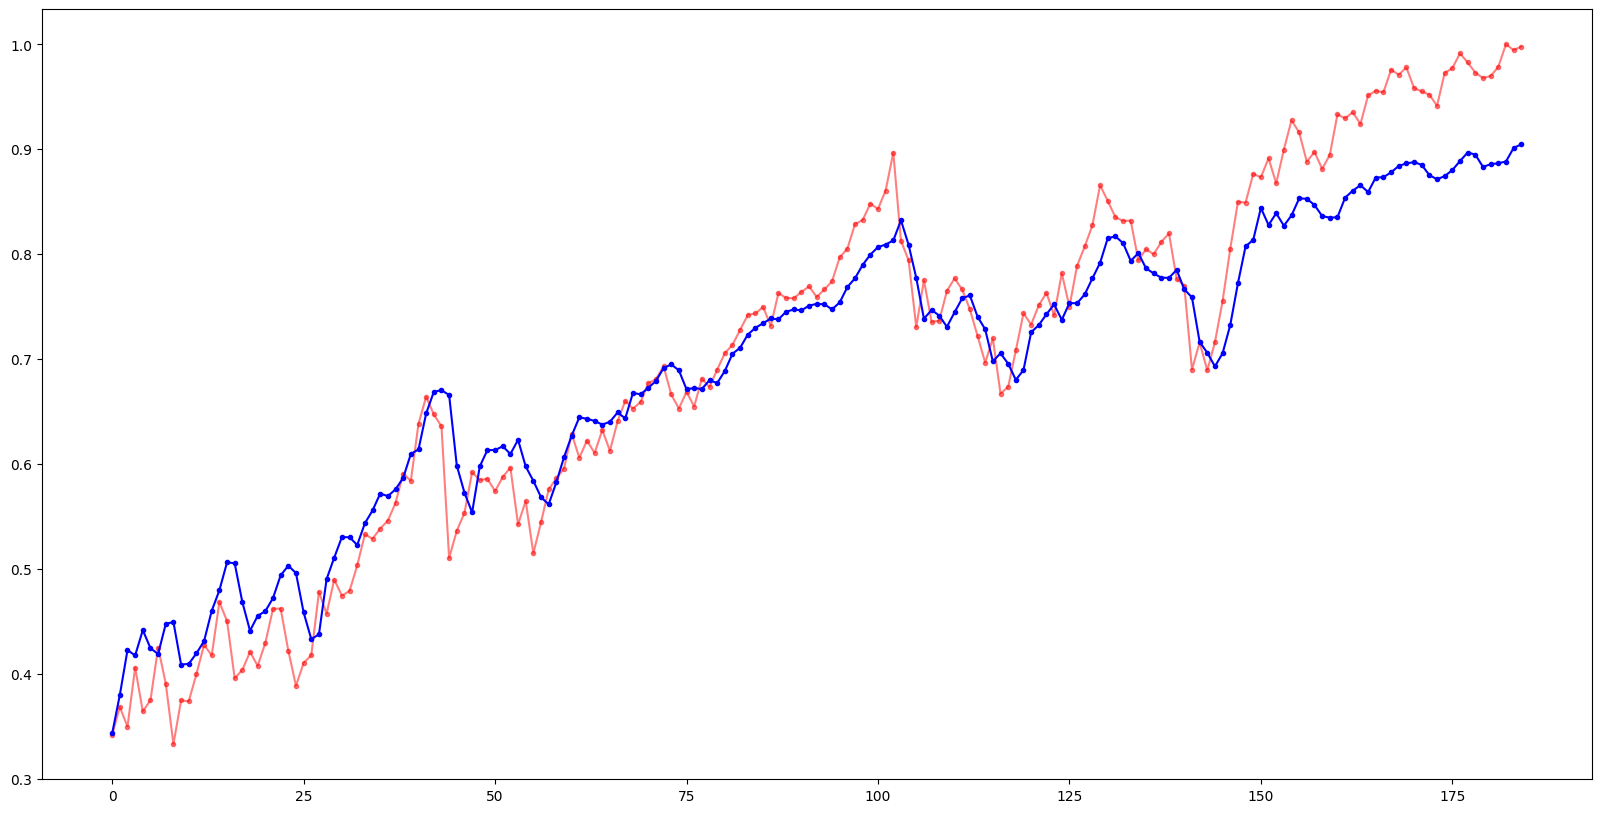

R2 Score: 0.9232737618655412
MAE: 0.03927424368906282
RMSE: 0.049598617781489655
Model 7: 120,105,105
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_76 (LSTM)              (None, 13, 120)           60000     
                                                                 
 lstm_77 (LSTM)              (None, 105)               94920     
                                                                 
 dense_38 (Dense)            (None, 1)                 106       
                                                                 
Total params: 155026 (605.57 KB)
Trainable params: 155026 (605.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
start: 0
Epoch 1/50
97/97 [==============================] - 8s 40ms/step - loss: 0.0030 - val_loss: 0.0397
Epoch 2/50
97/97 [==============================] - 3s 31ms/step - 

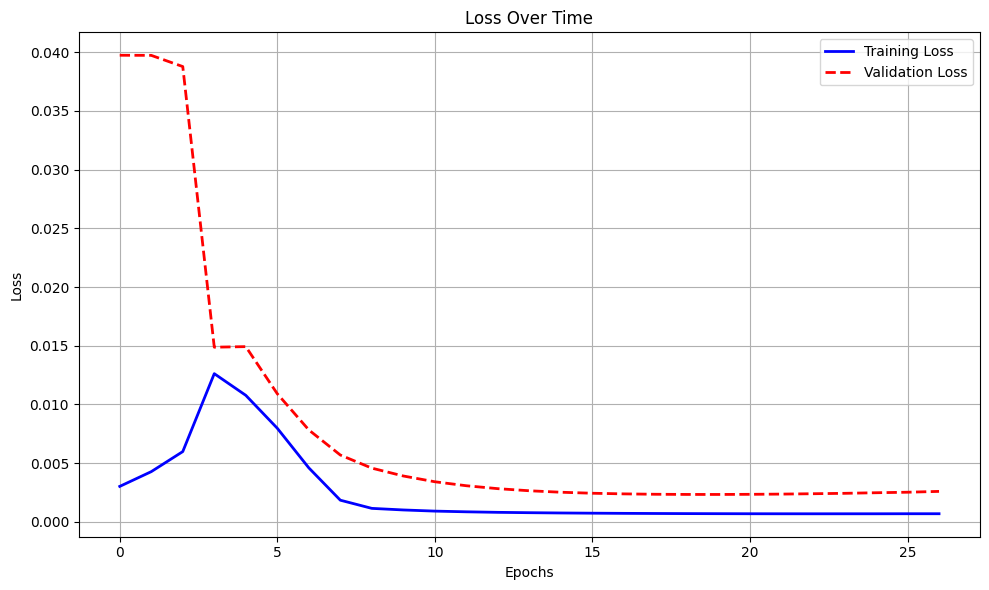

6/6 [==============================] - 1s 17ms/step


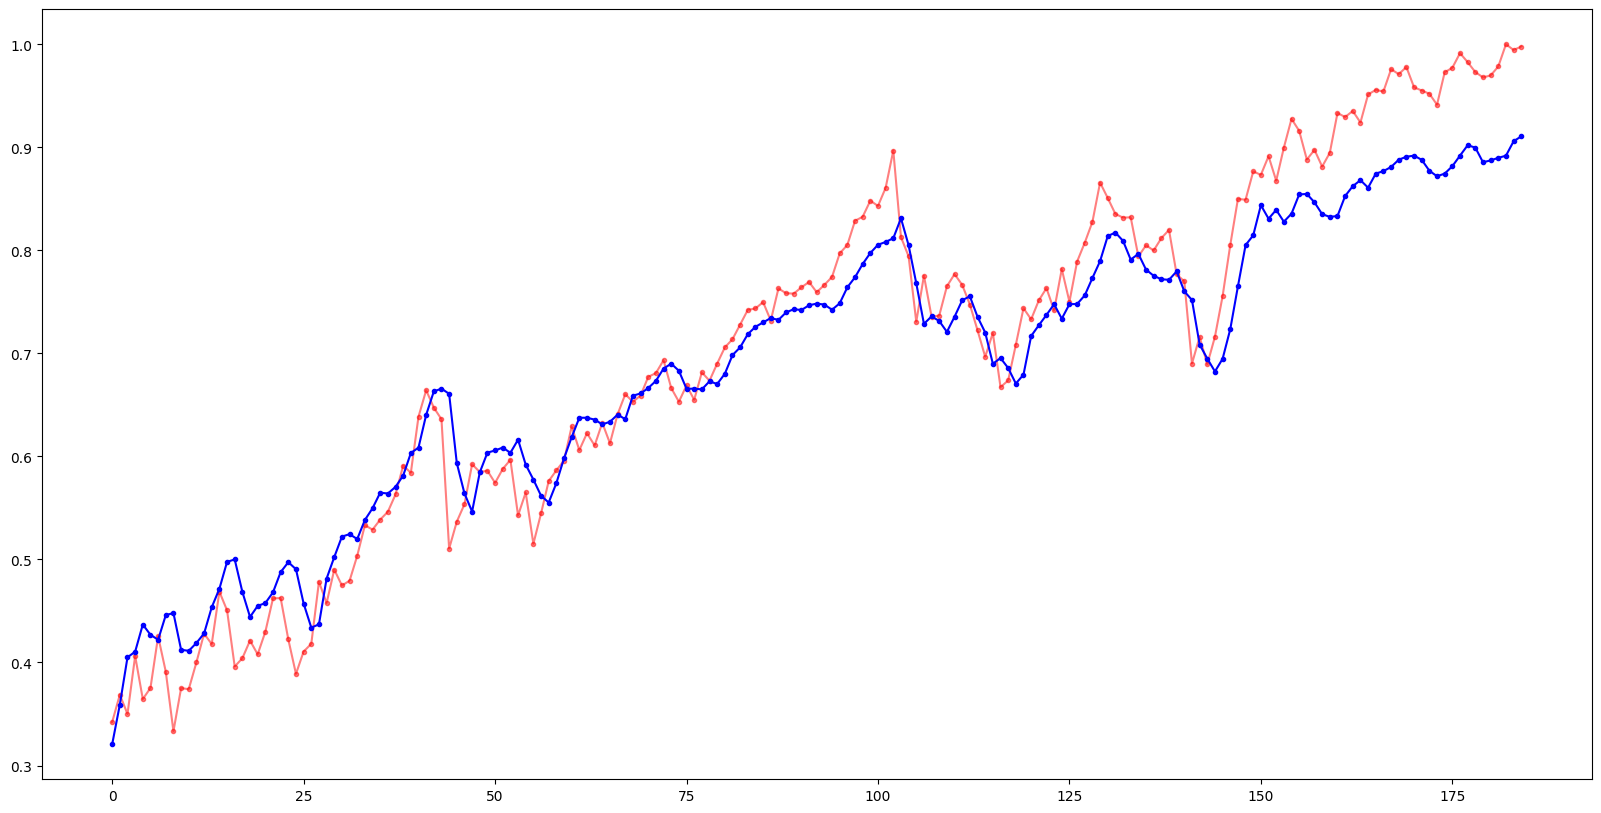

R2 Score: 0.925890623903378
MAE: 0.03862211913583212
RMSE: 0.04874546297108217
Model 1: 120,100,100
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_78 (LSTM)              (None, 14, 120)           60000     
                                                                 
 lstm_79 (LSTM)              (None, 100)               88400     
                                                                 
 dense_39 (Dense)            (None, 1)                 101       
                                                                 
Total params: 148501 (580.08 KB)
Trainable params: 148501 (580.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
start: 0
Epoch 1/50
97/97 [==============================] - 8s 40ms/step - loss: 0.0029 - val_loss: 0.0434
Epoch 2/50
97/97 [==============================] - 3s 31ms/step - lo

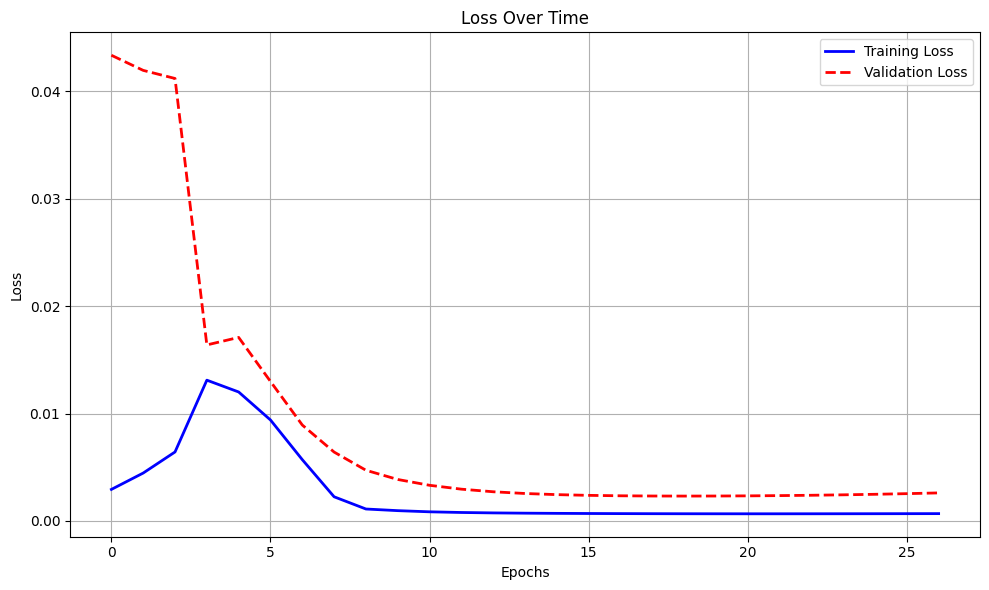

6/6 [==============================] - 1s 17ms/step


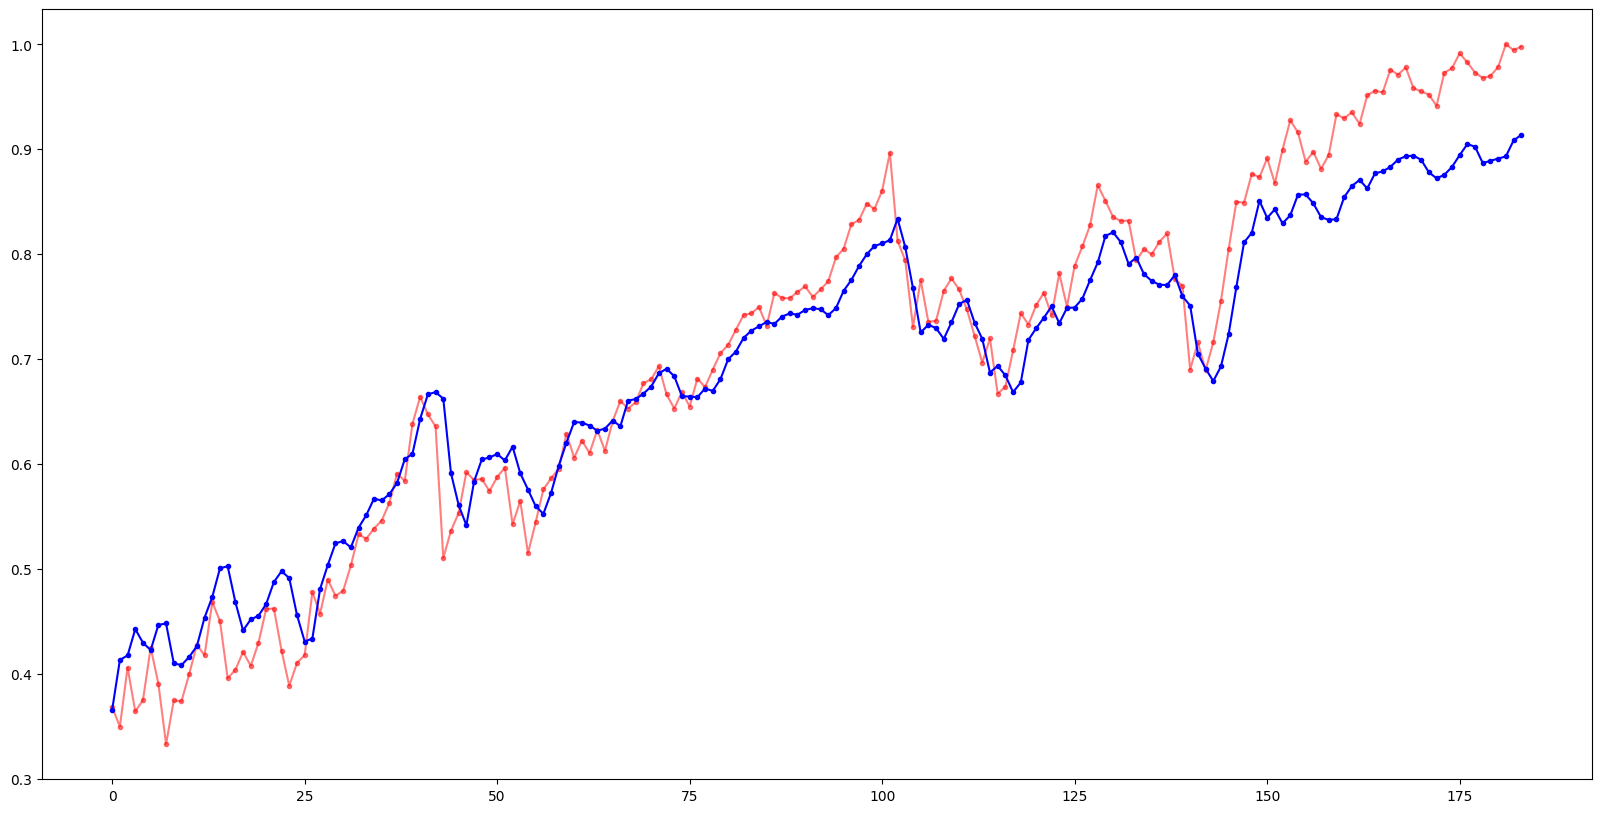

R2 Score: 0.9258442922340606
MAE: 0.03833876873922174
RMSE: 0.04835757962644551
Model 4: 200,100,100
Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_80 (LSTM)              (None, 14, 200)           164000    
                                                                 
 lstm_81 (LSTM)              (None, 100)               120400    
                                                                 
 dense_40 (Dense)            (None, 1)                 101       
                                                                 
Total params: 284501 (1.09 MB)
Trainable params: 284501 (1.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
start: 0
Epoch 1/50
97/97 [==============================] - 10s 65ms/step - loss: 0.0030 - val_loss: 0.0445
Epoch 2/50
97/97 [==============================] - 5s 54ms/step - loss

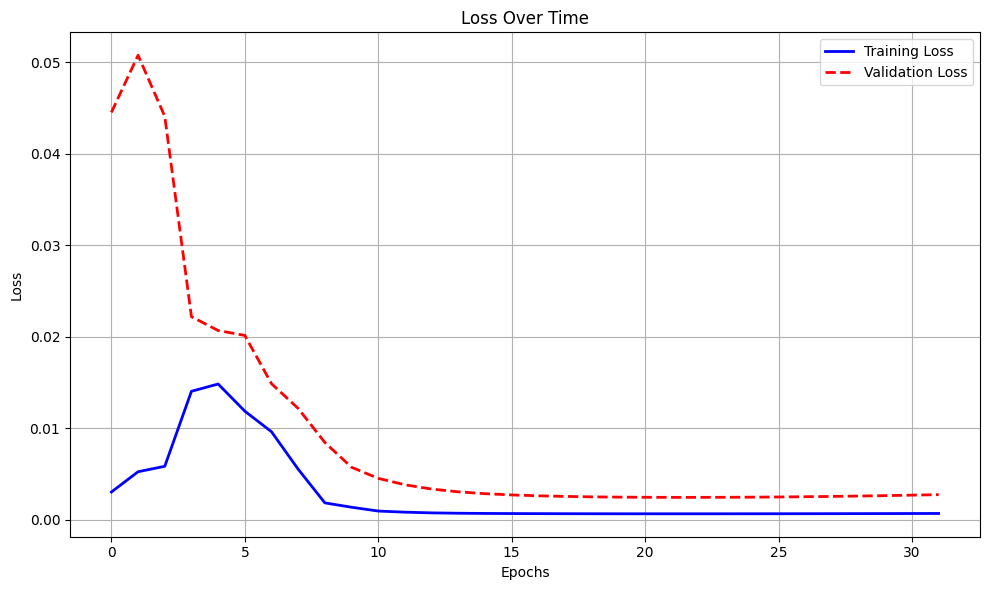

6/6 [==============================] - 1s 23ms/step


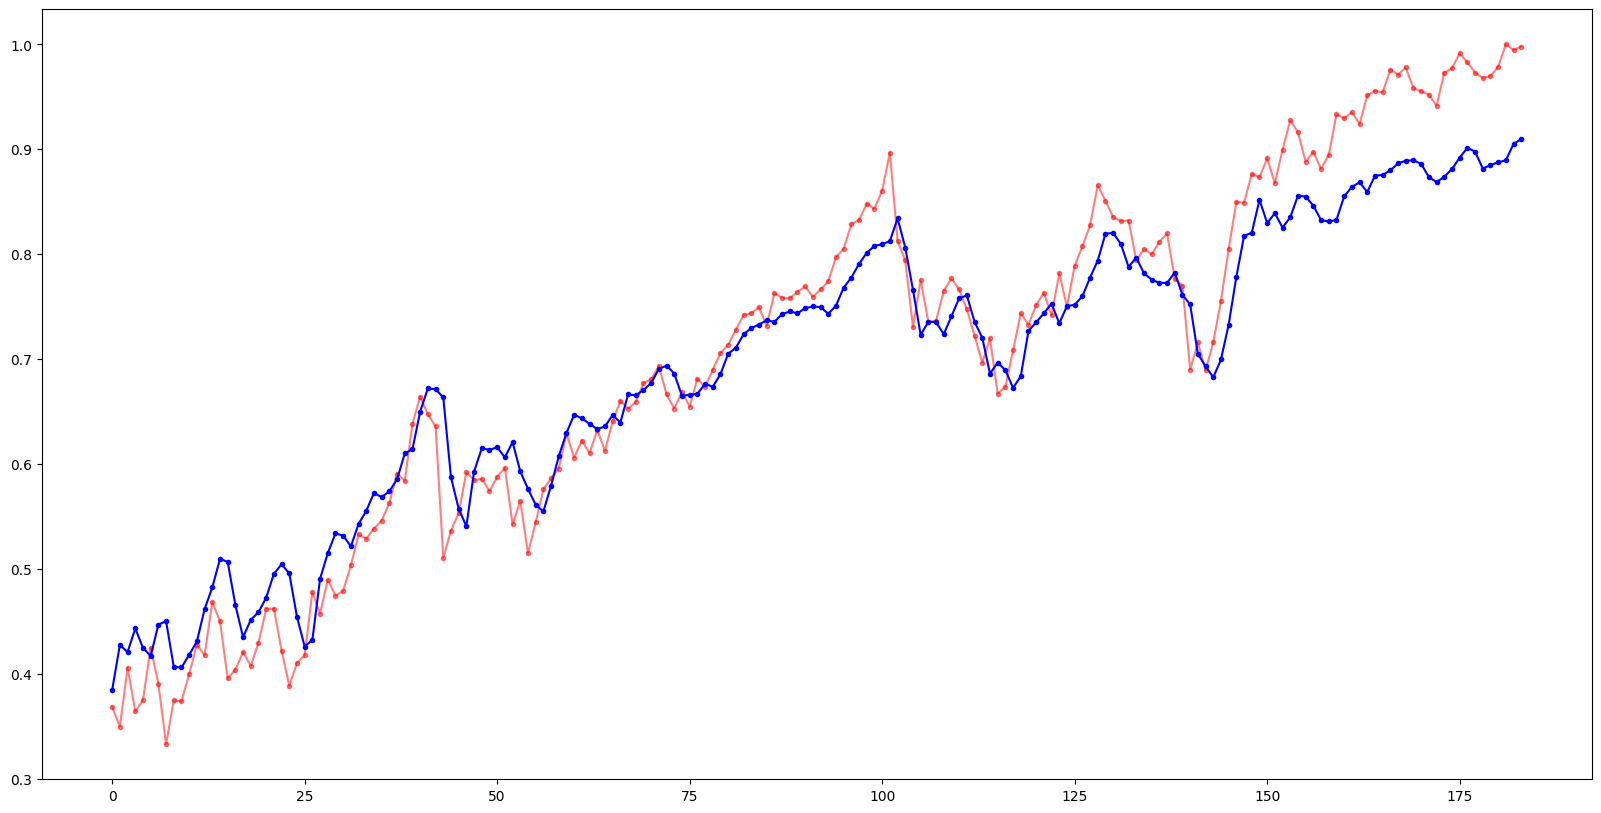

R2 Score: 0.9224760594344452
MAE: 0.03920123511828889
RMSE: 0.04944361128252602
Model 7: 120,105,105
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_82 (LSTM)              (None, 14, 120)           60000     
                                                                 
 lstm_83 (LSTM)              (None, 105)               94920     
                                                                 
 dense_41 (Dense)            (None, 1)                 106       
                                                                 
Total params: 155026 (605.57 KB)
Trainable params: 155026 (605.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
start: 0
Epoch 1/50
97/97 [==============================] - 8s 43ms/step - loss: 0.0031 - val_loss: 0.0473
Epoch 2/50
97/97 [==============================] - 3s 32ms/step - l

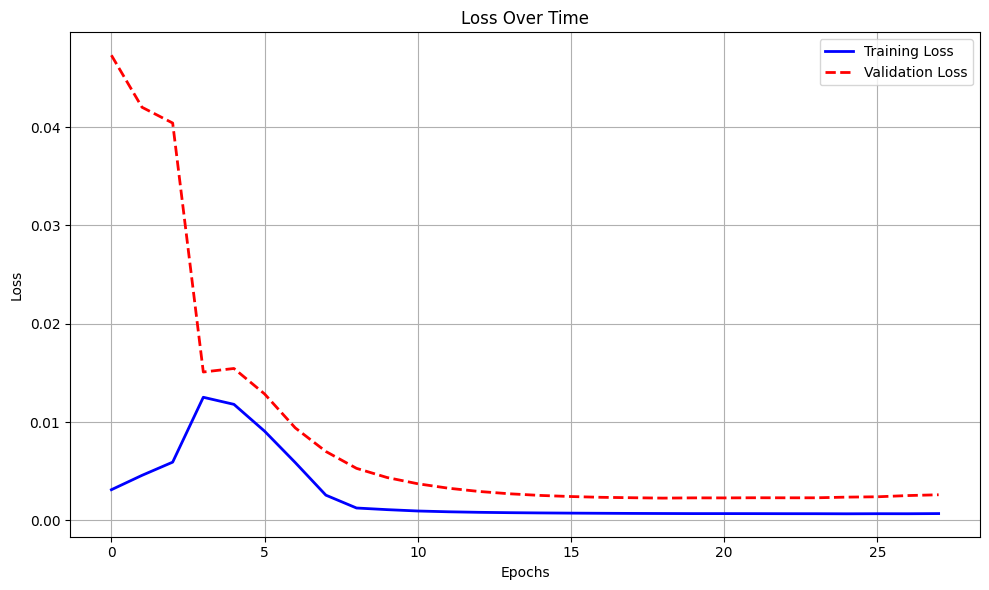

6/6 [==============================] - 1s 16ms/step


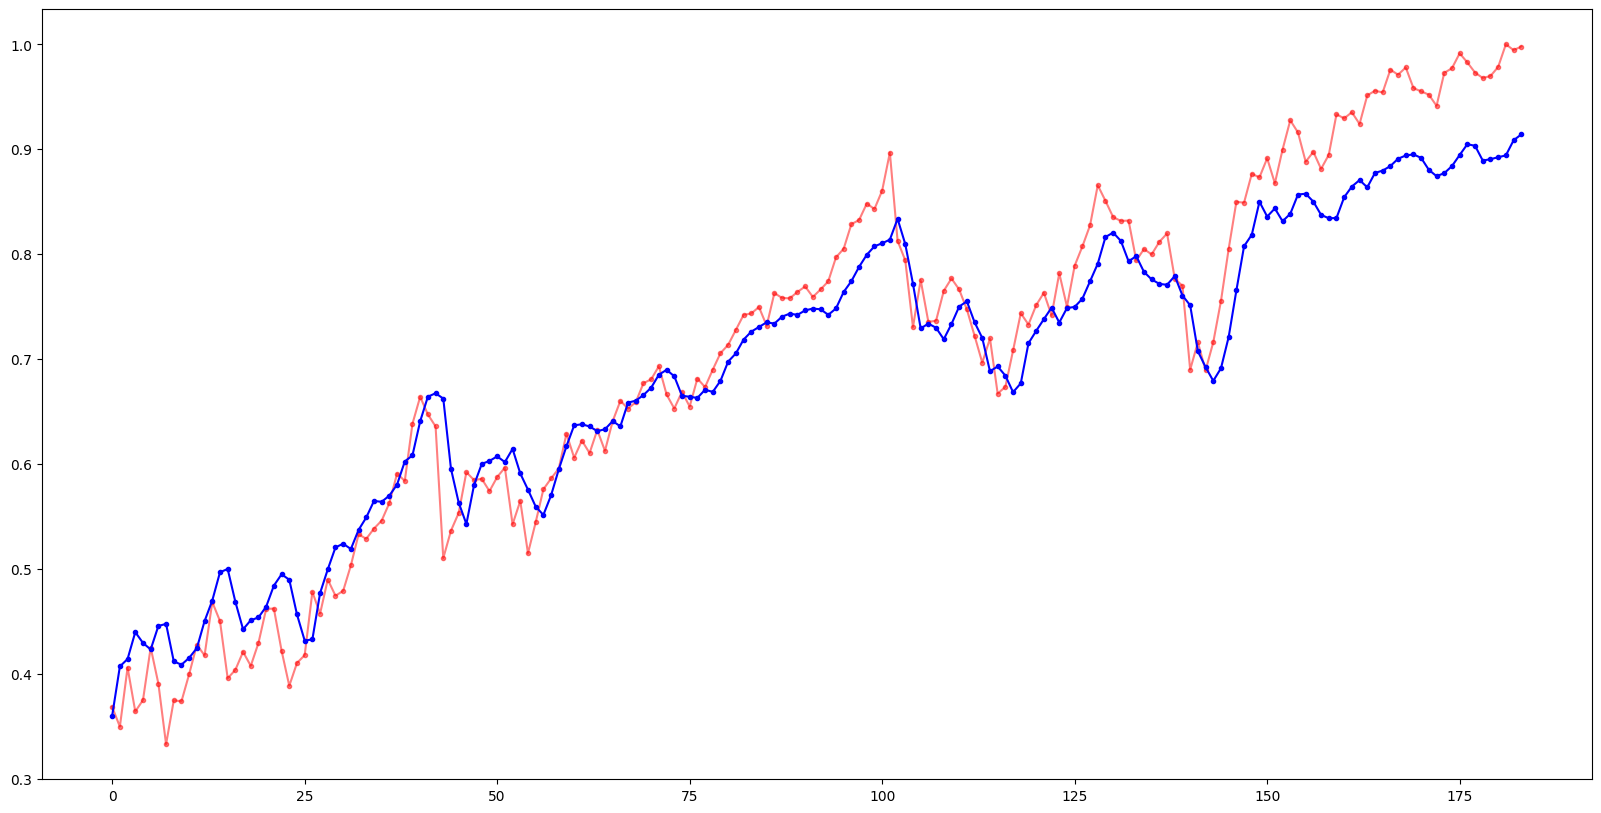

R2 Score: 0.9270932620534805
MAE: 0.03800203470932032
RMSE: 0.047948618307080804


In [13]:
for lookback in range(1,15):
    x_train, y_train, x_test, y_test = lookback_test(lookback)
    model_1 = (build_and_test_model(120, 100, 1))
    loss_view(model_1, 1)
    y_pred = prediction(model_1, 1)
    scores(y_pred, 1)
    save(model_1, 1)
    model_4 = (build_and_test_model(200, 100, 4))
    loss_view(model_4, 4)
    y_pred = prediction(model_4, 4)
    scores(y_pred, 4)
    save(model_4, 4)
    model_7 = (build_and_test_model(120, 105, 7))
    loss_view(model_7, 7)
    y_pred = prediction(model_7, 7)
    scores(y_pred, 7)
    save(model_7, 7)